In [1]:
###################
# Pick An Example #
###################

#[Input Vars]
#  1. <int> i: the index of the training dataset
#  2. <dataframe> DF_TRAIN: Dataframe-like format
#
#[Output Vars]
#  1. <ndarray> X: Image
#  2. <ndarray> Y: The label to the image

import numpy as np

def pick_an_example(i, DF_TRAIN):
    X = DF_TRAIN[i:i+1].values[0][1:].reshape(28,28,1)
    Y = DF_TRAIN[i:i+1].values[0][0]
    return X, Y

#i = np.random.randint(len(DF_TRAIN))
#X, Y = pick_an_example(i, DF_TRAIN)
#print(f"The Label of the {i}-th example is {Y}\nThe corresponding data is at below.")
#plt.imshow(X, cmap=plt.get_cmap('gray'))
#plt.show()

In [2]:
################
# Zero Padding #
################

#[Input Vars]
#  1. <ndarray> X: Unpadded image. The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <int> pad: expected number of pads on each side. The shape is (n_H_prev + 2 * pad, n_W_prev + 2 * pad, n_C_prev).
#
#[Output Vars]
#  1. <ndarray> X_pad: Padded image.

import numpy as np

def __zero_pad(X, pad):
    X_pad = np.pad(X, ((pad, pad), (pad, pad),(0,0)), "constant", constant_values = 0)
    return X_pad

#X_pad = __zero_pad(X, 2)

#plt.imshow(X_pad, cmap=plt.get_cmap('gray'))
#plt.show()

In [3]:
####################
# Conv Single Step #
####################

#[Input Vars]
#  1. <ndarray> a_slice_prev: slice of previous feature maps. The shape is (f, f, n_C_prev).
#  2. <ndarray> K: A single weight matrix (kernel). The shape is (f, f, n_C_prev).
#  3. <ndarray> b: A single bias term. The shape is (1, 1, 1).
#
#[Output Vars]
#  1. <float> Z: a scalar derived from convolution operation.

import numpy as np

def __conv_single_step(s_slice, K, b):
    
    S = np.multiply(s_slice, K)
    Z = np.sum(S)
    Z = Z + float(b)
    
    return Z

In [4]:
############################
# Conv Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> S_prev: The previous feature maps (after activation and pooling). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> K: Kernels in a layer. The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> b: biases in a layer. THe shape is (1, 1, 1, n_C).
#  4. <dictionary> hparam: this contains hyper parameters like "pad" and "stride".
#
#[Output Vars]
#  1. <ndarray> C: This would be the feature map in the next layer (but before activation). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache the values needed for backward propagation.

import numpy as np

def conv_forward(S_prev, K, b, hparam):
    
    # 1. Retrieve shape of A_prev. We need this to compute the shape of the feature map in the next layer.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 2. Retrieve shape of K. We also need this (i.e. f) to compute the shape of the feature map in the next layer.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 3. Retrieve info. from hyper parameters. We need them to compute the shape of the feature map in the next layer, too.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 4. With info from 1. ~ 3., we can compute the dimension for the feature map in the next layer.
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 5. Initialize feature maps in the next layer with zeros. Note #Kernel is equal to #Channel of the feature map.
    C = np.zeros((n_H, n_W, n_C))
    
    # 6. Pad S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    
    # 7. Do Cross-Relation Operation. Note the shape of the output feature map would be (n_H, n_W, n_C).
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the S_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Feed it into __conv_single_step(a_slice, K, b). Note we use one kernel and one bias term at once.
                C[h, w, c] = __conv_single_step(S_prev_slice, K[:,:,:,c], b[:,:,:,c])
    
    # 8. Check if the output feature map have the valid shape.
    assert(C.shape == (n_H, n_W, n_C))
    
    # 9. Store the cache for backward propagation
    cache = (S_prev, K, b, hparam)
    
    return C, cache

In [5]:
############################
# Pool Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> A_prev: The previous feature maps (after activation). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <dictionary> hparam: It contains "f" and "stride".
#  3. <string> mode: Switch between "maxpooling" and "avgpooling". The shape is (n_H, n_W, n_C). (n_C = n_C_prev)
#
#[Output Vars]
#  1. <ndarray> S: The output feature map after pooling operation.

import numpy as np

def pool_forward(A_prev, hparam, mode = "maxpooling"):
    # 1. Retrieve shape of A_prev.
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # 2. Retrieve info from hyper parameter
    f = hparam["f"]
    stride = hparam["stride"]

    # 3. Define the shape of output of pooling operation.
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # 4. Initialize the output feature map after pooling operation with zeros.
    S = np.zeros((n_H, n_W, n_C))
    
    # 5. Do Pooling Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice. (Note that there's only one channel involved. Not like conv_forward)
                A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                
                # Pooling operation
                if mode == "maxpooling":
                    S[h, w, c] = np.max(A_prev_slice)
                elif mode == "avgpooling":
                    S[h, w, c] = np.mean(A_prev_slice)
                    
    # 6. Check if the output feature map have the valid shape.
    assert(S.shape == (n_H, n_W, n_C))
    
    # 7. Store the cache for backward propagation
    cache = (A_prev, hparam)
    
    return S, cache

In [6]:
#############################
# Conv Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dC: gradient of the cost with respect to the output of the conv layer (C). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache of output of conv_forward()
#
#[Output Vars]
#  1. <ndarray> dS_prev: gradient of the cost w.r.t. the input of the conv layer (S). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> dK: gradient of the cost w.r.t. the weights of the conv layer (K). The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> db: gradient of the cost w.r.t. the biases of the conv layer (b). The shape is (1, 1, 1, n_C).

def conv_backward(dC, cache):
    
    # 1. Retrieve info. from cache.
    (S_prev, K, b, hparam) = cache
    
    # 2. Retrieve the shape of S_prev.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 3. Retrieve the shape of Kernel.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 4. Retieve info. from hyper parameters.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 5. Retrieve the shape of dC
    (n_H, n_W, n_C) = dC.shape
    
    # 6. Initialize dS_prev, dK, db with the correct shapes.
    dS_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    dK = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # 7. Pad dS_prev and S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    dS_prev_pad = __zero_pad(dS_prev, pad)
    
    # 8. Do backward pass operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                    
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Update Gradients (dS_prev, dK, db) for the window
                dS_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :] += K[:,:,:,c] * dC[h, w, c]
                dK[: , :, :, c] += S_prev_slice * dC[h, w, c]
                db[: , :, :, c] += dC[h, w, c]
                
    # 9. Unpad dS_prev_pad
    if (pad == 0):
        dS_prev = dS_prev_pad
    else:
        dS_prev[:, :, :] = dS_prev_pad[pad:-pad, pad:-pad, :]
    
    
    # 10 Check the validity of the shape
    assert (dS_prev.shape == (n_H_prev, n_W_prev, n_C_prev))
    
    return dS_prev, dK, db

In [7]:
############################
# Max Pool Backward helper #
############################

import numpy as np

def __create_mask_from_window(s):
    mask = (s == np.max(s))
    return mask

############################
# Avg Pool Backward helper #
############################

def __distribute_value(ds, shape):
    
    # 1. Retrieve dimensions from shape
    (n_H, n_W) = shape
    
    # 2. Compute the value to distribute on the matrix
    average = ds / (n_H * n_W)
    
    # 3. Create a matrix where each entry is the avg. value.
    a = np.ones(shape) * average
    return a

In [8]:
#############################
# Pool Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dS: gradient of cost w.r.t. the output of the pooling layer. The shape is the same as the shape of S.
#  2. <dictionary> cache: It contaions the output from the forward pass.
#  3. <string> mode: Switch between "maxpooling" and "avgpooling".
#
#[Output Vars]
#  1. <ndarray> dA_prev: gradient of cost w.r.t. the input of the pooling layer. The shape is the same as the shape of A_prev.

import numpy as np

def pool_backward(dS, cache, mode = "maxpooling"):
    
    # 1. Retrieve info. from cache
    (A_prev, hparam) = cache
    
    # 2. Retrieve hyper parameters
    stride = hparam["stride"]
    f = hparam["f"]
    
    # 3. Retrieve the shapes of A_prev and dS
    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_H, n_W, n_C = dS.shape
    
    # 4. Initialize dA_prev with zeros.
    dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    
    # 5. Do Backward Pass Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Compute the backward propagation in both modes
                if mode == "maxpooling":
                    # Use the corners and the specific "c" tp defome the current slice of A_prev
                    A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                    
                    # Create the mask from A_prev_slice
                    mask = __create_mask_from_window(A_prev_slice)
                    
                    # Update dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += np.multiply(mask, dS[h, w, c])
                elif mode == "avgpooling":
                    # Get the entry ds from dS
                    ds = dS[h, w, c]
                    
                    # Define the shape of the kernel as (f, f).
                    shape = (f, f)
                    
                    # Distribute it (ds) to the correct slice of dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += __distribute_value(ds, shape)
    
    # 6. Check the dA_prev has the valid shape 
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [9]:
#####################################
# Functions for Forward Propagation #
#####################################

# [Input Vars]
#   1. <ndarray> Z
#
# [Output Vars]
#   1. <ndarray> A

import numpy as np

def __sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

# [Input Vars]
#   1. <ndarray> A
#
# [Output Vars]
#   1. <ndarray> Y_pred
def __softmax(A):
    Y_pred = np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)))
    return Y_pred

In [37]:
# Initiallize the Kernels, Biases, and hparams

def Initialize_Parameters(low, high):
    
    # C1
    K_C1 = np.random.uniform(low=low, high=high, size=(5, 5, 1, 6))
    b_C1 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 6))
    hparam_C1 = {"stride": 1, "pad": 2}

    # S2
    hparam_S2 = {"f": 2, "stride": 2}

    # C3
    K_C3 = np.random.uniform(low=low, high=high, size=(5, 5, 6, 16))
    b_C3 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 16))
    hparam_C3 = {"stride":1, "pad": 0}

    # S4
    hparam_S4 = {"f": 2, "stride": 2}

    # C5
    K_C5 = np.random.uniform(low=low, high=high, size=(5, 5, 16, 120))
    b_C5 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 120))
    hparam_C5 = {"stride":1, "pad": 0}

    # W7
    W7 = np.random.uniform(low=low, high=high, size=(120, 84))

    # W8
    W8 = np.random.uniform(low=low, high=high, size=(84, 10))
    
    return K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8

In [106]:

# LeNet5 - Forward Propagation

def LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8):

    #print(f"[X : Input] The shape of X is {X.shape}.")

    X_C1, cache_C1 = conv_forward(X, K_C1, b_C1, hparam_C1)
    #print(f"[C1: Padding and Convolution] The shape becomes {X_C1.shape}.")

    X_A1 = __sigmoid(X_C1)
    #print(f"[A1: Activatiion] The shape remain {X_A1.shape}")

    X_S2, cache_S2 = pool_forward(X_A1, hparam_S2, mode = "avgpooling")
    #print(f"[S2: Pooling] The shape becomes {X_S2.shape}.")

    X_C3, cache_C3 = conv_forward(X_S2, K_C3, b_C3, hparam_C3)
    #print(f"[C3: Padding and Convolution] The shape becomes {X_C3.shape}.")

    X_A3 = __sigmoid(X_C3)
    #print(f"[A3: Activatiion] The shape remain {X_A3.shape}.")

    X_S4, cache_S4 = pool_forward(X_A3, hparam_S4, mode = "avgpooling")
    #print(f"[S4: Pooling] The shape becomes {X_S4.shape}.")

    X_C5, cache_C5 = conv_forward(X_S4, K_C5, b_C5, hparam_C5)
    #print(f"[C5: Perform Padding and Convolution] The shape becomes {X_C5.shape}.")

    X_A5 = __sigmoid(X_C5)
    #print(f"[A5: Activatiion] The shape remain {X_A5.shape}.")

    X_A6 = X_A5.reshape(1, 120)
    #print(f"[A6: Reshape] The shape becomes {X_A6.shape}.")

    X_Z7 = np.dot(X_A6, W7)
    #print(f"[Z7: Linear] The shape becomes {X_Z7.shape}.")

    X_A7 = __sigmoid(X_Z7)
    #print(f"[A7: Activatiion] The shape remain {X_A7.shape}.")

    X_Z8 = np.dot(X_A7, W8)
    #print(f"[Z7: Linear] The shape becomes {X_Z8.shape}.")

    X_A8 = __sigmoid(X_Z8)
    #print(f"[A8: Activatiion] The shape remain {X_A8.shape}.")

    Y_pred = __softmax(X_A8)
    #print(f"[Y_pred: Softmax] The shape remain {Y_pred.shape}")
    
    return cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred

In [107]:
def cross_entropy(Y_pred, Y_truth):
    Error = (-1 * Y_truth * np.log(Y_pred)).sum()
    return Error

In [108]:
# LeNet5 - Backward Propagation
def LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth):
    D_A8 = Y_pred - Y_truth
    #print(f"[D_A8:    Softmax] The shape is {D_A8.shape}.")

    D_Z8_local = np.multiply(1 - X_A8, X_A8)
    D_Z8 = np.multiply(D_Z8_local, D_A8)
    #print(f"[D_Z8: Activation] The shape is {D_Z8.shape}.")

    D_W8 = np.outer(X_A7, D_Z8)
    #print(f"[D_W8:    Product] The shape is {D_W8.shape}.")

    D_A7 = np.dot(D_Z8, D_W8.T)
    #print(f"[D_A7:    Product] The shape is {D_A7.shape}.")

    D_Z7_local = np.multiply(1 - X_A7, X_A7)
    D_Z7 = np.multiply(D_Z7_local, D_A7)
    #print(f"[D_Z7: Activation] The shape is {D_Z7.shape}.")

    D_W7 = np.outer(X_A6, D_Z7)
    #print(f"[D_W7:    Product] The shape is {D_W7.shape}.")

    D_A6 = np.dot(D_Z7, D_W7.T)
    #print(f"[D_A6:    Product] The shape is {D_A6.shape}.")

    D_A5 = D_A6.reshape(1,1,120)
    #print(f"[D_A5:    Reshape] The shape is {D_A5.shape}.")

    D_C5_local = np.multiply(1 - X_A5, X_A5)
    D_C5 = np.multiply(D_C5_local, D_A5)
    #print(f"[D_C5: Activation] The shape is {D_C5.shape}.")

    D_S4, D_K_C5, D_b_C5 = conv_backward(D_C5, cache_C5)
    #print(f"[D_S4: Conv. Back] The shape is {D_S4.shape}.")
    #print(f"[D_K_C5:   Kernel] The shape is {D_K_C5.shape}.")
    #print(f"[D_b_C5:     Bias] The shape is {D_b_C5.shape}.")

    D_A3 = pool_backward(D_S4, cache_S4, mode = "avgpooling")
    #print(f"[D_A3: Conv. Back] The shape is {D_A3.shape}.")

    D_C3_local = np.multiply(1 - X_A3, X_A3)
    D_C3 = np.multiply(D_C3_local, D_A3)
    #print(f"[D_C3: Activation] The shape is {D_C3.shape}.")

    D_S2, D_K_C3, D_b_C3 = conv_backward(D_C3, cache_C3)
    #print(f"[D_S2: Conv. Back] The shape is {D_S2.shape}.")
    #print(f"[D_K_C3:   Kernel] The shape is {D_K_C3.shape}.")
    #print(f"[D_b_C3:     Bias] The shape is {D_b_C3.shape}.")

    D_A1 = pool_backward(D_S2, cache_S2, mode = "avgpooling")
    #print(f"[D_A1: Conv. Back] The shape is {D_A1.shape}.")

    D_C1_local = np.multiply(1 - X_A1, X_A1)
    D_C1 = np.multiply(D_C1_local, D_A1)
    #print(f"[D_C1: Activation] The shape is {D_C1.shape}.")

    D_X, D_K_C1, D_b_C1 = conv_backward(D_C1, cache_C1)
    #print(f"[D_X:  Conv. Back] The shape is {D_X.shape}.")
    #print(f"[D_K_C1:   Kernel] The shape is {D_K_C1.shape}.")
    #print(f"[D_b_C1:     Bias] The shape is {D_b_C1.shape}.")
    
    return D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1

In [14]:
def update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1):
    
    W8 = W8 - lr * D_W8
    W7 = W7 - lr * D_W7
    K_C5 = K_C5 - lr * D_K_C5
    b_C5 = b_C5 - lr * D_b_C5
    K_C3 = K_C3 - lr * D_K_C3
    b_C3 = b_C3 - lr * D_b_C3
    K_C1 = K_C1 - lr * D_K_C1
    b_C1 = b_C1 - lr * D_b_C1
    
    return W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1

In the Root Path, there are ['sample_submission.csv', 'test.csv', 'train.csv']
[2.2918] The 0-th example: 
Y_pred: [[0.09967379 0.10107944 0.09989209 0.09979804 0.10073345 0.10032862
  0.09922807 0.10009067 0.09927584 0.09989997]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.306] The 1-th example: 
Y_pred: [[0.09966066 0.10119833 0.09987888 0.09978486 0.10071992 0.10031524
  0.09921511 0.10007738 0.09926286 0.09988675]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2908] The 2-th example: 
Y_pred: [[0.09977834 0.10118483 0.09986586 0.09977187 0.10070659 0.10030206
  0.09920235 0.10006429 0.09925008 0.09987373]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2957] The 3-th example: 
Y_pred: [[0.09976516 0.10130375 0.09985264 0.0997587  0.10069306 0.10028868
  0.09918939 0.100051   0.09923711 0.09986051]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3051] The 4-th example: 
Y_pred: [[0.09975205 0.10129006 0.0998395  0.09974558 0.10081159 0.10027537
  0.0991765  0.10003778 0.0992

[2.2969] The 42-th example: 
Y_pred: [[0.09977957 0.10156783 0.09986641 0.10003268 0.10056851 0.10003819
  0.09895207 0.09993303 0.09912764 0.10013408]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2957] The 43-th example: 
Y_pred: [[0.09976657 0.10155418 0.09985338 0.10001959 0.10068597 0.10002509
  0.09893939 0.09991997 0.0991149  0.10012095]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3042] The 44-th example: 
Y_pred: [[0.09975357 0.10154053 0.09984035 0.10000649 0.1008035  0.10001199
  0.09892671 0.09990691 0.09910215 0.10010781]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3135] The 45-th example: 
Y_pred: [[0.09974068 0.10152699 0.09995714 0.09999351 0.10079023 0.09999901
  0.09891415 0.09989397 0.09908952 0.10009479]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3028] The 46-th example: 
Y_pred: [[0.09972795 0.10151361 0.09994433 0.09998068 0.10077711 0.09998618
  0.09903    0.09988118 0.09907704 0.10008193]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3039] T

[2.3042] The 34-th example: 
Y_pred: [[0.09988405 0.10152568 0.0998416  0.10026399 0.10066602 0.09975447
  0.09880935 0.10003617 0.09898294 0.10023573]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2876] The 35-th example: 
Y_pred: [[0.09987122 0.10151226 0.09995742 0.10025103 0.10065291 0.0997417
  0.09879694 0.10002329 0.09897046 0.10022277]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3002] The 36-th example: 
Y_pred: [[0.0998582  0.10162933 0.09994436 0.10023786 0.10063959 0.09972872
  0.09878433 0.10001021 0.09895779 0.10020962]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2866] The 37-th example: 
Y_pred: [[0.09984534 0.10161583 0.09993146 0.10035397 0.10062644 0.09971591
  0.09877188 0.09999729 0.09894527 0.10019662]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2854] The 38-th example: 
Y_pred: [[0.09983231 0.10173291 0.09991841 0.10034076 0.10061313 0.09970293
  0.09875927 0.09998421 0.09893259 0.10018347]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2966] Th

[2.3173] The 26-th example: 
Y_pred: [[0.09998538 0.10200156 0.09994327 0.10061855 0.10076033 0.09947546
  0.09854261 0.1000084  0.09871396 0.09995049]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3032] The 27-th example: 
Y_pred: [[0.09997283 0.1019883  0.09993074 0.10060577 0.1007475  0.0994631
  0.0986561  0.09999584 0.09870189 0.09993795]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3021] The 28-th example: 
Y_pred: [[0.09996007 0.10197483 0.099918   0.10059278 0.10073446 0.09945053
  0.09864384 0.09998307 0.09868961 0.10005281]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3029] The 29-th example: 
Y_pred: [[0.09994731 0.10196135 0.09990525 0.10057978 0.10072141 0.09943796
  0.09863158 0.0999703  0.09867733 0.10016775]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.316] The 30-th example: 
Y_pred: [[0.09993456 0.10194788 0.09989252 0.1005668  0.10070838 0.0994254
  0.09861933 0.10008514 0.09866507 0.10015492]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3012] The 

[2.3028] The 18-th example: 
Y_pred: [[0.0999577  0.1024697  0.09978961 0.10083942 0.10097995 0.09907642
  0.09828085 0.09998035 0.09845    0.10017601]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.312] The 19-th example: 
Y_pred: [[0.09994504 0.10245617 0.09977702 0.10082645 0.10096693 0.09906409
  0.09826884 0.10009426 0.09843792 0.10016327]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3185] The 20-th example: 
Y_pred: [[0.09993253 0.10244279 0.09976457 0.10081362 0.10095405 0.09917712
  0.09825697 0.10008169 0.09842598 0.10015068]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3203] The 21-th example: 
Y_pred: [[0.09992013 0.10242952 0.09975223 0.1008009  0.10094128 0.099165
  0.0982452  0.10006924 0.0985383  0.1001382 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3052] The 22-th example: 
Y_pred: [[0.09990776 0.10241629 0.09973993 0.10078822 0.10092855 0.09915292
  0.09835729 0.10005682 0.09852646 0.10012575]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3036] The 

[2.3208] The 10-th example: 
Y_pred: [[0.09993111 0.10267444 0.09976453 0.10093061 0.10119673 0.0988107
  0.09814785 0.1000789  0.09819234 0.10027278]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3] The 11-th example: 
Y_pred: [[0.09991885 0.10266124 0.09975233 0.10091799 0.10118403 0.09879886
  0.09813627 0.10006658 0.09830346 0.10026039]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2765] The 12-th example: 
Y_pred: [[0.09990628 0.10264773 0.09973983 0.10090507 0.10117101 0.09878671
  0.09812438 0.10005396 0.09829151 0.10037352]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2937] The 13-th example: 
Y_pred: [[0.09989347 0.1027623  0.09972708 0.1008919  0.10115774 0.09877432
  0.09811225 0.10004109 0.09827931 0.10036054]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2926] The 14-th example: 
Y_pred: [[0.09988084 0.10274868 0.09971451 0.10100546 0.10114466 0.09876211
  0.0981003  0.10002841 0.0982673  0.10034774]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2756] The 1

[2.273] The 2-th example: 
Y_pred: [[0.09978045 0.10300264 0.09986364 0.10101967 0.10128367 0.09842823
  0.09801721 0.10005093 0.09806111 0.10049244]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.29] The 3-th example: 
Y_pred: [[0.09976775 0.1031164  0.09985091 0.10100654 0.10127045 0.09841605
  0.09800519 0.10003814 0.09804908 0.10047948]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.305] The 4-th example: 
Y_pred: [[0.09975523 0.10310273 0.09983836 0.10099357 0.10138332 0.09840404
  0.09799334 0.10002552 0.09803721 0.1004667 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3039] The 5-th example: 
Y_pred: [[0.09986693 0.10308927 0.09982599 0.10098079 0.10137041 0.09839221
  0.09798167 0.10001309 0.09802552 0.10045411]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3026] The 6-th example: 
Y_pred: [[0.0999787  0.10307579 0.09981362 0.10096801 0.1013575  0.09838038
  0.09797    0.10000065 0.09801383 0.10044151]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2931] The 7-th e

[2.3042] The 44-th example: 
Y_pred: [[0.09975494 0.10332487 0.09983744 0.10123125 0.1013685  0.09817442
  0.09776876 0.09989965 0.09793203 0.10070815]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3253] The 45-th example: 
Y_pred: [[0.09974269 0.10331143 0.09994829 0.10121849 0.10135568 0.09816276
  0.09775727 0.09988735 0.09792047 0.10069557]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2906] The 46-th example: 
Y_pred: [[0.09973078 0.10329834 0.0999363  0.10120606 0.10134321 0.09815144
  0.09786594 0.09987538 0.09790924 0.10068332]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.304] The 47-th example: 
Y_pred: [[0.09971838 0.10328474 0.09992383 0.10131789 0.10133024 0.09813963
  0.09785425 0.09986293 0.09789753 0.10067058]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3028] The 48-th example: 
Y_pred: [[0.09970615 0.10327132 0.09991152 0.1013051  0.10131745 0.098128
  0.09784273 0.09997373 0.09788599 0.10065801]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2896] The 

[2.2883] The 36-th example: 
Y_pred: [[0.09985308 0.10339161 0.099935   0.10144064 0.10120535 0.09792728
  0.09764529 0.09999657 0.09780677 0.10079843]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2694] The 37-th example: 
Y_pred: [[0.09984071 0.10337806 0.0999226  0.10155169 0.1011925  0.09791563
  0.09763375 0.09998415 0.09779517 0.10078573]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2683] The 38-th example: 
Y_pred: [[0.09982818 0.10348995 0.09991004 0.10153857 0.1011795  0.09790383
  0.09762206 0.09997157 0.09778342 0.10077287]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.291] The 39-th example: 
Y_pred: [[0.09981566 0.10360185 0.09989749 0.10152545 0.1011665  0.09789203
  0.09761037 0.09995899 0.09777166 0.10076001]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2951] The 40-th example: 
Y_pred: [[0.09980334 0.10358828 0.09988514 0.10151253 0.10127732 0.09788043
  0.09759888 0.09994662 0.09776011 0.10074735]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2675] Th

[2.2962] The 28-th example: 
Y_pred: [[0.09994811 0.10370458 0.09990827 0.10176819 0.10128874 0.09768392
  0.09752279 0.09996915 0.09756497 0.10064127]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.303] The 29-th example: 
Y_pred: [[0.0999359  0.10369114 0.09989607 0.10175536 0.10127606 0.09767255
  0.09751149 0.09995693 0.09755365 0.10075085]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3275] The 30-th example: 
Y_pred: [[0.09992377 0.1036778  0.09988397 0.10174262 0.10126348 0.09766127
  0.09750027 0.10006596 0.09754242 0.10073845]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2953] The 31-th example: 
Y_pred: [[0.09991203 0.10366485 0.09987224 0.10173026 0.10125128 0.09765036
  0.09748943 0.10005416 0.09764896 0.10072642]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2903] The 32-th example: 
Y_pred: [[0.09989983 0.10365143 0.09986005 0.10171744 0.10123861 0.09763901
  0.09747813 0.10004191 0.0976376  0.10083599]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2944] Th

[2.3297] The 20-th example: 
Y_pred: [[0.09991981 0.10413451 0.0997604  0.10196669 0.10149082 0.09744413
  0.09716924 0.1000607  0.09732665 0.10072706]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3314] The 21-th example: 
Y_pred: [[0.09990819 0.10412157 0.09974884 0.10195439 0.10147867 0.09743343
  0.09715864 0.10004904 0.09743206 0.10071517]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3052] The 22-th example: 
Y_pred: [[0.09989662 0.10410866 0.09973732 0.10194213 0.10146657 0.09742276
  0.09726382 0.10003741 0.0974214  0.10070331]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3037] The 23-th example: 
Y_pred: [[0.09988464 0.10409534 0.09984521 0.10192947 0.10145405 0.0974117
  0.09725282 0.10002538 0.09741034 0.10069106]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3043] The 24-th example: 
Y_pred: [[0.09999263 0.10408201 0.09983323 0.10191678 0.10144153 0.09740063
  0.09724181 0.10001334 0.09739927 0.10067878]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2837] Th

[2.2604] The 12-th example: 
Y_pred: [[0.09989338 0.104313   0.09973537 0.1020419  0.10169114 0.09709611
  0.09705373 0.10003292 0.09720944 0.100933  ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2825] The 13-th example: 
Y_pred: [[0.09988109 0.10442224 0.09972313 0.10202888 0.10167824 0.09708486
  0.09704249 0.10002058 0.09719815 0.10092035]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2814] The 14-th example: 
Y_pred: [[0.09986895 0.10440867 0.09971106 0.10213739 0.10166549 0.09707377
  0.09703142 0.10000839 0.09718701 0.10090786]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2596] The 15-th example: 
Y_pred: [[0.09985681 0.10439509 0.09969897 0.10224593 0.10165275 0.09706267
  0.09702034 0.0999962  0.09717587 0.10089536]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3057] The 16-th example: 
Y_pred: [[0.09984453 0.10450428 0.09968675 0.10223285 0.10163986 0.09705143
  0.09700912 0.09998387 0.09716459 0.10088272]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3043] T

[2.3051] The 4-th example: 
Y_pred: [[0.09974813 0.10473087 0.09982724 0.10211425 0.10188689 0.09675465
  0.09693915 0.10000422 0.09697965 0.10101495]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.304] The 5-th example: 
Y_pred: [[0.09985424 0.10471758 0.09981547 0.10210172 0.10187444 0.09674402
  0.09692845 0.09999239 0.09696893 0.10100278]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3028] The 6-th example: 
Y_pred: [[0.09996041 0.10470428 0.09980369 0.10208918 0.10186197 0.09673338
  0.09691774 0.09998055 0.09695821 0.10099059]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.282] The 7-th example: 
Y_pred: [[0.09994857 0.10469097 0.0997919  0.10207663 0.1018495  0.09672273
  0.09690702 0.1000868  0.09694747 0.1009784 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.336] The 8-th example: 
Y_pred: [[0.09993651 0.10467743 0.09977989 0.10218419 0.1018368  0.09671187
  0.09689609 0.1000747  0.09693653 0.10096599]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2811] The 9-th 

[2.2798] The 46-th example: 
Y_pred: [[0.09972379 0.10490121 0.09991922 0.10230634 0.10184257 0.09653403
  0.09682837 0.09986052 0.09686838 0.10121557]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3041] The 47-th example: 
Y_pred: [[0.09971188 0.1048877  0.09990724 0.10241315 0.10182995 0.09652331
  0.09681753 0.09984856 0.09685752 0.10120315]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.303] The 48-th example: 
Y_pred: [[0.09970023 0.10487446 0.09989553 0.10240062 0.1018176  0.09651284
  0.09680695 0.09995383 0.09684693 0.101191  ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2847] The 49-th example: 
Y_pred: [[0.09968857 0.10486121 0.09988381 0.10238808 0.10180524 0.09650237
  0.09679637 0.10005917 0.09683633 0.10117884]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2552] The 0-th example: 
Y_pred: [[0.09967672 0.10484777 0.09987189 0.10237534 0.10191176 0.09649171
  0.09678559 0.10004719 0.09682553 0.10116649]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3059] The

[2.2531] The 38-th example: 
Y_pred: [[0.09981517 0.10506786 0.09989309 0.10261347 0.10168025 0.09631754
  0.09660826 0.09995079 0.09675875 0.10129483]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.286] The 39-th example: 
Y_pred: [[0.09980317 0.1051744  0.09988106 0.10260056 0.10166763 0.09630683
  0.09659743 0.09993874 0.09674787 0.10128233]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.29] The 40-th example: 
Y_pred: [[0.09979138 0.10516098 0.09986925 0.10258786 0.10177322 0.09629634
  0.09658683 0.0999269  0.0967372  0.10127005]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2524] The 41-th example: 
Y_pred: [[0.09977964 0.10514761 0.09985748 0.10257521 0.10176082 0.09628589
  0.09657627 0.09991512 0.09672658 0.10137539]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2853] The 42-th example: 
Y_pred: [[0.09976765 0.10525408 0.09984546 0.10256231 0.10174817 0.0962752
  0.09656546 0.09990308 0.09671572 0.10136287]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2842] The 4

[2.3378] The 30-th example: 
Y_pred: [[0.09990497 0.10523128 0.09986724 0.10279773 0.10175455 0.09610545
  0.0965022  0.10003949 0.0965412  0.10125589]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2902] The 31-th example: 
Y_pred: [[0.09989396 0.1052187  0.09985624 0.10278581 0.10174294 0.09609581
  0.09649241 0.10002843 0.09664126 0.10124444]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2854] The 32-th example: 
Y_pred: [[0.09988228 0.10520542 0.09984457 0.1027732  0.10173065 0.09608553
  0.09648197 0.10001671 0.09663077 0.10134891]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2893] The 33-th example: 
Y_pred: [[0.09987056 0.1051921  0.09983286 0.10276056 0.10183536 0.09607521
  0.0964715  0.10000494 0.09662023 0.1013367 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3044] The 34-th example: 
Y_pred: [[0.09985888 0.10517882 0.09982119 0.10274795 0.10182304 0.09606493
  0.09646106 0.09999321 0.09660974 0.10144118]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2522] T

[2.3053] The 22-th example: 
Y_pred: [[0.09987799 0.10562701 0.09972662 0.10297771 0.10194256 0.09589661
  0.09628847 0.10001124 0.09643553 0.10121626]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3039] The 23-th example: 
Y_pred: [[0.09986657 0.1056139  0.09982919 0.10296532 0.10193048 0.09588665
  0.09627835 0.09999978 0.09642536 0.1012044 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3044] The 24-th example: 
Y_pred: [[0.09996923 0.10560079 0.09981777 0.10295291 0.10191838 0.09587668
  0.09626823 0.0999883  0.09641518 0.10119253]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2736] The 25-th example: 
Y_pred: [[0.09995777 0.10558768 0.09992037 0.10294052 0.1019063  0.09586671
  0.09625812 0.09997684 0.09640501 0.10118068]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3408] The 26-th example: 
Y_pred: [[0.09994602 0.10557427 0.09990863 0.10304483 0.10189391 0.09585646
  0.09624771 0.09996508 0.09639455 0.10116852]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2911] T

[2.2715] The 14-th example: 
Y_pred: [[0.0998501  0.10589734 0.09970003 0.10315333 0.10212627 0.09558456
  0.09607784 0.09998212 0.09622311 0.1014053 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2454] The 15-th example: 
Y_pred: [[0.09983845 0.10588393 0.09968843 0.10325689 0.10211389 0.09557448
  0.09606757 0.09997042 0.09621278 0.10139314]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3058] The 16-th example: 
Y_pred: [[0.0998267  0.10598774 0.09967673 0.10324408 0.10210141 0.09556429
  0.09605719 0.09995863 0.09620234 0.10138089]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3044] The 17-th example: 
Y_pred: [[0.0998154  0.10597466 0.09977837 0.10323171 0.10208938 0.09555454
  0.09604725 0.09994728 0.09619234 0.10136907]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3032] The 18-th example: 
Y_pred: [[0.09991712 0.10596156 0.09976706 0.10321933 0.10207734 0.09554479
  0.0960373  0.09993592 0.09618234 0.10135725]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3483] T

[2.303] The 6-th example: 
Y_pred: [[0.09993597 0.1061641  0.09978699 0.10309647 0.10230821 0.09528056
  0.09597856 0.09995455 0.09601606 0.10147852]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2722] The 7-th example: 
Y_pred: [[0.09992468 0.10615104 0.09977575 0.1030842  0.10229617 0.09527097
  0.09596869 0.10005559 0.09600618 0.10146673]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3511] The 8-th example: 
Y_pred: [[0.0999131  0.10613768 0.09976423 0.10318686 0.10228384 0.09526109
  0.09595854 0.10004397 0.09599602 0.10145466]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2713] The 9-th example: 
Y_pred: [[0.09990258 0.10612544 0.09975376 0.10317536 0.1022726  0.09535691
  0.09594942 0.10003341 0.09598688 0.10144366]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3436] The 10-th example: 
Y_pred: [[0.09989101 0.10611209 0.09974224 0.10327801 0.10226027 0.095347
  0.09593928 0.1000218  0.09597672 0.10143159]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2885] The 11-t

[2.3033] The 48-th example: 
Y_pred: [[0.09968762 0.10631177 0.09987357 0.10338449 0.1022607  0.09508763
  0.09588208 0.09992838 0.09591915 0.10166462]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2803] The 49-th example: 
Y_pred: [[0.09967651 0.10629877 0.09986239 0.10337224 0.10224877 0.09507818
  0.09587233 0.10002857 0.09590939 0.10165287]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2416] The 0-th example: 
Y_pred: [[0.09966516 0.10628554 0.09985099 0.10335975 0.10235028 0.09506852
  0.09586236 0.10001711 0.0958994  0.10164089]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3061] The 1-th example: 
Y_pred: [[0.09965365 0.10638756 0.09983941 0.1033471  0.10233792 0.09505868
  0.09585221 0.10000548 0.09588924 0.10162874]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2408] The 2-th example: 
Y_pred: [[0.09975357 0.10637459 0.09982828 0.1033349  0.10232601 0.09504929
  0.09584251 0.09999429 0.09587953 0.10161704]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2797] The 

[2.2854] The 40-th example: 
Y_pred: [[0.09977353 0.10657059 0.09984775 0.10355372 0.10221321 0.09489804
  0.09568291 0.09990197 0.09582345 0.10173484]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2391] The 41-th example: 
Y_pred: [[0.09976228 0.10655744 0.09983647 0.10354132 0.10220119 0.09488856
  0.09567313 0.09989068 0.09581362 0.10183531]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2809] The 42-th example: 
Y_pred: [[0.09975082 0.10665858 0.09982499 0.10352871 0.10218897 0.09487887
  0.09566313 0.09987917 0.09580357 0.1018232 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2799] The 43-th example: 
Y_pred: [[0.09973954 0.10664537 0.09981369 0.10351628 0.1022896  0.09486936
  0.09565332 0.09986786 0.09579371 0.10181126]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3046] The 44-th example: 
Y_pred: [[0.09972827 0.10663217 0.09980238 0.10350386 0.10239026 0.09485986
  0.09564351 0.09985653 0.09578384 0.10179932]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3472] T

[2.2811] The 32-th example: 
Y_pred: [[0.09985948 0.10659906 0.09982369 0.10372154 0.10216777 0.09471366
  0.09559176 0.09998691 0.09573088 0.10180524]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2848] The 33-th example: 
Y_pred: [[0.09984826 0.10658597 0.09981248 0.10370916 0.10226761 0.09470429
  0.09558206 0.09997565 0.09572113 0.1017934 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3046] The 34-th example: 
Y_pred: [[0.09983707 0.10657291 0.0998013  0.10369681 0.10225567 0.09469496
  0.09557239 0.09996442 0.09571141 0.10189306]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.239] The 35-th example: 
Y_pred: [[0.09982609 0.10656008 0.09989973 0.10368468 0.10224394 0.09468584
  0.09556293 0.0999534  0.09570189 0.10188144]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2665] The 36-th example: 
Y_pred: [[0.0998147  0.10666035 0.09988832 0.10367213 0.10223181 0.0946763
  0.09555305 0.09994197 0.09569197 0.10186941]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2382] The

[2.3046] The 24-th example: 
Y_pred: [[0.09994139 0.10696199 0.09979729 0.10388381 0.10234206 0.09453039
  0.09539799 0.09995904 0.09553544 0.10165059]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2646] The 25-th example: 
Y_pred: [[0.09993045 0.10694916 0.09989495 0.10387171 0.10233039 0.09452139
  0.09538866 0.0999481  0.09552606 0.10163913]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3499] The 26-th example: 
Y_pred: [[0.09991918 0.10693598 0.09988369 0.10397121 0.10231838 0.09451207
  0.095379   0.09993683 0.09551635 0.10162732]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2865] The 27-th example: 
Y_pred: [[0.09990895 0.10692391 0.09987347 0.10395982 0.10230744 0.09450373
  0.0954719  0.09992659 0.09550763 0.10161657]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2856] The 28-th example: 
Y_pred: [[0.09989784 0.1069109  0.09986237 0.10394752 0.10229559 0.09449457
  0.09546236 0.09991548 0.09549808 0.10171529]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3035] T

[2.306] The 16-th example: 
Y_pred: [[0.09980444 0.10731658 0.09966172 0.10415246 0.1025116  0.09425036
  0.09520614 0.09992959 0.09534195 0.10182515]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3047] The 17-th example: 
Y_pred: [[0.09979364 0.10730378 0.09975848 0.10414039 0.10249998 0.09424155
  0.09519696 0.09991875 0.09533272 0.10181373]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3035] The 18-th example: 
Y_pred: [[0.09989048 0.10729097 0.09974769 0.10412832 0.10248835 0.09423273
  0.09518778 0.0999079  0.09532348 0.1018023 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3621] The 19-th example: 
Y_pred: [[0.09987963 0.10727816 0.09973688 0.10411623 0.10247671 0.0942239
  0.09517858 0.10000481 0.09531424 0.10179086]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3507] The 20-th example: 
Y_pred: [[0.09986972 0.10726636 0.09972702 0.10410513 0.10246604 0.09431434
  0.09517027 0.09999486 0.09530588 0.10178038]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3522] The

[2.3647] The 8-th example: 
Y_pred: [[0.0998859  0.10744601 0.0997442  0.10408845 0.10268107 0.09397893
  0.0951199  0.10001008 0.09515477 0.10189069]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2626] The 9-th example: 
Y_pred: [[0.09987611 0.10743432 0.09973445 0.10407749 0.10267047 0.09406833
  0.09511172 0.10000025 0.09514657 0.10188031]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3524] The 10-th example: 
Y_pred: [[0.09986501 0.10742122 0.0997234  0.1041754  0.10265853 0.0940593
  0.0951023  0.09998911 0.09513714 0.10186859]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2842] The 11-th example: 
Y_pred: [[0.09985499 0.10740927 0.09971343 0.10416417 0.10264769 0.0940513
  0.09509391 0.09997905 0.09522822 0.10185797]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2312] The 12-th example: 
Y_pred: [[0.09984404 0.10739633 0.09970253 0.10415197 0.1026359  0.09404243
  0.09508464 0.09996806 0.09521889 0.10195521]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.262] The 13

[2.2296] The 0-th example: 
Y_pred: [[0.0996492  0.10757409 0.09982636 0.10424508 0.10274021 0.09381015
  0.0950361  0.09998405 0.09507058 0.10206418]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3062] The 1-th example: 
Y_pred: [[0.0996382  0.10767092 0.0998153  0.10423276 0.10272829 0.09380122
  0.09502671 0.09997295 0.09506118 0.10205245]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2288] The 2-th example: 
Y_pred: [[0.09973338 0.10765825 0.09980467 0.10422086 0.10271679 0.09379272
  0.09501774 0.09996226 0.0950522  0.10204114]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2759] The 3-th example: 
Y_pred: [[0.09972236 0.10775502 0.09979363 0.10420855 0.10270488 0.09378381
  0.09500836 0.09995117 0.09504281 0.10202942]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3055] The 4-th example: 
Y_pred: [[0.09971147 0.10774203 0.09978272 0.10419637 0.10280165 0.09377504
  0.09499913 0.09994021 0.09503356 0.10201783]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3045] The 5-

[2.2771] The 42-th example: 
Y_pred: [[0.09973027 0.10791675 0.09980105 0.10439807 0.1025818  0.09364369
  0.09485533 0.09985215 0.09498689 0.10223399]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2762] The 43-th example: 
Y_pred: [[0.09971947 0.10790383 0.09979023 0.10438593 0.1026778  0.09363505
  0.09484623 0.0998413  0.09497774 0.10222242]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3048] The 44-th example: 
Y_pred: [[0.09970866 0.10789091 0.0997794  0.10437378 0.10277382 0.0936264
  0.09483712 0.09983046 0.09496859 0.10221086]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3557] The 45-th example: 
Y_pred: [[0.09969812 0.10787827 0.09987389 0.10436192 0.10276238 0.09361802
  0.09482828 0.09981988 0.09495969 0.10219957]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.26] The 46-th example: 
Y_pred: [[0.09968835 0.10786648 0.09986408 0.10435087 0.10275173 0.09361035
  0.09491747 0.09981008 0.09495153 0.10218907]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3046] The 

[2.3048] The 34-th example: 
Y_pred: [[0.09981205 0.10782303 0.09977807 0.10455049 0.10264141 0.09348245
  0.09477635 0.09993301 0.09490663 0.10229651]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2274] The 35-th example: 
Y_pred: [[0.09980156 0.10781049 0.09987185 0.10453866 0.10263009 0.09347418
  0.0947676  0.09992247 0.09489783 0.10228527]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2583] The 36-th example: 
Y_pred: [[0.09979069 0.10790567 0.09986095 0.10452647 0.10261838 0.09346552
  0.09475845 0.09991156 0.09488864 0.10227366]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2266] The 37-th example: 
Y_pred: [[0.09977985 0.10789276 0.09985009 0.10462206 0.10260671 0.09345692
  0.09474936 0.09990068 0.09487949 0.10226208]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2257] The 38-th example: 
Y_pred: [[0.09976898 0.10798787 0.09983921 0.10460985 0.10259501 0.09344827
  0.09474023 0.09988978 0.09487031 0.10225048]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2771] T

[2.3581] The 26-th example: 
Y_pred: [[0.09988978 0.10815661 0.09985605 0.10480458 0.10269717 0.09332163
  0.0946006  0.09990619 0.09472936 0.10203804]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2825] The 27-th example: 
Y_pred: [[0.09988014 0.10814498 0.09984642 0.10479363 0.10268673 0.09331422
  0.09468812 0.09989655 0.09472144 0.10202778]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2816] The 28-th example: 
Y_pred: [[0.09986949 0.10813225 0.09983578 0.10478161 0.10267526 0.09330587
  0.09467925 0.09988589 0.09471256 0.10212205]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3038] The 29-th example: 
Y_pred: [[0.09985884 0.10811951 0.09982513 0.10476959 0.10266378 0.09329752
  0.09467038 0.09987523 0.09470368 0.10221633]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3571] The 30-th example: 
Y_pred: [[0.0998484  0.108107   0.0998147  0.10475779 0.10265253 0.09328938
  0.09466172 0.09996828 0.09469501 0.10220519]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2809] T

[2.3038] The 18-th example: 
Y_pred: [[0.09986157 0.10848226 0.09972551 0.10494632 0.1028552  0.09307058
  0.09442635 0.09987779 0.09455363 0.10220079]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3745] The 19-th example: 
Y_pred: [[0.0998512  0.10846977 0.09971518 0.10493455 0.10284396 0.09306256
  0.09441784 0.09997016 0.09454506 0.10218973]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3588] The 20-th example: 
Y_pred: [[0.09984195 0.10845852 0.09970597 0.10492399 0.10283389 0.09314704
  0.09441038 0.09996088 0.09453755 0.10217983]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3602] The 21-th example: 
Y_pred: [[0.09983241 0.10844693 0.09969647 0.1049131  0.10282351 0.09313976
  0.09440264 0.09995129 0.09462427 0.10216962]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3057] The 22-th example: 
Y_pred: [[0.09982289 0.10843538 0.099687   0.10490224 0.10281317 0.09313251
  0.09448914 0.09994175 0.09461648 0.10215944]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3045] T

[2.3604] The 10-th example: 
Y_pred: [[0.09983687 0.10859475 0.09970191 0.10498346 0.10301398 0.09291812
  0.09435172 0.09995484 0.09438424 0.10226012]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2803] The 11-th example: 
Y_pred: [[0.09982742 0.10858325 0.0996925  0.10497266 0.10300365 0.092911
  0.09434408 0.09994536 0.09447009 0.10224999]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2204] The 12-th example: 
Y_pred: [[0.09981692 0.1085706  0.09968204 0.10496076 0.10299224 0.09290291
  0.09433545 0.09993482 0.09446142 0.10234285]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2543] The 13-th example: 
Y_pred: [[0.09980629 0.10866321 0.09967146 0.10494875 0.10298071 0.09289467
  0.09432668 0.09992416 0.0944526  0.10233149]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2534] The 14-th example: 
Y_pred: [[0.09979566 0.10865042 0.09966087 0.10504207 0.10296918 0.09288645
  0.09431792 0.0999135  0.0944438  0.10232013]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2197] The

[2.2182] The 2-th example: 
Y_pred: [[0.09971083 0.10880899 0.09977894 0.10501915 0.10306582 0.09267869
  0.09427773 0.09992881 0.09430992 0.10242113]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2725] The 3-th example: 
Y_pred: [[0.09970031 0.10890079 0.09976841 0.10500721 0.10305436 0.09267059
  0.09426904 0.09991823 0.09430122 0.10240983]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3057] The 4-th example: 
Y_pred: [[0.09968987 0.10888813 0.09975795 0.10499533 0.10314673 0.0926626
  0.09426045 0.09990772 0.09429261 0.10239861]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3048] The 5-th example: 
Y_pred: [[0.09978064 0.10887576 0.09974778 0.10498374 0.1031356  0.09265488
  0.09425214 0.0998975  0.09428429 0.10238767]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3037] The 6-th example: 
Y_pred: [[0.09987145 0.10886339 0.0997376  0.10497215 0.10312446 0.09264716
  0.09424382 0.09988728 0.09427596 0.10237673]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2542] The 7-t

[2.305] The 44-th example: 
Y_pred: [[0.09968685 0.10901941 0.09975446 0.10515786 0.10311667 0.09253228
  0.09411333 0.09980272 0.09423677 0.10257964]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3633] The 45-th example: 
Y_pred: [[0.09967677 0.1090071  0.09984459 0.10514631 0.10310562 0.09252466
  0.09410513 0.09979259 0.09422852 0.10256872]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2525] The 46-th example: 
Y_pred: [[0.09966755 0.10899575 0.09983533 0.10513569 0.10309547 0.09251784
  0.09418924 0.09978334 0.09422108 0.10255871]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3049] The 47-th example: 
Y_pred: [[0.09965711 0.10898309 0.09982484 0.10522757 0.10308406 0.09250987
  0.09418066 0.09977287 0.09421249 0.10254744]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.304] The 48-th example: 
Y_pred: [[0.09964704 0.10897079 0.09981472 0.105216   0.10307302 0.09250226
  0.09417243 0.09986297 0.09420424 0.10253653]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2724] The

[2.251] The 36-th example: 
Y_pred: [[0.09976492 0.10902292 0.09983208 0.10529665 0.10296456 0.09239088
  0.09404483 0.09987993 0.09416712 0.10263611]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2163] The 37-th example: 
Y_pred: [[0.09975452 0.10901033 0.09982166 0.10538785 0.10295326 0.09238302
  0.09403636 0.0998695  0.0941586  0.1026249 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2155] The 38-th example: 
Y_pred: [[0.09974416 0.10910059 0.09981128 0.10537601 0.10294201 0.09237516
  0.09402789 0.0998591  0.09415009 0.10261372]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2737] The 39-th example: 
Y_pred: [[0.0997338  0.10919078 0.0998009  0.10536418 0.10293076 0.0923673
  0.09401943 0.09984871 0.09414158 0.10260256]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.277] The 40-th example: 
Y_pred: [[0.09972351 0.10917826 0.09979059 0.1053524  0.10302163 0.09235955
  0.09401107 0.09983838 0.09413317 0.10259145]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2149] The 

[2.278] The 28-th example: 
Y_pred: [[0.09983988 0.10922809 0.09980779 0.10553352 0.1030155  0.09225026
  0.09397559 0.0998552  0.09400676 0.10248741]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3041] The 29-th example: 
Y_pred: [[0.09982965 0.10921567 0.09979758 0.1055218  0.10300439 0.09224263
  0.09396733 0.09984497 0.09399848 0.10257751]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3646] The 30-th example: 
Y_pred: [[0.09981966 0.10920349 0.09978759 0.10551033 0.10299351 0.09223522
  0.09395928 0.09993376 0.09399043 0.10256674]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2773] The 31-th example: 
Y_pred: [[0.09981055 0.10919231 0.0997785  0.1054998  0.10298355 0.09222862
  0.09395207 0.09992463 0.09407309 0.10255689]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2733] The 32-th example: 
Y_pred: [[0.09980034 0.1091799  0.09976829 0.10548809 0.10297245 0.092221
  0.09394381 0.09991438 0.09406479 0.10264695]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2766] The 

[2.3661] The 20-th example: 
Y_pred: [[0.0998131  0.109528   0.09968336 0.10566243 0.10316361 0.09210989
  0.09372741 0.09992632 0.09384697 0.10253891]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3674] The 21-th example: 
Y_pred: [[0.09980408 0.10951687 0.09967438 0.10565197 0.10315371 0.0921034
  0.09372035 0.09991727 0.09392882 0.10252916]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3059] The 22-th example: 
Y_pred: [[0.09979509 0.10950577 0.09966543 0.10564153 0.10314383 0.09209694
  0.093802   0.09990825 0.09392171 0.10251944]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3047] The 23-th example: 
Y_pred: [[0.0997852  0.10949365 0.09975341 0.10563013 0.10313302 0.09208965
  0.09379409 0.09989832 0.09391376 0.10250878]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3052] The 24-th example: 
Y_pred: [[0.09987324 0.10948152 0.09974351 0.10561872 0.10312219 0.09208236
  0.09378618 0.09988838 0.0939058  0.10249811]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.248] The

[2.2107] The 12-th example: 
Y_pred: [[0.0997888  0.10962449 0.09966009 0.10569059 0.10331164 0.09188998
  0.09366176 0.09990109 0.09378022 0.10269133]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2473] The 13-th example: 
Y_pred: [[0.09977866 0.10971237 0.09964999 0.10567897 0.10330056 0.09188248
  0.09365362 0.09989092 0.09377204 0.1026804 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2465] The 14-th example: 
Y_pred: [[0.09976847 0.10969993 0.09963984 0.10576802 0.1032894  0.09187496
  0.09364546 0.09988069 0.09376383 0.1026694 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2101] The 15-th example: 
Y_pred: [[0.09975829 0.10968749 0.09962969 0.10585704 0.10327825 0.09186745
  0.0936373  0.09987047 0.09375563 0.1026584 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3064] The 16-th example: 
Y_pred: [[0.09974816 0.10977528 0.0996196  0.10584539 0.10326718 0.09185996
  0.09362917 0.09986031 0.09374746 0.10264749]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3052] T

[2.3059] The 4-th example: 
Y_pred: [[0.09966707 0.10991661 0.0997322  0.10571679 0.10345609 0.09167331
  0.09359589 0.09987486 0.09362603 0.10274117]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3051] The 5-th example: 
Y_pred: [[0.09975374 0.10990459 0.09972245 0.10570552 0.10344534 0.09166627
  0.09358815 0.09986507 0.09361829 0.10273059]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.304] The 6-th example: 
Y_pred: [[0.09984046 0.10989256 0.0997127  0.10569424 0.10343458 0.09165923
  0.09358042 0.09985527 0.09361054 0.10272001]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2473] The 7-th example: 
Y_pred: [[0.09983066 0.10988053 0.09970294 0.10568296 0.10342381 0.09165218
  0.09357267 0.09994204 0.09360278 0.10270942]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3898] The 8-th example: 
Y_pred: [[0.09982053 0.10986815 0.09969285 0.10577129 0.10341271 0.0916448
  0.09356459 0.09993187 0.0935947  0.1026985 ]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2466] The 9-th

[2.2458] The 46-th example: 
Y_pred: [[0.0996456  0.1100096  0.099806   0.10584459 0.10340401 0.09154569
  0.09353373 0.09975594 0.09356359 0.10289125]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3051] The 47-th example: 
Y_pred: [[0.09963559 0.10999728 0.09979594 0.10593228 0.10339298 0.0915384
  0.09352572 0.0997459  0.09355557 0.10288035]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3043] The 48-th example: 
Y_pred: [[0.09962593 0.10998533 0.09978624 0.10592104 0.10338231 0.09153145
  0.09351806 0.09983195 0.0935479  0.1028698 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2694] The 49-th example: 
Y_pred: [[0.09961627 0.10997337 0.09977653 0.10590979 0.10337163 0.09152451
  0.0935104  0.09991805 0.09354022 0.10285925]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2076] The 0-th example: 
Y_pred: [[0.09960634 0.10996113 0.09976656 0.10589826 0.10345917 0.09151731
  0.09350248 0.09990803 0.09353229 0.10284844]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3066] The

[2.2064] The 38-th example: 
Y_pred: [[0.09971859 0.11010002 0.09978283 0.10606806 0.10325404 0.09141972
  0.09338641 0.09982816 0.09350146 0.10294072]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2707] The 39-th example: 
Y_pred: [[0.09970871 0.11018563 0.09977293 0.10605662 0.10324322 0.09141256
  0.09337855 0.09981824 0.09349356 0.10292998]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2738] The 40-th example: 
Y_pred: [[0.09969883 0.11017344 0.09976303 0.10604515 0.1033301  0.09140546
  0.09337074 0.09980833 0.09348571 0.10291922]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2058] The 41-th example: 
Y_pred: [[0.09968897 0.11016128 0.09975315 0.1060337  0.10331926 0.09139837
  0.09336295 0.09979844 0.09347787 0.10300601]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.27] The 42-th example: 
Y_pred: [[0.0996791  0.1102468  0.09974326 0.10602228 0.10330844 0.09139123
  0.0933551  0.09978853 0.09346999 0.10299526]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2692] The

[2.3713] The 30-th example: 
Y_pred: [[0.09979057 0.11018881 0.09976002 0.10619027 0.10330032 0.09129609
  0.09332637 0.09989936 0.09335561 0.10289258]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2742] The 31-th example: 
Y_pred: [[0.09978196 0.11017806 0.09975141 0.10618015 0.10329081 0.09129019
  0.09331977 0.09989072 0.09343375 0.10288316]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2703] The 32-th example: 
Y_pred: [[0.09977215 0.11016598 0.09974161 0.10616876 0.10328007 0.09128321
  0.09331205 0.09988088 0.09342599 0.10296931]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2734] The 33-th example: 
Y_pred: [[0.09976232 0.11015389 0.09973179 0.10615734 0.10336628 0.0912762
  0.09330432 0.09987102 0.09341822 0.10295862]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3054] The 34-th example: 
Y_pred: [[0.09975251 0.11014181 0.099722   0.10614595 0.10335551 0.09126922
  0.0932966  0.09986118 0.09341047 0.10304475]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2061] Th

[2.3062] The 22-th example: 
Y_pred: [[0.09976701 0.11046758 0.09964313 0.10630976 0.10344141 0.09117385
  0.09318263 0.09987492 0.09329543 0.10284427]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.305] The 23-th example: 
Y_pred: [[0.09975752 0.11045581 0.09972722 0.10629868 0.10343095 0.09116719
  0.09317526 0.0998654  0.09328801 0.10283396]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3054] The 24-th example: 
Y_pred: [[0.09984166 0.11044403 0.09971773 0.10628758 0.10342049 0.09116052
  0.09316788 0.09985588 0.09328059 0.10282364]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2417] The 25-th example: 
Y_pred: [[0.09983215 0.11043226 0.09980184 0.1062765  0.10341003 0.09115386
  0.0931605  0.09984636 0.09327317 0.10281333]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3735] The 26-th example: 
Y_pred: [[0.09982229 0.11042014 0.09979199 0.10636211 0.10339923 0.09114686
  0.09315279 0.09983649 0.09326542 0.10280267]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.275] The

[2.2403] The 14-th example: 
Y_pred: [[0.09974111 0.11064321 0.09961819 0.10642443 0.10357763 0.09097293
  0.09303908 0.09984816 0.09315066 0.10298461]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2016] The 15-th example: 
Y_pred: [[0.09973133 0.11063114 0.09960845 0.10650942 0.10356685 0.09096604
  0.09303145 0.09983835 0.09314299 0.10297398]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3066] The 16-th example: 
Y_pred: [[0.09972167 0.11071448 0.09959882 0.10649817 0.10355621 0.0909592
  0.0930239  0.09982866 0.0931354  0.10296348]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3055] The 17-th example: 
Y_pred: [[0.09971226 0.11070276 0.09968223 0.10648712 0.1035458  0.09095267
  0.09301663 0.09981922 0.09312809 0.10295321]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3045] The 18-th example: 
Y_pred: [[0.09979572 0.11069103 0.09967282 0.10647607 0.10353539 0.09094613
  0.09300936 0.09980978 0.09312078 0.10294293]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3976] Th

[2.3044] The 6-th example: 
Y_pred: [[0.09980966 0.11081777 0.09968757 0.10634779 0.10371372 0.09077776
  0.0929819  0.09982359 0.09301022 0.10303001]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2411] The 7-th example: 
Y_pred: [[0.09980027 0.11080609 0.09967821 0.10633683 0.10370332 0.09077131
  0.09297468 0.09990655 0.09300299 0.10301976]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3995] The 8-th example: 
Y_pred: [[0.09979055 0.11079408 0.09966852 0.10642118 0.10369259 0.09076454
  0.09296712 0.09989679 0.09299543 0.1030092 ]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2404] The 9-th example: 
Y_pred: [[0.09978264 0.1107841  0.09966064 0.10641181 0.10368376 0.09083688
  0.09296126 0.09988886 0.09298955 0.10300051]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3753] The 10-th example: 
Y_pred: [[0.09977293 0.1107721  0.09965097 0.10649613 0.10367304 0.09083008
  0.09295371 0.09987912 0.09298199 0.10298995]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2732] The 1

[2.3046] The 48-th example: 
Y_pred: [[0.09960442 0.11089784 0.09975788 0.10655917 0.10366105 0.09066475
  0.09292739 0.09980128 0.09295546 0.10317078]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2667] The 49-th example: 
Y_pred: [[0.09959514 0.11088623 0.09974856 0.10654824 0.10365073 0.09065838
  0.09292023 0.09988361 0.09294829 0.10316058]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1994] The 0-th example: 
Y_pred: [[0.09958561 0.11087434 0.09973898 0.10653703 0.10373448 0.09065177
  0.09291282 0.09987399 0.09294087 0.10315011]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3068] The 1-th example: 
Y_pred: [[0.09957614 0.11095627 0.09972947 0.10652595 0.10372396 0.09064516
  0.09290543 0.09986444 0.09293346 0.10313973]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1987] The 2-th example: 
Y_pred: [[0.09965829 0.11094468 0.09972019 0.10651505 0.10371366 0.09063883
  0.09289831 0.09985512 0.09292633 0.10312956]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2662] The 

[2.2709] The 40-th example: 
Y_pred: [[0.09967409 0.11106877 0.09973562 0.10667238 0.10360843 0.09055317
  0.09279249 0.09977864 0.09290098 0.10321542]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1977] The 41-th example: 
Y_pred: [[0.09966462 0.11105695 0.09972613 0.10666125 0.10359794 0.09054666
  0.0927852  0.09976913 0.09289365 0.10329849]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2673] The 42-th example: 
Y_pred: [[0.0996552  0.11113817 0.09971669 0.10665022 0.10358754 0.09054013
  0.0927779  0.09975968 0.09288632 0.10328815]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2665] The 43-th example: 
Y_pred: [[0.09964571 0.11112633 0.09970718 0.10663908 0.10367064 0.09053361
  0.09277059 0.09975017 0.09287897 0.10327772]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3056] The 44-th example: 
Y_pred: [[0.09963622 0.11111449 0.09969768 0.10662793 0.10375375 0.09052708
  0.09276328 0.09974065 0.09287162 0.10326729]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3778] T

[2.2676] The 32-th example: 
Y_pred: [[0.09974421 0.11105376 0.09971508 0.10678524 0.10355792 0.09044497
  0.09274123 0.09984805 0.09284879 0.10326076]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2706] The 33-th example: 
Y_pred: [[0.09973477 0.11104201 0.09970564 0.10677414 0.10364044 0.09043853
  0.09273398 0.09983857 0.09284151 0.10325041]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3056] The 34-th example: 
Y_pred: [[0.09972534 0.11103028 0.09969622 0.10676306 0.10363002 0.0904321
  0.09272676 0.09982911 0.09283424 0.10333286]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1981] The 35-th example: 
Y_pred: [[0.09971617 0.11101882 0.09977727 0.10675225 0.10361986 0.09042592
  0.09271978 0.09981992 0.09282723 0.10332277]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2373] The 36-th example: 
Y_pred: [[0.09970681 0.11109944 0.09976789 0.10674129 0.10360953 0.09041949
  0.09271256 0.09981052 0.09281997 0.1033125 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1974] Th

[2.3057] The 24-th example: 
Y_pred: [[0.09981068 0.1113106  0.09969214 0.10689361 0.10368996 0.09033608
  0.09260899 0.09982407 0.09271543 0.10311844]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.236] The 25-th example: 
Y_pred: [[0.09980155 0.11129918 0.09977262 0.10688284 0.10367985 0.09032997
  0.09260209 0.09981493 0.0927085  0.10310846]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3795] The 26-th example: 
Y_pred: [[0.09979208 0.11128744 0.09976317 0.10696463 0.10366942 0.09032354
  0.09259487 0.09980547 0.09270124 0.10309815]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2722] The 27-th example: 
Y_pred: [[0.099784   0.11127721 0.0997551  0.10695499 0.10366041 0.09031836
  0.09266803 0.09979738 0.09269526 0.10308927]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2714] The 28-th example: 
Y_pred: [[0.09977463 0.11126554 0.09974573 0.10694396 0.10365006 0.09031202
  0.09266088 0.09978801 0.09268811 0.10317106]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3048] Th

[2.3068] The 16-th example: 
Y_pred: [[0.09969554 0.11156015 0.09957801 0.1070897  0.10381738 0.09015323
  0.09247659 0.09979778 0.09258192 0.10324971]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3057] The 17-th example: 
Y_pred: [[0.09968651 0.11154878 0.09965784 0.10707897 0.10380731 0.09014723
  0.09246979 0.09978871 0.09257509 0.10323977]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3048] The 18-th example: 
Y_pred: [[0.09976639 0.1115374  0.0996488  0.10706824 0.10379724 0.09014123
  0.09246299 0.09977964 0.09256825 0.10322982]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4064] The 19-th example: 
Y_pred: [[0.09975732 0.11152602 0.09963977 0.1070575  0.10378716 0.09013521
  0.09245617 0.09985956 0.0925614  0.10321988]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3799] The 20-th example: 
Y_pred: [[0.09974981 0.11151644 0.09963229 0.10704848 0.10377873 0.09020392
  0.09245078 0.09985203 0.09255597 0.10321156]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3811] T

[2.4082] The 8-th example: 
Y_pred: [[0.09976125 0.11162821 0.09964448 0.10701063 0.1039455  0.08997648
  0.09242659 0.09986279 0.09245328 0.10329079]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2349] The 9-th example: 
Y_pred: [[0.09975381 0.11161873 0.09963707 0.1070017  0.10393712 0.09004446
  0.09242127 0.09985533 0.09244795 0.10328255]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3812] The 10-th example: 
Y_pred: [[0.09974449 0.1116071  0.09962778 0.10708228 0.10392677 0.0900382
  0.0924142  0.09984598 0.09244086 0.10327234]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2705] The 11-th example: 
Y_pred: [[0.09973655 0.111597   0.09961987 0.10707277 0.10391785 0.09003321
  0.09240842 0.09983801 0.09251277 0.10326355]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.193] The 12-th example: 
Y_pred: [[0.0997273  0.11158543 0.09961066 0.10706185 0.10390756 0.09002705
  0.09240145 0.09982874 0.09250576 0.1033442 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2344] The 1

[2.192] The 0-th example: 
Y_pred: [[0.09956498 0.11169743 0.09971198 0.10711659 0.1039834  0.08987644
  0.09237909 0.09984101 0.09240555 0.10342354]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.307] The 1-th example: 
Y_pred: [[0.09955593 0.1117753  0.0997029  0.1071059  0.1039733  0.08987038
  0.0923722  0.09983189 0.09239865 0.10341356]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1914] The 2-th example: 
Y_pred: [[0.0996346  0.11176406 0.09969398 0.10709531 0.10396333 0.08986457
  0.09236553 0.09982294 0.09239197 0.10340371]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2638] The 3-th example: 
Y_pred: [[0.09962554 0.11184186 0.09968491 0.10708462 0.10395324 0.08985853
  0.09235865 0.09981383 0.09238508 0.10339374]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3064] The 4-th example: 
Y_pred: [[0.09961635 0.11183031 0.09967571 0.10707375 0.1040334  0.08985243
  0.0923517  0.0998046  0.09237812 0.10338361]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3056] The 5-th

[2.2649] The 42-th example: 
Y_pred: [[0.09963168 0.11194164 0.09969069 0.10722017 0.1038403  0.0897773
  0.09225521 0.0997316  0.09235774 0.10355366]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2641] The 43-th example: 
Y_pred: [[0.09962256 0.11193016 0.09968155 0.10720934 0.10391992 0.08977128
  0.09224835 0.09972245 0.09235085 0.10354356]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3059] The 44-th example: 
Y_pred: [[0.09961344 0.11191867 0.09967241 0.10719851 0.10399952 0.08976526
  0.09224149 0.0997133  0.09234395 0.10353346]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3834] The 45-th example: 
Y_pred: [[0.09960459 0.11190747 0.09975057 0.10718796 0.10398961 0.08975951
  0.0922349  0.09970443 0.09233732 0.10352365]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2333] The 46-th example: 
Y_pred: [[0.09959683 0.11189752 0.09974277 0.1071786  0.10398083 0.0897547
  0.09230548 0.09969664 0.09233168 0.10351496]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3057] The

[2.3059] The 34-th example: 
Y_pred: [[0.09969883 0.11183186 0.09967102 0.10732335 0.10387875 0.08968135
  0.09221045 0.09979809 0.09231214 0.10359416]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1909] The 35-th example: 
Y_pred: [[0.09969002 0.11182075 0.09974865 0.10731285 0.10386892 0.08967566
  0.09220392 0.09978925 0.09230557 0.1035844 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2321] The 36-th example: 
Y_pred: [[0.09968107 0.11189741 0.09973969 0.10730228 0.10385899 0.08966977
  0.09219719 0.09978028 0.09229881 0.10357453]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1903] The 37-th example: 
Y_pred: [[0.09967196 0.11188598 0.09973056 0.10738104 0.10384886 0.08966377
  0.09219033 0.09977113 0.09229192 0.10356446]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1896] The 38-th example: 
Y_pred: [[0.09966302 0.11196257 0.0997216  0.10737046 0.10383893 0.08965788
  0.09218361 0.09976217 0.09228516 0.10355459]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.265] Th

[2.385] The 26-th example: 
Y_pred: [[0.09976282 0.11207    0.0997352  0.10751173 0.10391438 0.08958473
  0.09208917 0.09977547 0.09218983 0.10336666]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2696] The 27-th example: 
Y_pred: [[0.09975514 0.11206019 0.09972752 0.10750247 0.10390576 0.08958006
  0.0921586  0.09976779 0.09218433 0.10335815]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2688] The 28-th example: 
Y_pred: [[0.09974612 0.11204886 0.09971851 0.10749175 0.10389573 0.08957421
  0.09215188 0.09975877 0.0921776  0.10343656]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3051] The 29-th example: 
Y_pred: [[0.09973711 0.11203753 0.09970951 0.10748103 0.10388571 0.08956836
  0.09214516 0.09974975 0.09217088 0.10351497]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3842] The 30-th example: 
Y_pred: [[0.09972834 0.11202646 0.09970075 0.10747057 0.10387594 0.08956275
  0.09213868 0.09982684 0.09216439 0.10350528]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2682] Th

[2.3051] The 18-th example: 
Y_pred: [[0.09973803 0.11230119 0.09962539 0.10760617 0.1040347  0.0894186
  0.09196757 0.09975056 0.09206722 0.10349059]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4145] The 19-th example: 
Y_pred: [[0.09972931 0.11229016 0.0996167  0.10759575 0.10402495 0.08941306
  0.09196117 0.09982715 0.0920608  0.10348096]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3854] The 20-th example: 
Y_pred: [[0.09972223 0.11228105 0.09960966 0.10758714 0.10401695 0.08947775
  0.09195627 0.09982005 0.09205586 0.10347305]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3865] The 21-th example: 
Y_pred: [[0.09971461 0.11227128 0.09960207 0.10757793 0.10400836 0.08947315
  0.09195088 0.09981241 0.09212473 0.10346458]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3066] The 22-th example: 
Y_pred: [[0.09970702 0.11226155 0.0995945  0.10756874 0.1039998  0.08946857
  0.09201959 0.09980479 0.09211931 0.10345612]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3056] Th

[2.3865] The 10-th example: 
Y_pred: [[0.09971701 0.11236101 0.09960519 0.10761506 0.10415687 0.08932686
  0.09192475 0.09981415 0.09194996 0.10352914]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.268] The 11-th example: 
Y_pred: [[0.09970946 0.11235132 0.09959767 0.10760592 0.10414833 0.08932236
  0.09191942 0.09980658 0.09201824 0.10352072]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1862] The 12-th example: 
Y_pred: [[0.09970056 0.11234009 0.0995888  0.10759531 0.10413837 0.08931666
  0.09191286 0.09979765 0.09201165 0.10359805]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2295] The 13-th example: 
Y_pred: [[0.09969181 0.11241474 0.09958008 0.10758494 0.10412861 0.08931102
  0.09190638 0.09978888 0.09200513 0.1035884 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2288] The 14-th example: 
Y_pred: [[0.09968287 0.11240349 0.09957117 0.10766194 0.10411862 0.08930526
  0.09189975 0.09977991 0.09199847 0.10357852]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1858] Th

[2.1848] The 2-th example: 
Y_pred: [[0.09961159 0.11250409 0.09966863 0.10762307 0.10418988 0.08916868
  0.09188196 0.09979206 0.09190697 0.10365306]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2616] The 3-th example: 
Y_pred: [[0.09960293 0.11257812 0.09965996 0.10761276 0.10418019 0.08916314
  0.09187554 0.09978335 0.09190054 0.10364347]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3067] The 4-th example: 
Y_pred: [[0.0995941  0.11256693 0.09965111 0.1076022  0.10425704 0.0891575
  0.09186901 0.09977447 0.091894   0.10363366]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3059] The 5-th example: 
Y_pred: [[0.09966951 0.11255602 0.09964254 0.10759192 0.10424739 0.08915214
  0.09186275 0.09976587 0.09188773 0.10362413]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.305] The 6-th example: 
Y_pred: [[0.09974496 0.11254511 0.09963396 0.10758165 0.10423773 0.08914678
  0.09185649 0.09975726 0.09188146 0.10361461]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2296] The 7-th

[2.3061] The 44-th example: 
Y_pred: [[0.09959132 0.11264521 0.09964798 0.10771764 0.10422267 0.08908016
  0.09176769 0.09968696 0.09186479 0.10377557]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3886] The 45-th example: 
Y_pred: [[0.09958282 0.11263436 0.09972293 0.10770741 0.10421308 0.08907485
  0.0917615  0.09967843 0.09185857 0.10376606]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2284] The 46-th example: 
Y_pred: [[0.09957543 0.11262481 0.0997155  0.1076984  0.10420466 0.08907052
  0.09182857 0.09967102 0.09185336 0.10375774]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.306] The 47-th example: 
Y_pred: [[0.09956663 0.11261368 0.09970667 0.1077743  0.10419479 0.08906491
  0.09182205 0.09966219 0.09184683 0.10374795]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3052] The 48-th example: 
Y_pred: [[0.09955813 0.11260284 0.09969813 0.10776406 0.1041852  0.08905961
  0.09181584 0.09973711 0.09184061 0.10373846]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2617] Th

[2.2274] The 36-th example: 
Y_pred: [[0.09965625 0.11261883 0.09971257 0.10781286 0.1040858  0.08899516
  0.09172898 0.09975128 0.09182531 0.10381297]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1838] The 37-th example: 
Y_pred: [[0.09964749 0.11260778 0.09970379 0.10788822 0.10407601 0.08898961
  0.09172254 0.09974249 0.09181884 0.10380323]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1832] The 38-th example: 
Y_pred: [[0.09963894 0.11268068 0.09969523 0.10787802 0.10406647 0.08898421
  0.09171625 0.09973392 0.09181253 0.10379374]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2628] The 39-th example: 
Y_pred: [[0.0996304  0.11275351 0.09968668 0.10786783 0.10405694 0.0889788
  0.09170998 0.09972536 0.09180622 0.10378427]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2655] The 40-th example: 
Y_pred: [[0.09962168 0.11274244 0.09967794 0.10785736 0.1041327  0.08897331
  0.09170359 0.09971661 0.0917998  0.10377456]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1827] Th

[2.2665] The 28-th example: 
Y_pred: [[0.09971875 0.11275727 0.09969234 0.10799037 0.10411923 0.08890996
  0.09168924 0.09973075 0.0917136  0.10367849]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3054] The 29-th example: 
Y_pred: [[0.09971007 0.11274628 0.09968367 0.10797996 0.10410952 0.08890454
  0.09168291 0.09972206 0.09170727 0.10375373]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3892] The 30-th example: 
Y_pred: [[0.09970163 0.11273555 0.09967524 0.1079698  0.10410007 0.08889935
  0.09167682 0.09979601 0.09170117 0.10374435]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2659] The 31-th example: 
Y_pred: [[0.09969432 0.11272612 0.09966793 0.10796089 0.1040918  0.08889514
  0.09167174 0.09978868 0.09176724 0.10373615]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2626] The 32-th example: 
Y_pred: [[0.09968565 0.11271514 0.09965927 0.10795049 0.1040821  0.08888972
  0.09166542 0.09977998 0.09176088 0.10381135]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2653] T

[2.3903] The 20-th example: 
Y_pred: [[0.09969579 0.11297264 0.09958783 0.10807766 0.10423369 0.08882361
  0.09150665 0.09978953 0.09160113 0.10371149]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3914] The 21-th example: 
Y_pred: [[0.09968853 0.11296327 0.0995806  0.1080688  0.10422545 0.08881946
  0.09150166 0.09978226 0.09166663 0.10370335]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3069] The 22-th example: 
Y_pred: [[0.0996813  0.11295393 0.09957339 0.10805996 0.10421724 0.08881532
  0.09156701 0.099775   0.09166161 0.10369524]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3059] The 23-th example: 
Y_pred: [[0.09967294 0.11294327 0.09964675 0.10804987 0.10420784 0.0888102
  0.091561   0.09976661 0.09165557 0.10368595]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3062] The 24-th example: 
Y_pred: [[0.09974634 0.11293259 0.09963839 0.10803977 0.10419843 0.08880509
  0.091555   0.09975822 0.09164954 0.10367664]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2253] Th

[2.1802] The 12-th example: 
Y_pred: [[0.09967493 0.11302304 0.09956773 0.10808137 0.10434838 0.08867642
  0.09146842 0.099768   0.09156217 0.10382953]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.225] The 13-th example: 
Y_pred: [[0.09966657 0.11309414 0.09955939 0.10807137 0.104339   0.08867123
  0.09146236 0.09975962 0.09155608 0.10382025]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2243] The 14-th example: 
Y_pred: [[0.09965797 0.11308325 0.09955082 0.10814509 0.10432935 0.08866589
  0.09145612 0.099751   0.09154981 0.1038107 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1797] The 15-th example: 
Y_pred: [[0.09964938 0.11307238 0.09954226 0.10821876 0.10431969 0.08866056
  0.09144989 0.09974238 0.09154355 0.10380115]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3073] The 16-th example: 
Y_pred: [[0.09964102 0.1131434  0.09953393 0.10820876 0.10431033 0.08865538
  0.09144383 0.099734   0.09153746 0.10379188]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3063] Th

[2.3069] The 4-th example: 
Y_pred: [[0.0995727  0.11323365 0.09962753 0.10808399 0.10446055 0.08853087
  0.09142973 0.09974576 0.09145343 0.1038618 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3061] The 5-th example: 
Y_pred: [[0.09964509 0.11322308 0.09961928 0.10807401 0.10445121 0.08852591
  0.09142384 0.09973748 0.09144753 0.10385257]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3053] The 6-th example: 
Y_pred: [[0.09971751 0.11321251 0.09961102 0.10806403 0.10444186 0.08852095
  0.09141795 0.0997292  0.09144163 0.10384334]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2251] The 7-th example: 
Y_pred: [[0.09970922 0.11320193 0.09960277 0.10805405 0.10443251 0.08851598
  0.09141205 0.09980164 0.09143573 0.10383411]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4246] The 8-th example: 
Y_pred: [[0.09970067 0.11319112 0.09959424 0.10812724 0.1044229  0.08851073
  0.09140587 0.09979307 0.09142954 0.10382462]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2245] The 9-

[2.224] The 46-th example: 
Y_pred: [[0.09955486 0.11328342 0.09968946 0.10817247 0.10440855 0.08845324
  0.09139434 0.09964654 0.09141786 0.10397926]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3062] The 47-th example: 
Y_pred: [[0.0995464  0.11327266 0.09968097 0.10824516 0.104399   0.08844804
  0.09138821 0.09963806 0.09141172 0.10396979]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3055] The 48-th example: 
Y_pred: [[0.09953822 0.11326215 0.09967275 0.10823521 0.10438973 0.08844313
  0.09138236 0.09970998 0.09140586 0.1039606 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2597] The 49-th example: 
Y_pred: [[0.09953003 0.11325164 0.09966453 0.10822527 0.10438045 0.08843822
  0.09137651 0.09978193 0.09140001 0.10395141]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1782] The 0-th example: 
Y_pred: [[0.09952159 0.11324086 0.09965606 0.10821506 0.10445366 0.08843306
  0.09137042 0.09977343 0.09139391 0.10394195]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3075] The

[2.1774] The 38-th example: 
Y_pred: [[0.09961591 0.11333131 0.09967006 0.10834098 0.10427402 0.08837608
  0.09129056 0.09970702 0.09138201 0.10401206]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2608] The 39-th example: 
Y_pred: [[0.09960774 0.11340071 0.09966188 0.10833116 0.10426486 0.0883711
  0.09128468 0.09969883 0.0913761  0.10400295]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2634] The 40-th example: 
Y_pred: [[0.09959933 0.11338999 0.09965345 0.10832099 0.1043376  0.088366
  0.09127865 0.0996904  0.09137005 0.10399354]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.177] The 41-th example: 
Y_pred: [[0.09959093 0.11337927 0.09964504 0.10831084 0.10432813 0.08836091
  0.09127264 0.09968198 0.091364   0.10406625]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2603] The 42-th example: 
Y_pred: [[0.09958278 0.1134486  0.09963687 0.10830103 0.10431897 0.08835594
  0.09126677 0.0996738  0.09135811 0.10405713]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2596] The 4

[2.3938] The 30-th example: 
Y_pred: [[0.09967618 0.11337833 0.0996509  0.10842532 0.1043046  0.08830017
  0.09125594 0.09976673 0.09127905 0.10396278]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2638] The 31-th example: 
Y_pred: [[0.0996692  0.11336928 0.09964393 0.10841674 0.10429666 0.08829635
  0.09125123 0.09975973 0.09134196 0.10395491]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2606] The 32-th example: 
Y_pred: [[0.09966084 0.11335863 0.09963558 0.10840664 0.10428727 0.08829132
  0.09124526 0.09975135 0.09133597 0.10402714]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2632] The 33-th example: 
Y_pred: [[0.09965248 0.11334798 0.09962722 0.10839653 0.10435951 0.08828628
  0.09123929 0.09974296 0.09132997 0.10401779]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3064] The 34-th example: 
Y_pred: [[0.09964412 0.11333733 0.09961887 0.10838643 0.10435011 0.08828125
  0.09123332 0.09973458 0.09132397 0.10409001]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1775] T

[2.3071] The 22-th example: 
Y_pred: [[0.09965679 0.11358166 0.09955318 0.10850832 0.1044157  0.08822498
  0.09115441 0.09974671 0.09124433 0.10391391]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3061] The 23-th example: 
Y_pred: [[0.09964874 0.11357133 0.09962365 0.10849853 0.10440659 0.08822024
  0.09114874 0.09973864 0.09123864 0.10390491]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3064] The 24-th example: 
Y_pred: [[0.09971924 0.11356098 0.0996156  0.10848872 0.10439748 0.0882155
  0.09114308 0.09973055 0.09123295 0.10389589]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2212] The 25-th example: 
Y_pred: [[0.09971117 0.11355065 0.09968607 0.10847893 0.10438837 0.08821076
  0.09113743 0.09972248 0.09122726 0.10388688]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3955] The 26-th example: 
Y_pred: [[0.09970283 0.11354008 0.09967775 0.10855002 0.10437902 0.08820574
  0.09113149 0.09971414 0.0912213  0.10387763]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2646] Th

[2.2202] The 14-th example: 
Y_pred: [[0.09963427 0.11369977 0.09953138 0.10858626 0.10452169 0.08808783
  0.09105154 0.09972357 0.09114062 0.10402305]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1743] The 15-th example: 
Y_pred: [[0.09962601 0.11368925 0.09952314 0.10865686 0.10451236 0.08808288
  0.09104567 0.09971528 0.09113472 0.10401382]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3074] The 16-th example: 
Y_pred: [[0.09961801 0.11375698 0.09951517 0.10864722 0.10450336 0.0880781
  0.09103999 0.09970726 0.09112902 0.1040049 ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3065] The 17-th example: 
Y_pred: [[0.09961001 0.11374669 0.09958512 0.10863746 0.10449429 0.08807344
  0.0910344  0.09969925 0.0911234  0.10399593]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3057] The 18-th example: 
Y_pred: [[0.09968001 0.1137364  0.09957713 0.1086277  0.10448521 0.08806877
  0.09102881 0.09969122 0.09111779 0.10398695]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4297] Th

[2.3056] The 6-th example: 
Y_pred: [[0.09969146 0.11381802 0.09958919 0.10850485 0.1046282  0.08795485
  0.09101783 0.09970259 0.09104034 0.10405266]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.221] The 7-th example: 
Y_pred: [[0.09968348 0.11380777 0.09958123 0.10849516 0.10461915 0.08795024
  0.09101227 0.09977221 0.09103477 0.10404372]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.431] The 8-th example: 
Y_pred: [[0.09967525 0.11379732 0.09957303 0.10856532 0.10460986 0.08794536
  0.09100644 0.09976396 0.09102894 0.10403454]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2205] The 9-th example: 
Y_pred: [[0.09966906 0.11378922 0.09956686 0.10855763 0.10460272 0.08800187
  0.09100246 0.09975775 0.09102495 0.1040275 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3967] The 10-th example: 
Y_pred: [[0.09966084 0.11377877 0.09955866 0.10862774 0.10459345 0.08799697
  0.09099663 0.0997495  0.09101911 0.10401833]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2633] The 11-

[2.3057] The 48-th example: 
Y_pred: [[0.09951924 0.11386062 0.09964865 0.10866582 0.1045766  0.08788519
  0.09098668 0.09968427 0.09100903 0.10416389]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2579] The 49-th example: 
Y_pred: [[0.09951135 0.11385044 0.09964073 0.10865616 0.10456761 0.08788063
  0.09098116 0.09975342 0.0910035  0.10415499]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.173] The 0-th example: 
Y_pred: [[0.09950321 0.11383999 0.09963256 0.10864625 0.10463797 0.08787583
  0.09097541 0.09974522 0.09099774 0.10414582]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3076] The 1-th example: 
Y_pred: [[0.09949535 0.11390668 0.09962468 0.10863674 0.10462906 0.08787118
  0.09096983 0.09973731 0.09099216 0.104137  ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1725] The 2-th example: 
Y_pred: [[0.09956438 0.11389651 0.09961678 0.1086271  0.10462008 0.08786665
  0.09096434 0.09972939 0.09098666 0.10412812]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2575] The 3

[2.2615] The 40-th example: 
Y_pred: [[0.09957809 0.11397797 0.09963021 0.10874487 0.10452498 0.08781607
  0.09089062 0.09966557 0.0909776  0.10419403]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1718] The 41-th example: 
Y_pred: [[0.09956999 0.11396758 0.0996221  0.10873501 0.10451581 0.08781133
  0.09088493 0.09965745 0.09097188 0.10426392]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2585] The 42-th example: 
Y_pred: [[0.09956218 0.11403373 0.09961428 0.10872555 0.10450699 0.08780674
  0.09087942 0.09964961 0.09096635 0.10425515]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2578] The 43-th example: 
Y_pred: [[0.09955408 0.11402334 0.09960616 0.10871569 0.10457687 0.08780199
  0.09087373 0.09964149 0.09096063 0.10424602]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3066] The 44-th example: 
Y_pred: [[0.09954598 0.11401294 0.09959805 0.10870583 0.10464675 0.08779724
  0.09086804 0.09963337 0.09095491 0.1042369 ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3984] T

[2.2588] The 32-th example: 
Y_pred: [[0.09963732 0.1139433  0.0996131  0.10882381 0.10447506 0.08774917
  0.09086141 0.09972427 0.09094776 0.1042248 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2613] The 33-th example: 
Y_pred: [[0.09962925 0.11393298 0.09960504 0.108814   0.10454451 0.08774447
  0.09085576 0.09971618 0.09094208 0.10421574]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3066] The 34-th example: 
Y_pred: [[0.09962119 0.11392266 0.09959698 0.10880419 0.10453539 0.08773978
  0.09085012 0.0997081  0.09093642 0.10428517]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1723] The 35-th example: 
Y_pred: [[0.09961338 0.11391259 0.09966517 0.10879464 0.10452653 0.08773534
  0.09084472 0.09970027 0.090931   0.10427635]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2184] The 36-th example: 
Y_pred: [[0.09960561 0.11397833 0.09965739 0.10878524 0.10451776 0.0877308
  0.09083926 0.09969248 0.09092551 0.10426762]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1718] Th

[2.3067] The 24-th example: 
Y_pred: [[0.0996936  0.11413204 0.09959398 0.10889945 0.10457967 0.08768107
  0.09076663 0.09970439 0.09085221 0.10409696]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2174] The 25-th example: 
Y_pred: [[0.09968581 0.11412202 0.09966175 0.10888994 0.10457085 0.08767666
  0.09076129 0.09969661 0.09084684 0.10408823]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3996] The 26-th example: 
Y_pred: [[0.09967779 0.11411181 0.09965374 0.10895812 0.10456181 0.08767199
  0.09075568 0.09968858 0.0908412  0.10407927]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2627] The 27-th example: 
Y_pred: [[0.09967119 0.1141032  0.09964714 0.10894993 0.10455424 0.08766858
  0.09081508 0.09968198 0.09083688 0.10407179]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.262] The 28-th example: 
Y_pred: [[0.09966317 0.11409293 0.09963913 0.10894017 0.10454519 0.08766395
  0.09080949 0.09967396 0.09083128 0.10414074]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3059] Th

[2.3076] The 16-th example: 
Y_pred: [[0.09959622 0.1143147  0.09949735 0.10904842 0.10468006 0.08755458
  0.09067078 0.09968201 0.09075558 0.10420029]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3067] The 17-th example: 
Y_pred: [[0.09958851 0.11430473 0.09956464 0.10903895 0.10467128 0.08755025
  0.0906655  0.09967428 0.09075028 0.10419159]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3059] The 18-th example: 
Y_pred: [[0.09965583 0.11429475 0.09955693 0.10902947 0.10466249 0.08754591
  0.09066022 0.09966654 0.09074497 0.10418289]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4356] The 19-th example: 
Y_pred: [[0.09964809 0.11428478 0.09954922 0.10902    0.1046537  0.08754155
  0.09065492 0.09973389 0.09073965 0.10417419]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3998] The 20-th example: 
Y_pred: [[0.09964217 0.11427698 0.09954331 0.10901257 0.10464684 0.08759562
  0.09065122 0.09972794 0.09073593 0.10416741]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4008] T

[2.4369] The 8-th example: 
Y_pred: [[0.09965123 0.1143486  0.09955295 0.10896647 0.10478102 0.0874324
  0.09064112 0.09973651 0.09066255 0.10422717]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2168] The 9-th example: 
Y_pred: [[0.09964536 0.11434088 0.09954709 0.10895912 0.10477421 0.08748596
  0.09063745 0.09973062 0.09065888 0.10422044]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4007] The 10-th example: 
Y_pred: [[0.09963744 0.11433078 0.0995392  0.10902639 0.10476524 0.08748139
  0.09063195 0.09972268 0.09065337 0.10421157]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2614] The 11-th example: 
Y_pred: [[0.09963094 0.11432226 0.09953272 0.10901829 0.10475774 0.08747809
  0.09062775 0.09971616 0.09071188 0.10420417]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1688] The 12-th example: 
Y_pred: [[0.09962302 0.11431209 0.09952483 0.10900862 0.10474875 0.08747358
  0.09062228 0.09970822 0.09070638 0.10427223]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2164] The 

[2.1682] The 0-th example: 
Y_pred: [[0.09948579 0.1143851  0.09961036 0.10904123 0.10480677 0.08737
  0.09061396 0.09971863 0.09063524 0.10433291]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3078] The 1-th example: 
Y_pred: [[0.09947826 0.1144488  0.0996028  0.10903206 0.1047982  0.0873657
  0.09060872 0.09971105 0.09063    0.10432442]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1677] The 2-th example: 
Y_pred: [[0.09954467 0.11443894 0.09959518 0.1090227  0.1047895  0.08736148
  0.09060353 0.0997034  0.0906248  0.10431581]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2559] The 3-th example: 
Y_pred: [[0.09953713 0.11450256 0.09958763 0.10901354 0.10478093 0.08735718
  0.0905983  0.09969583 0.09061956 0.10430732]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3073] The 4-th example: 
Y_pred: [[0.09952927 0.11449245 0.09957976 0.10900393 0.10484857 0.0873527
  0.09059284 0.09968793 0.0906141  0.10429845]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3066] The 5-th ex

[2.2569] The 42-th example: 
Y_pred: [[0.0995427  0.1145662  0.09959292 0.10911455 0.10467942 0.08730794
  0.09052486 0.09962679 0.09060774 0.10443688]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2562] The 43-th example: 
Y_pred: [[0.09953488 0.11455613 0.09958509 0.10910497 0.10474665 0.08730351
  0.09051946 0.09961895 0.09060232 0.10442803]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3068] The 44-th example: 
Y_pred: [[0.09952707 0.11454605 0.09957726 0.1090954  0.10481388 0.08729907
  0.09051407 0.09961112 0.0905969  0.10441918]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4023] The 45-th example: 
Y_pred: [[0.0995195  0.11453624 0.09964329 0.10908608 0.10480522 0.08729488
  0.09050893 0.09960353 0.09059173 0.10441059]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2157] The 46-th example: 
Y_pred: [[0.09951312 0.11452785 0.09963689 0.1090781  0.10479783 0.08729169
  0.0905665  0.09959714 0.09058761 0.10440327]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3067] T

[2.3068] The 34-th example: 
Y_pred: [[0.09959954 0.11445571 0.09957631 0.10918711 0.10470538 0.08724778
  0.0904992  0.09968314 0.0905815  0.10446434]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1677] The 35-th example: 
Y_pred: [[0.09959201 0.11444595 0.09964194 0.10917784 0.10469679 0.08724363
  0.09049409 0.09967559 0.09057637 0.10445579]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2149] The 36-th example: 
Y_pred: [[0.09958455 0.11450877 0.09963447 0.10916877 0.10468835 0.08723943
  0.09048895 0.09966811 0.09057121 0.10444739]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1672] The 37-th example: 
Y_pred: [[0.0995768  0.11449884 0.09962671 0.10923465 0.10467955 0.08723503
  0.0904836  0.09966034 0.09056583 0.10443864]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1666] The 38-th example: 
Y_pred: [[0.09956935 0.11456159 0.09961925 0.10922558 0.10467112 0.08723083
  0.09047848 0.09965288 0.09056068 0.10443024]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.257] Th

[2.4034] The 26-th example: 
Y_pred: [[0.09965417 0.11463258 0.09963109 0.10933225 0.10472958 0.08718676
  0.0904114  0.0996645  0.09049299 0.10426468]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2609] The 27-th example: 
Y_pred: [[0.09964786 0.11462429 0.09962477 0.10932435 0.1047223  0.08718365
  0.09046816 0.09965818 0.09048895 0.10425748]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2603] The 28-th example: 
Y_pred: [[0.09964012 0.11461434 0.09961704 0.10931487 0.10471352 0.08717932
  0.09046285 0.09965044 0.09048365 0.10432385]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3062] The 29-th example: 
Y_pred: [[0.09963238 0.11460439 0.0996093  0.10930539 0.10470474 0.08717499
  0.09045756 0.0996427  0.09047834 0.10439021]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4027] The 30-th example: 
Y_pred: [[0.09962487 0.11459468 0.09960181 0.10929616 0.1046962  0.08717088
  0.09045249 0.09970792 0.09047326 0.10438173]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2598] T

[2.3062] The 18-th example: 
Y_pred: [[0.09963305 0.11480344 0.09953787 0.10939793 0.10482521 0.08707036
  0.09032244 0.0996433  0.09040332 0.10436308]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4411] The 19-th example: 
Y_pred: [[0.09962558 0.11479378 0.09953043 0.10938873 0.10481669 0.0870663
  0.09031742 0.09970814 0.09039828 0.10435465]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4036] The 20-th example: 
Y_pred: [[0.09961995 0.11478634 0.09952482 0.10938162 0.10481014 0.08711762
  0.09031401 0.09970249 0.09039484 0.10434816]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4045] The 21-th example: 
Y_pred: [[0.09961367 0.1147781  0.09951856 0.10937376 0.1048029  0.08711455
  0.09031005 0.0996962  0.09045121 0.10434099]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3075] The 22-th example: 
Y_pred: [[0.09960742 0.11476988 0.09951233 0.10936593 0.10479567 0.08711149
  0.09036629 0.09968993 0.09044722 0.10433384]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3066] Th

[2.4044] The 10-th example: 
Y_pred: [[0.0996154  0.11483392 0.09952085 0.10939216 0.10492294 0.08701225
  0.09029761 0.09969745 0.09031806 0.10438936]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2597] The 11-th example: 
Y_pred: [[0.09960918 0.11482573 0.09951464 0.10938436 0.10491572 0.08700924
  0.0902937  0.09969121 0.090374   0.10438223]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1644] The 12-th example: 
Y_pred: [[0.09960153 0.11481587 0.09950702 0.10937497 0.104907   0.08700501
  0.09028851 0.09968354 0.09036878 0.10444777]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2131] The 13-th example: 
Y_pred: [[0.09959423 0.11487719 0.09949974 0.10936608 0.10489871 0.08700096
  0.09028354 0.09967622 0.09036379 0.10443954]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2125] The 14-th example: 
Y_pred: [[0.09958661 0.11486743 0.09949215 0.10943062 0.10489004 0.08699671
  0.09027834 0.09966859 0.09035857 0.10443095]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1641] T

[2.1634] The 2-th example: 
Y_pred: [[0.09952611 0.11493351 0.09957484 0.10938587 0.10494508 0.08690159
  0.09027261 0.09967897 0.09029292 0.10448849]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2544] The 3-th example: 
Y_pred: [[0.09951887 0.11499436 0.0995676  0.10937703 0.10493683 0.08689761
  0.09026769 0.09967171 0.09028799 0.10448032]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3075] The 4-th example: 
Y_pred: [[0.09951128 0.11498456 0.09955999 0.1093677  0.10500196 0.0868934
  0.09026251 0.09966408 0.09028281 0.10447171]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3068] The 5-th example: 
Y_pred: [[0.09957524 0.11497499 0.09955264 0.10935861 0.10499352 0.08688946
  0.09025759 0.0996567  0.09027788 0.10446336]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3061] The 6-th example: 
Y_pred: [[0.09963922 0.11496543 0.09954529 0.10934952 0.10498507 0.08688552
  0.09025267 0.09964932 0.09027295 0.10445501]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2133] The 7-t

[2.307] The 44-th example: 
Y_pred: [[0.09950925 0.11503229 0.09955769 0.10945314 0.10496743 0.08684535
  0.09018932 0.09959019 0.09026842 0.10458691]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4059] The 45-th example: 
Y_pred: [[0.09950195 0.11502278 0.0996213  0.1094441  0.10495904 0.08684144
  0.09018444 0.09958287 0.09026352 0.10457858]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2124] The 46-th example: 
Y_pred: [[0.09949584 0.11501471 0.09961516 0.1094364  0.10495192 0.08683852
  0.09023951 0.09957674 0.09025967 0.10457152]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3069] The 47-th example: 
Y_pred: [[0.09948834 0.11500505 0.09960763 0.10950012 0.10494335 0.08683437
  0.09023438 0.09956921 0.09025454 0.10456301]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3063] The 48-th example: 
Y_pred: [[0.09948104 0.11499554 0.09960031 0.10949107 0.10493496 0.08683046
  0.0902295  0.0996328  0.09024965 0.10455469]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2545] Th

[2.2116] The 36-th example: 
Y_pred: [[0.09956473 0.11499285 0.09961292 0.10952108 0.10484525 0.08679168
  0.09016742 0.09964521 0.090246   0.10461286]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.163] The 37-th example: 
Y_pred: [[0.09955726 0.11498325 0.09960543 0.10958438 0.10483675 0.08678757
  0.09016235 0.09963772 0.0902409  0.10460439]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1624] The 38-th example: 
Y_pred: [[0.09955011 0.11504328 0.09959827 0.10957563 0.10482862 0.08678367
  0.09015752 0.09963055 0.09023605 0.1045963 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2555] The 39-th example: 
Y_pred: [[0.09954297 0.11510327 0.09959112 0.10956689 0.10482049 0.08677977
  0.09015269 0.09962339 0.0902312  0.10458821]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2578] The 40-th example: 
Y_pred: [[0.09953546 0.11509356 0.0995836  0.10955764 0.1048848  0.08677567
  0.09014762 0.09961587 0.0902261  0.10457969]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1621] Th

[2.2586] The 28-th example: 
Y_pred: [[0.09961843 0.11509034 0.09959626 0.10965912 0.10486842 0.08673751
  0.09014457 0.09962833 0.09016444 0.10449258]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3064] The 29-th example: 
Y_pred: [[0.09961095 0.11508069 0.09958878 0.10964991 0.1048599  0.08673345
  0.09013954 0.09962085 0.0901594  0.10455652]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4062] The 30-th example: 
Y_pred: [[0.09960371 0.11507128 0.09958154 0.10964094 0.10485162 0.08672961
  0.09013473 0.0996837  0.09015459 0.10454829]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2582] The 31-th example: 
Y_pred: [[0.09959765 0.1150633  0.09957549 0.10963332 0.10484461 0.08672677
  0.09013096 0.09967763 0.09020895 0.10454132]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2554] The 32-th example: 
Y_pred: [[0.09959018 0.11505366 0.09956803 0.10962412 0.1048361  0.08672271
  0.09012593 0.09967014 0.0902039  0.10460523]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2576] T

[2.407] The 20-th example: 
Y_pred: [[0.09959906 0.11525142 0.09950742 0.10972078 0.10496042 0.08668168
  0.09000429 0.09967859 0.09008155 0.10451479]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4079] The 21-th example: 
Y_pred: [[0.09959305 0.11524349 0.09950143 0.1097132  0.10495344 0.08667886
  0.09000059 0.09967256 0.0901355  0.10450788]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3076] The 22-th example: 
Y_pred: [[0.09958705 0.11523559 0.09949545 0.10970565 0.10494648 0.08667606
  0.09005442 0.09966655 0.09013178 0.10450098]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3068] The 23-th example: 
Y_pred: [[0.09957986 0.11522624 0.09955785 0.10969673 0.10493824 0.08667226
  0.09004967 0.09965934 0.090127   0.10449282]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3071] The 24-th example: 
Y_pred: [[0.09964229 0.11521687 0.09955066 0.10968781 0.10492999 0.08666847
  0.09004492 0.09965212 0.09012223 0.10448464]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2102] Th

[2.1604] The 12-th example: 
Y_pred: [[0.09958134 0.11527607 0.09949029 0.10971181 0.10505264 0.08657748
  0.08998183 0.09966037 0.09005858 0.10460959]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.21] The 13-th example: 
Y_pred: [[0.09957433 0.11533478 0.09948329 0.10970323 0.10504464 0.08657371
  0.08997714 0.09965334 0.09005386 0.10460166]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2094] The 14-th example: 
Y_pred: [[0.09956699 0.11532533 0.09947597 0.10976528 0.10503625 0.08656973
  0.0899722  0.09964598 0.09004891 0.10459335]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1601] The 15-th example: 
Y_pred: [[0.09955964 0.11531588 0.09946865 0.10982729 0.10502787 0.08656576
  0.08996728 0.09963862 0.09004397 0.10458503]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.308] The 16-th example: 
Y_pred: [[0.09955264 0.11537454 0.09946167 0.10981871 0.10501988 0.08656199
  0.08996259 0.0996316  0.09003926 0.10457711]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3071] The 

[2.3077] The 4-th example: 
Y_pred: [[0.09949438 0.1154342  0.09954143 0.10970234 0.10514313 0.08647415
  0.08995888 0.09964169 0.08997829 0.10463151]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.307] The 5-th example: 
Y_pred: [[0.09955605 0.11542492 0.09953433 0.10969351 0.10513493 0.08647046
  0.08995421 0.09963456 0.08997362 0.10462341]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3063] The 6-th example: 
Y_pred: [[0.09961773 0.11541565 0.09952722 0.10968469 0.10512674 0.08646676
  0.08994954 0.09962743 0.08996894 0.1046153 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2102] The 7-th example: 
Y_pred: [[0.0996106  0.11540638 0.09952011 0.10967586 0.10511855 0.08646306
  0.08994486 0.09968914 0.08996426 0.10460719]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4481] The 8-th example: 
Y_pred: [[0.09960329 0.11539699 0.09951282 0.10973752 0.1051102  0.08645913
  0.08993996 0.09968181 0.08995935 0.10459893]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2097] The 9-t

[2.2094] The 46-th example: 
Y_pred: [[0.09947961 0.11545974 0.09959477 0.10976611 0.10509384 0.08642467
  0.08993883 0.0995576  0.08995812 0.10472671]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3071] The 47-th example: 
Y_pred: [[0.09947237 0.1154504  0.0995875  0.10982739 0.10508554 0.08642077
  0.08993396 0.09955034 0.08995325 0.10471846]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3065] The 48-th example: 
Y_pred: [[0.09946532 0.11544118 0.09958042 0.1098186  0.1050774  0.08641711
  0.08992932 0.09961165 0.08994861 0.10471039]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2531] The 49-th example: 
Y_pred: [[0.09945827 0.11543196 0.09957334 0.10980981 0.10506927 0.08641344
  0.08992467 0.09967298 0.08994395 0.10470231]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1592] The 0-th example: 
Y_pred: [[0.09945098 0.1154225  0.09956603 0.10980078 0.10513162 0.08640956
  0.08991981 0.09966565 0.08993908 0.104694  ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3082] Th

[2.1586] The 38-th example: 
Y_pred: [[0.09953205 0.11548378 0.09957858 0.10989779 0.10497383 0.08637513
  0.08986229 0.09960962 0.08993743 0.1047495 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2541] The 39-th example: 
Y_pred: [[0.09952519 0.11554124 0.0995717  0.10988935 0.104966   0.08637149
  0.08985773 0.09960274 0.08993285 0.10474171]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2563] The 40-th example: 
Y_pred: [[0.09951793 0.11553183 0.09956444 0.10988037 0.105028   0.08636764
  0.0898529  0.09959546 0.089928   0.10473344]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1583] The 41-th example: 
Y_pred: [[0.09951068 0.11552242 0.09955717 0.10987138 0.10501969 0.08636379
  0.08984809 0.09958819 0.08992316 0.10479543]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2537] The 42-th example: 
Y_pred: [[0.09950382 0.11557982 0.09955031 0.10986295 0.10501185 0.08636017
  0.08984353 0.09958132 0.08991859 0.10478763]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2531] T

[2.4095] The 30-th example: 
Y_pred: [[0.09958384 0.11550731 0.09956253 0.10995834 0.10499497 0.08632627
  0.08984233 0.09966099 0.08986135 0.10470207]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2567] The 31-th example: 
Y_pred: [[0.09957803 0.11549963 0.09955672 0.10995099 0.10498821 0.08632366
  0.0898388  0.09965516 0.08991344 0.10469536]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.254] The 32-th example: 
Y_pred: [[0.09957081 0.11549028 0.0995495  0.10994205 0.10497996 0.08631985
  0.08983402 0.09964792 0.08990863 0.10475699]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2562] The 33-th example: 
Y_pred: [[0.09956359 0.11548093 0.09954228 0.10993311 0.10504157 0.08631603
  0.08982923 0.09964068 0.08990382 0.10474876]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3072] The 34-th example: 
Y_pred: [[0.09955637 0.11547158 0.09953507 0.10992418 0.10503331 0.08631222
  0.08982445 0.09963344 0.08989902 0.10481038]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1588] Th

[2.3078] The 22-th example: 
Y_pred: [[0.09956794 0.11566173 0.09947962 0.11001848 0.10508558 0.08627789
  0.08976734 0.09964461 0.08984139 0.10465541]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.307] The 23-th example: 
Y_pred: [[0.09956099 0.11565266 0.09953982 0.11000982 0.10507758 0.08627432
  0.08976282 0.09963764 0.08983685 0.10464749]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3073] The 24-th example: 
Y_pred: [[0.09962121 0.11564357 0.09953287 0.11000115 0.10506958 0.08627077
  0.08975831 0.09963067 0.08983232 0.10463955]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2073] The 25-th example: 
Y_pred: [[0.09961425 0.1156345  0.09959307 0.10999249 0.10506158 0.08626721
  0.08975379 0.0996237  0.08982778 0.10463162]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4107] The 26-th example: 
Y_pred: [[0.09960711 0.11562532 0.09958594 0.11005254 0.10505343 0.08626344
  0.08974907 0.09961657 0.08982304 0.10462355]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2575] Th

[2.2066] The 14-th example: 
Y_pred: [[0.09954858 0.11574448 0.09946081 0.11007357 0.10517113 0.08617913
  0.08969033 0.09962479 0.08976378 0.1047434 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1564] The 15-th example: 
Y_pred: [[0.0995415  0.11573534 0.09945374 0.11013324 0.10516301 0.0861754
  0.08968565 0.09961769 0.08975908 0.10473535]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] The 16-th example: 
Y_pred: [[0.09953477 0.11579156 0.09944703 0.11012495 0.10515531 0.08617189
  0.08968122 0.09961094 0.08975463 0.10472771]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3073] The 17-th example: 
Y_pred: [[0.09952786 0.11578252 0.09950684 0.11011632 0.10514734 0.08616838
  0.08967675 0.09960402 0.08975015 0.10471981]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3066] The 18-th example: 
Y_pred: [[0.0995877  0.11577348 0.09949994 0.11010769 0.10513937 0.08616488
  0.08967229 0.09959709 0.08974566 0.10471191]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4515] Th

[2.3065] The 6-th example: 
Y_pred: [[0.09959759 0.11582788 0.09951029 0.10999364 0.10525743 0.08608353
  0.08967032 0.09960693 0.08968892 0.10476348]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2074] The 7-th example: 
Y_pred: [[0.09959069 0.11581889 0.09950342 0.10998506 0.10524948 0.08608005
  0.08966587 0.09966647 0.08968446 0.10475561]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4525] The 8-th example: 
Y_pred: [[0.09958364 0.1158098  0.09949638 0.11004441 0.10524139 0.08607637
  0.08966121 0.0996594  0.0896798  0.1047476 ]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2069] The 9-th example: 
Y_pred: [[0.09957861 0.11580313 0.09949137 0.11003798 0.10523547 0.08612204
  0.08965836 0.09965436 0.08967694 0.10474174]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4116] The 10-th example: 
Y_pred: [[0.09957156 0.11579405 0.09948434 0.11009729 0.10522739 0.08611834
  0.08965371 0.09964729 0.08967229 0.10473373]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2564] The 1

[2.3067] The 48-th example: 
Y_pred: [[0.09945061 0.11584939 0.09956179 0.11012054 0.1052089  0.08603867
  0.08965273 0.09959185 0.08967122 0.10485432]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2519] The 49-th example: 
Y_pred: [[0.09944378 0.11584045 0.09955494 0.110112   0.105201   0.08603522
  0.08964831 0.09965103 0.08966679 0.10484648]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1556] The 0-th example: 
Y_pred: [[0.09943674 0.11583127 0.09954787 0.11010322 0.10526116 0.08603157
  0.08964367 0.09964394 0.08966215 0.10483841]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3083] The 1-th example: 
Y_pred: [[0.09943011 0.11588673 0.09954122 0.11009504 0.10525354 0.08602814
  0.08963931 0.09963728 0.08965778 0.10483085]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1552] The 2-th example: 
Y_pred: [[0.09948921 0.11587778 0.0995344  0.11008651 0.10524564 0.08602472
  0.08963492 0.09963043 0.08965338 0.10482302]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2515] The 

[2.255] The 40-th example: 
Y_pred: [[0.09950152 0.11593342 0.09954648 0.11017797 0.10516029 0.08599391
  0.08958125 0.09957635 0.08965321 0.10487561]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1548] The 41-th example: 
Y_pred: [[0.0994945  0.11592429 0.09953945 0.11016924 0.10515222 0.08599029
  0.08957666 0.09956932 0.0896486  0.10493543]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2524] The 42-th example: 
Y_pred: [[0.09948791 0.11597934 0.09953285 0.1101611  0.10514466 0.0859869
  0.08957235 0.09956271 0.08964428 0.10492791]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2518] The 43-th example: 
Y_pred: [[0.09948089 0.11597021 0.09952583 0.11015238 0.10520446 0.08598327
  0.08956776 0.09955567 0.08963966 0.10491987]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3074] The 44-th example: 
Y_pred: [[0.09947387 0.11596108 0.0995188  0.11014365 0.10526424 0.08597965
  0.08956317 0.09954864 0.08963505 0.10491184]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4129] The

[2.2527] The 32-th example: 
Y_pred: [[0.09955266 0.11589056 0.09953215 0.11023532 0.10511294 0.0859507
  0.08956484 0.0996271  0.08963636 0.10489736]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2548] The 33-th example: 
Y_pred: [[0.09954567 0.11588149 0.09952517 0.11022663 0.10517241 0.0859471
  0.08956028 0.09962009 0.08963177 0.10488938]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3074] The 34-th example: 
Y_pred: [[0.09953869 0.11587242 0.09951819 0.11021795 0.10516439 0.08594352
  0.08955572 0.09961309 0.0896272  0.10494885]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1553] The 35-th example: 
Y_pred: [[0.09953193 0.11586357 0.09957664 0.11020949 0.10515659 0.08594015
  0.08955139 0.09960632 0.08962284 0.10494108]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2054] The 36-th example: 
Y_pred: [[0.09952536 0.11591833 0.09957007 0.11020139 0.10514907 0.0859368
  0.08954711 0.09959974 0.08961854 0.10493359]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1549] The 

[2.3074] The 24-th example: 
Y_pred: [[0.09960146 0.11603484 0.0995162  0.11029026 0.10519862 0.0859062
  0.08949395 0.09961058 0.0895649  0.10478299]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2047] The 25-th example: 
Y_pred: [[0.09959472 0.11602604 0.09957434 0.11028184 0.10519085 0.08590285
  0.08948965 0.09960384 0.08956058 0.10477529]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4137] The 26-th example: 
Y_pred: [[0.09958783 0.11601715 0.09956745 0.11033967 0.10518296 0.0858993
  0.08948515 0.09959695 0.08955607 0.10476746]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2561] The 27-th example: 
Y_pred: [[0.09958229 0.11600982 0.09956191 0.11033262 0.10517649 0.08589694
  0.08953468 0.09959141 0.08955279 0.10476105]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2555] The 28-th example: 
Y_pred: [[0.09957534 0.11600079 0.09955496 0.11032398 0.10516851 0.08589339
  0.08953016 0.09958445 0.08954826 0.10482015]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3068] The

[2.3083] The 16-th example: 
Y_pred: [[0.09951804 0.11617402 0.09943335 0.11040756 0.1052805  0.08581414
  0.08942161 0.0995916  0.08949201 0.10486716]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3075] The 17-th example: 
Y_pred: [[0.09951135 0.11616525 0.09949111 0.11039917 0.10527277 0.08581085
  0.08941736 0.0995849  0.08948774 0.10485949]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3068] The 18-th example: 
Y_pred: [[0.09956914 0.11615647 0.09948443 0.11039077 0.10526503 0.08580756
  0.08941311 0.0995782  0.08948347 0.10485182]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4557] The 19-th example: 
Y_pred: [[0.09956244 0.11614772 0.09947775 0.11038239 0.10525729 0.08580424
  0.08940884 0.099636   0.08947918 0.10484415]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4138] The 20-th example: 
Y_pred: [[0.09955759 0.11614126 0.09947292 0.11037616 0.10525157 0.08584821
  0.08940617 0.09963114 0.08947649 0.10483848]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4146] T

[2.4566] The 8-th example: 
Y_pred: [[0.09956525 0.11618858 0.09948101 0.11032778 0.10536268 0.08572522
  0.08940395 0.09963842 0.08942179 0.10488532]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.2044] The 9-th example: 
Y_pred: [[0.09956044 0.11618218 0.09947622 0.1103216  0.10535699 0.08576884
  0.0894013  0.0996336  0.08941914 0.10487969]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4145] The 10-th example: 
Y_pred: [[0.09955363 0.1161734  0.09946943 0.11037875 0.10534916 0.08576535
  0.08939687 0.09962677 0.0894147  0.10487193]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2551] The 11-th example: 
Y_pred: [[0.09954816 0.11616614 0.09946398 0.11037177 0.10534274 0.08576306
  0.08939368 0.0996213  0.08946359 0.10486558]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1528] The 12-th example: 
Y_pred: [[0.09954129 0.11615719 0.09945713 0.1103632  0.10533482 0.08575959
  0.08938925 0.09961441 0.08945914 0.10492399]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2041] The

[2.1524] The 0-th example: 
Y_pred: [[0.09942344 0.11620648 0.09953088 0.11038258 0.10538096 0.08568466
  0.08938873 0.09962363 0.08940647 0.10497218]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 1-th example: 
Y_pred: [[0.09941706 0.11625972 0.09952448 0.11037467 0.1053736  0.08568145
  0.08938459 0.09961721 0.08940233 0.10496488]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.152] The 2-th example: 
Y_pred: [[0.09947415 0.11625104 0.09951787 0.11036637 0.10536593 0.08567824
  0.08938041 0.09961058 0.08939814 0.10495728]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2504] The 3-th example: 
Y_pred: [[0.09946776 0.11630421 0.09951148 0.11035847 0.10535858 0.08567505
  0.08937629 0.09960417 0.08939401 0.10494998]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.308] The 4-th example: 
Y_pred: [[0.09946093 0.11629533 0.09950464 0.11034997 0.10541664 0.08567158
  0.08937186 0.09959731 0.08938957 0.10494216]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3074] The 5-th

[2.2512] The 42-th example: 
Y_pred: [[0.09947303 0.11634611 0.09951652 0.11043656 0.1052676  0.08564419
  0.08932191 0.0995453  0.08939092 0.10505785]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2507] The 43-th example: 
Y_pred: [[0.09946623 0.11633726 0.09950972 0.11042808 0.10532536 0.08564077
  0.08931752 0.09953849 0.08938652 0.10505005]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3076] The 44-th example: 
Y_pred: [[0.09945944 0.1163284  0.09950292 0.11041959 0.1053831  0.08563735
  0.08931314 0.09953168 0.08938212 0.10504225]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4157] The 45-th example: 
Y_pred: [[0.09945287 0.11631977 0.09955971 0.11041134 0.10537547 0.08563415
  0.08930898 0.0995251  0.08937794 0.10503467]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2036] The 46-th example: 
Y_pred: [[0.0994475  0.11631261 0.09955431 0.11040445 0.10536913 0.08563192
  0.08935718 0.09951971 0.0893748  0.10502838]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3075] T

[2.3076] The 34-th example: 
Y_pred: [[0.09952215 0.11624065 0.0995024  0.11048943 0.10528577 0.08560486
  0.08930746 0.09959405 0.08937606 0.10507716]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1522] The 35-th example: 
Y_pred: [[0.09951561 0.11623206 0.09955888 0.11048121 0.1052782  0.0856017
  0.08930333 0.09958749 0.08937191 0.10506962]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.203] The 36-th example: 
Y_pred: [[0.09950929 0.11628464 0.09955255 0.11047338 0.10527094 0.08559855
  0.08929927 0.09958116 0.08936783 0.10506238]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1518] The 37-th example: 
Y_pred: [[0.0995026  0.11627599 0.09954586 0.11052946 0.10526325 0.08559519
  0.08929496 0.09957446 0.0893635  0.10505473]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1513] The 38-th example: 
Y_pred: [[0.09949629 0.11632852 0.09953954 0.11052163 0.105256   0.08559206
  0.0892909  0.09956813 0.08935943 0.1050475 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2514] The

[2.4164] The 26-th example: 
Y_pred: [[0.09956979 0.11637716 0.09955015 0.11060506 0.10530295 0.08556472
  0.08924126 0.09957859 0.08930934 0.10490098]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2548] The 27-th example: 
Y_pred: [[0.09956446 0.11637009 0.09954482 0.11059824 0.1052967  0.08556255
  0.08928885 0.09957326 0.08930625 0.10489478]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2543] The 28-th example: 
Y_pred: [[0.09955773 0.11636133 0.09953809 0.11058984 0.10528895 0.08555919
  0.08928453 0.09956652 0.08930193 0.10495189]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.307] The 29-th example: 
Y_pred: [[0.099551   0.11635257 0.09953136 0.11058144 0.1052812  0.08555584
  0.08928022 0.09955979 0.08929761 0.10500899]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4158] The 30-th example: 
Y_pred: [[0.09954448 0.11634402 0.09952485 0.11057325 0.10527366 0.08555269
  0.08927611 0.09961595 0.08929349 0.1050015 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2538] Th

[2.307] The 18-th example: 
Y_pred: [[0.09955178 0.11650843 0.09946995 0.11065249 0.10538144 0.08547912
  0.08917353 0.09956053 0.08924109 0.10498163]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4595] The 19-th example: 
Y_pred: [[0.09954529 0.11649994 0.09946348 0.11064435 0.10537393 0.08547599
  0.08916945 0.0996164  0.089237   0.10497418]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4165] The 20-th example: 
Y_pred: [[0.09954066 0.11649374 0.09945885 0.11063835 0.10536842 0.08551803
  0.08916697 0.09961175 0.0892345  0.10496873]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4173] The 21-th example: 
Y_pred: [[0.09953536 0.1164867  0.09945357 0.11063156 0.1053622  0.08551587
  0.08916393 0.09960644 0.08928181 0.10496255]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3081] The 22-th example: 
Y_pred: [[0.09953008 0.11647968 0.0994483  0.1106248  0.10535598 0.08551372
  0.08921114 0.09960115 0.08927875 0.10495639]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3074] Th

[2.4171] The 10-th example: 
Y_pred: [[0.09953686 0.11652214 0.09945551 0.11063907 0.10546197 0.08544077
  0.08915937 0.09960758 0.08917652 0.10500021]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2539] The 11-th example: 
Y_pred: [[0.0995316  0.11651513 0.09945026 0.11063232 0.10545577 0.08543866
  0.08915637 0.09960231 0.08922352 0.10499406]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1498] The 12-th example: 
Y_pred: [[0.09952494 0.11650644 0.09944362 0.11062399 0.10544807 0.08543538
  0.08915213 0.09959564 0.08921926 0.10505052]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2017] The 13-th example: 
Y_pred: [[0.09951874 0.11655791 0.09943744 0.11061631 0.10544093 0.08543233
  0.08914818 0.09958942 0.0892153  0.10504343]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2012] The 14-th example: 
Y_pred: [[0.09951217 0.1165494  0.09943088 0.11067136 0.10543335 0.08542906
  0.08914398 0.09958283 0.08921107 0.1050359 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1495] T

[2.1491] The 2-th example: 
Y_pred: [[0.09946009 0.11659427 0.09950243 0.11062534 0.1054774  0.08535953
  0.08914499 0.09959202 0.08916204 0.1050819 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2493] The 3-th example: 
Y_pred: [[0.09945394 0.11664538 0.09949627 0.1106177  0.10547029 0.08535653
  0.08914108 0.09958584 0.08915812 0.10507484]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3081] The 4-th example: 
Y_pred: [[0.09944732 0.11663676 0.09948965 0.11060943 0.10552641 0.08535326
  0.08913684 0.0995792  0.08915388 0.10506725]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3076] The 5-th example: 
Y_pred: [[0.09950251 0.11662833 0.09948325 0.11060136 0.10551895 0.08535023
  0.08913285 0.09957278 0.08914988 0.10505986]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3069] The 6-th example: 
Y_pred: [[0.09955771 0.1166199  0.09947685 0.1105933  0.1055115  0.08534719
  0.08912884 0.09956636 0.08914587 0.10505247]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.202] The 7-t

[2.3077] The 44-th example: 
Y_pred: [[0.09944597 0.11666627 0.09948808 0.110675   0.10549327 0.08532237
  0.08908181 0.09951584 0.08914809 0.1051633 ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4182] The 45-th example: 
Y_pred: [[0.09943961 0.11665789 0.099543   0.11066697 0.10548586 0.08531935
  0.08907783 0.09950947 0.0891441  0.10515593]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2013] The 46-th example: 
Y_pred: [[0.09943444 0.11665097 0.0995378  0.11066031 0.10547973 0.0853173
  0.08912419 0.09950428 0.08914113 0.10514985]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3076] The 47-th example: 
Y_pred: [[0.09942795 0.11664255 0.09953129 0.11071473 0.10547223 0.08531409
  0.08912003 0.09949778 0.08913697 0.10514239]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3071] The 48-th example: 
Y_pred: [[0.09942159 0.11663417 0.09952492 0.11070669 0.10546482 0.08531107
  0.08911605 0.09955267 0.08913299 0.10513503]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2494] Th

[2.2007] The 36-th example: 
Y_pred: [[0.09949427 0.11662176 0.09953617 0.11072519 0.10538402 0.08528719
  0.08906988 0.09956379 0.08913577 0.10518196]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1489] The 37-th example: 
Y_pred: [[0.0994878  0.11661338 0.0995297  0.11077928 0.10537656 0.08528401
  0.08906576 0.09955731 0.08913164 0.10517454]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1485] The 38-th example: 
Y_pred: [[0.09948172 0.11666388 0.09952361 0.11077171 0.10536955 0.08528107
  0.08906192 0.09955121 0.08912778 0.10516755]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2503] The 39-th example: 
Y_pred: [[0.09947563 0.11671435 0.09951752 0.11076415 0.10536254 0.08527813
  0.08905807 0.09954512 0.08912392 0.10516057]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2523] The 40-th example: 
Y_pred: [[0.09946909 0.1167058  0.09951096 0.11075595 0.10541802 0.08527493
  0.08905391 0.09953856 0.08911974 0.10515304]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1482] T

[2.2531] The 28-th example: 
Y_pred: [[0.09954126 0.11669321 0.09952232 0.110836   0.10540073 0.08525143
  0.08905712 0.09954977 0.08907386 0.10507432]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3072] The 29-th example: 
Y_pred: [[0.09953473 0.1166847  0.0995158  0.11082782 0.1053932  0.08524826
  0.08905299 0.09954324 0.08906972 0.10512953]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4184] The 30-th example: 
Y_pred: [[0.09952842 0.1166764  0.09950949 0.11081986 0.10538588 0.08524529
  0.08904907 0.09959757 0.0890658  0.10512224]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2527] The 31-th example: 
Y_pred: [[0.09952328 0.11666956 0.09950436 0.11081326 0.10537983 0.08524328
  0.08904616 0.09959242 0.08911163 0.10511623]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2503] The 32-th example: 
Y_pred: [[0.09951677 0.11666106 0.09949784 0.1108051  0.10537231 0.0852401
  0.08904203 0.09958589 0.08910748 0.10517142]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2522] Th

[2.419] The 20-th example: 
Y_pred: [[0.09952482 0.11681826 0.09944573 0.11088117 0.10547688 0.08521387
  0.08894545 0.09959362 0.08901038 0.10508981]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4198] The 21-th example: 
Y_pred: [[0.09951972 0.11681146 0.09944064 0.11087461 0.10547086 0.08521187
  0.08894258 0.0995885  0.08905591 0.10508384]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3082] The 22-th example: 
Y_pred: [[0.09951463 0.11680468 0.09943557 0.11086806 0.10546485 0.08520988
  0.08898802 0.0995834  0.08905302 0.10507788]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3075] The 23-th example: 
Y_pred: [[0.09950836 0.11679644 0.09948955 0.11086015 0.10545757 0.08520694
  0.08898413 0.09957711 0.08904912 0.10507065]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3078] The 24-th example: 
Y_pred: [[0.09956236 0.11678817 0.09948328 0.11085222 0.10545027 0.085204
  0.08898025 0.09957082 0.08904522 0.10506341]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1996] The 

[2.1471] The 12-th example: 
Y_pred: [[0.09950968 0.11682812 0.09943104 0.11086562 0.10555318 0.08513661
  0.08893248 0.09957808 0.08899704 0.10516814]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1995] The 13-th example: 
Y_pred: [[0.09950369 0.11687763 0.09942507 0.11085819 0.10554628 0.08513375
  0.08892873 0.09957209 0.08899327 0.10516129]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.199] The 14-th example: 
Y_pred: [[0.09949733 0.11686939 0.09941873 0.11091132 0.10553892 0.08513066
  0.08892471 0.09956572 0.08898924 0.10515398]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1468] The 15-th example: 
Y_pred: [[0.09949098 0.11686113 0.09941238 0.1109644  0.10553157 0.08512759
  0.08892071 0.09955935 0.08898522 0.10514668]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 16-th example: 
Y_pred: [[0.099485   0.11691061 0.09940642 0.11095698 0.10552468 0.08512472
  0.08891695 0.09955336 0.08898145 0.10513984]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3078] Th

[2.3083] The 4-th example: 
Y_pred: [[0.09943463 0.11695128 0.09947565 0.11084994 0.10562829 0.08505982
  0.08891907 0.09956227 0.08893548 0.10518357]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3077] The 5-th example: 
Y_pred: [[0.09948804 0.11694309 0.09946945 0.11084208 0.10562104 0.08505696
  0.08891525 0.09955605 0.08893166 0.10517638]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3071] The 6-th example: 
Y_pred: [[0.09954145 0.1169349  0.09946325 0.11083424 0.1056138  0.08505408
  0.08891143 0.09954983 0.08892783 0.1051692 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1998] The 7-th example: 
Y_pred: [[0.09953523 0.11692672 0.09945704 0.11082639 0.10560655 0.0850512
  0.08890759 0.09960326 0.08892399 0.10516202]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4645] The 8-th example: 
Y_pred: [[0.0995289  0.11691853 0.09945072 0.11087922 0.10559923 0.08504814
  0.0889036  0.09959692 0.08891999 0.10515476]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1994] The 9-t

[2.1991] The 46-th example: 
Y_pred: [[0.09942226 0.11696279 0.09952237 0.11089753 0.10558245 0.08502716
  0.08890822 0.09948988 0.08892454 0.10526281]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3078] The 47-th example: 
Y_pred: [[0.09941599 0.11695463 0.09951608 0.11095006 0.10557517 0.08502413
  0.08890425 0.09948358 0.08892057 0.10525557]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3072] The 48-th example: 
Y_pred: [[0.09940982 0.11694648 0.09950989 0.11094224 0.10556797 0.08502128
  0.08890044 0.09953671 0.08891676 0.10524841]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2485] The 49-th example: 
Y_pred: [[0.09940366 0.11693835 0.09950371 0.11093443 0.10556077 0.08501841
  0.08889663 0.09958985 0.08891294 0.10524126]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1462] The 0-th example: 
Y_pred: [[0.09939729 0.11693    0.09949732 0.11092641 0.10561471 0.08501536
  0.08889262 0.09958344 0.08890893 0.1052339 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] Th

[2.1458] The 38-th example: 
Y_pred: [[0.09946812 0.11697303 0.09950873 0.1110036  0.10547511 0.0849942
  0.0888496  0.0995354  0.08891298 0.10527922]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2493] The 39-th example: 
Y_pred: [[0.09946225 0.1170216  0.09950285 0.11099628 0.10546833 0.08499144
  0.08884594 0.09952952 0.08890931 0.10527247]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2513] The 40-th example: 
Y_pred: [[0.0994559  0.1170133  0.0994965  0.1109883  0.10552201 0.0849884
  0.08884197 0.09952316 0.08890532 0.10526514]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1455] The 41-th example: 
Y_pred: [[0.09944956 0.11700499 0.09949015 0.11098032 0.10551465 0.08498538
  0.088838   0.09951681 0.08890133 0.10531882]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.249] The 42-th example: 
Y_pred: [[0.0994437  0.11705352 0.09948428 0.11097301 0.10550787 0.08498262
  0.08883434 0.09951093 0.08889766 0.10531207]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2485] The 

[2.4208] The 30-th example: 
Y_pred: [[0.09951341 0.11698292 0.09949514 0.11104858 0.10549022 0.08496162
  0.08883849 0.09958037 0.08885461 0.10523462]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2516] The 31-th example: 
Y_pred: [[0.09950846 0.11697631 0.09949019 0.11104219 0.10548437 0.08495976
  0.08883574 0.09957541 0.08889876 0.10522881]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2493] The 32-th example: 
Y_pred: [[0.09950214 0.11696806 0.09948388 0.11103425 0.10547706 0.08495675
  0.08883179 0.09956907 0.08889479 0.10528221]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2512] The 33-th example: 
Y_pred: [[0.09949582 0.1169598  0.09947756 0.11102631 0.10553043 0.08495374
  0.08882784 0.09956274 0.08889082 0.10527492]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3079] The 34-th example: 
Y_pred: [[0.09948951 0.11695155 0.09947125 0.11101837 0.10552311 0.08495074
  0.08882389 0.09955641 0.08888686 0.10532831]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1461] T

[2.3084] The 22-th example: 
Y_pred: [[0.0995002  0.11710444 0.0994237  0.11109373 0.10556608 0.0849294
  0.08878102 0.0995668  0.0888436  0.10519102]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3077] The 23-th example: 
Y_pred: [[0.09949412 0.11709643 0.09947596 0.11108603 0.10555899 0.08492661
  0.0887773  0.0995607  0.08883986 0.10518398]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3079] The 24-th example: 
Y_pred: [[0.0995464  0.1170884  0.09946988 0.11107831 0.1055519  0.08492384
  0.08877359 0.09955461 0.08883614 0.10517694]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1976] The 25-th example: 
Y_pred: [[0.09954031 0.11708038 0.09952214 0.11107061 0.10554481 0.08492105
  0.08876987 0.09954851 0.08883241 0.10516991]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4218] The 26-th example: 
Y_pred: [[0.09953411 0.11707235 0.09951595 0.11112219 0.10553766 0.0849181
  0.088766   0.09954231 0.08882852 0.1051628 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2523] The

[2.197] The 14-th example: 
Y_pred: [[0.09948349 0.1171646  0.09940741 0.11113398 0.10563709 0.08485512
  0.08872125 0.09954972 0.08878339 0.10526395]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1442] The 15-th example: 
Y_pred: [[0.09947733 0.11715659 0.09940127 0.11118525 0.10562995 0.08485221
  0.08871742 0.09954356 0.08877954 0.10525686]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 16-th example: 
Y_pred: [[0.09947156 0.11720424 0.09939552 0.11117807 0.10562328 0.08484951
  0.08871385 0.09953778 0.08877595 0.10525024]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3079] The 17-th example: 
Y_pred: [[0.09946552 0.11719625 0.09944748 0.11117039 0.10561622 0.08484677
  0.08871017 0.09953172 0.08877226 0.10524323]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3073] The 18-th example: 
Y_pred: [[0.09951749 0.11718825 0.09944143 0.1111627  0.10560915 0.08484403
  0.0887065  0.09952566 0.08876858 0.10523621]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.467] The

[2.3073] The 6-th example: 
Y_pred: [[0.09952626 0.11722559 0.09945057 0.11105794 0.10570891 0.08478334
  0.08870963 0.09953439 0.08872544 0.10527794]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1978] The 7-th example: 
Y_pred: [[0.09952022 0.11721764 0.09944455 0.1110503  0.10570186 0.08478061
  0.08870595 0.09958613 0.08872177 0.10527096]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4677] The 8-th example: 
Y_pred: [[0.09951409 0.1172097  0.09943843 0.11110134 0.10569476 0.08477772
  0.08870213 0.09957998 0.08871794 0.10526391]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1974] The 9-th example: 
Y_pred: [[0.09950989 0.11720408 0.09943424 0.11109586 0.10568972 0.08481571
  0.0887     0.09957577 0.08871581 0.10525892]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4224] The 10-th example: 
Y_pred: [[0.09950376 0.11719615 0.09942812 0.11114688 0.10568262 0.0848128
  0.08869618 0.09956963 0.08871198 0.10525188]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2515] The 11

[2.3074] The 48-th example: 
Y_pred: [[0.09939887 0.11723479 0.09949587 0.11116095 0.10566393 0.08475351
  0.08870026 0.0995218  0.08871599 0.10535403]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2476] The 49-th example: 
Y_pred: [[0.09939289 0.11722689 0.09948987 0.11115335 0.10565693 0.08475079
  0.0886966  0.09957326 0.08871234 0.10534707]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1437] The 0-th example: 
Y_pred: [[0.09938672 0.11721878 0.09948367 0.11114555 0.10570915 0.0847479
  0.08869277 0.09956705 0.0887085  0.10533992]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 1-th example: 
Y_pred: [[0.09938103 0.11726584 0.09947797 0.11113844 0.10570254 0.08474527
  0.08868925 0.09956134 0.08870497 0.10533335]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1434] The 2-th example: 
Y_pred: [[0.09943243 0.11725792 0.09947199 0.11113083 0.10569554 0.08474259
  0.08868562 0.09955534 0.08870134 0.1053264 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2473] The 3

[2.2503] The 40-th example: 
Y_pred: [[0.09944361 0.11729724 0.09948299 0.1112041  0.1056188  0.08472356
  0.08864513 0.09950879 0.08870616 0.1053696 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1431] The 41-th example: 
Y_pred: [[0.09943746 0.11728917 0.09947683 0.11119633 0.10561165 0.08472069
  0.08864133 0.09950262 0.08870234 0.10542158]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.248] The 42-th example: 
Y_pred: [[0.0994318  0.11733592 0.09947117 0.11118925 0.10560509 0.08471809
  0.08863784 0.09949695 0.08869885 0.10541504]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2476] The 43-th example: 
Y_pred: [[0.09942565 0.11732786 0.09946501 0.11118149 0.10565704 0.08471521
  0.08863403 0.09949078 0.08869502 0.10540791]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.308] The 44-th example: 
Y_pred: [[0.0994195  0.11731979 0.09945885 0.11117373 0.10570897 0.08471233
  0.08863023 0.09948462 0.0886912  0.10540078]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4233] The

[2.2483] The 32-th example: 
Y_pred: [[0.09948849 0.11725166 0.09947084 0.11124712 0.10557462 0.08469476
  0.08863649 0.09955336 0.08869719 0.10538547]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2502] The 33-th example: 
Y_pred: [[0.09948236 0.11724364 0.09946472 0.1112394  0.10562631 0.0846919
  0.0886327  0.09954721 0.08869338 0.10537838]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.308] The 34-th example: 
Y_pred: [[0.09947623 0.11723561 0.09945859 0.11123167 0.10561919 0.08468905
  0.08862891 0.09954107 0.08868959 0.10543008]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1436] The 35-th example: 
Y_pred: [[0.0994703  0.11722777 0.09950948 0.11122413 0.10561227 0.08468641
  0.08862533 0.09953513 0.08868599 0.10542318]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1963] The 36-th example: 
Y_pred: [[0.09946466 0.11727431 0.09950383 0.11121709 0.10560574 0.08468382
  0.08862187 0.09952948 0.08868252 0.10541668]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1433] The

[2.308] The 24-th example: 
Y_pred: [[0.09953148 0.11736578 0.09945738 0.11128839 0.10564655 0.08466471
  0.08858156 0.09953945 0.08864185 0.10528284]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1957] The 25-th example: 
Y_pred: [[0.09952557 0.11735798 0.09950802 0.11128089 0.10563966 0.08466207
  0.088578   0.09953354 0.08863827 0.105276  ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4239] The 26-th example: 
Y_pred: [[0.09951957 0.1173502  0.09950202 0.11133075 0.10563271 0.08465927
  0.0885743  0.09952753 0.08863455 0.1052691 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2513] The 27-th example: 
Y_pred: [[0.09951482 0.11734386 0.09949728 0.1113246  0.10562709 0.08465757
  0.08861651 0.09952279 0.08863197 0.10526351]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2508] The 28-th example: 
Y_pred: [[0.09950872 0.11733588 0.09949118 0.11131691 0.10562    0.08465474
  0.08861275 0.09951668 0.08862821 0.10531494]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3075] Th

[2.3088] The 16-th example: 
Y_pred: [[0.09945903 0.11747557 0.09938538 0.11138352 0.10571512 0.08459489
  0.08852508 0.09952322 0.08858495 0.10535322]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] The 17-th example: 
Y_pred: [[0.09945317 0.1174678  0.09943573 0.11137604 0.10570825 0.08459229
  0.08852156 0.09951734 0.08858142 0.1053464 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3075] The 18-th example: 
Y_pred: [[0.09950353 0.11746002 0.09942986 0.11136856 0.10570137 0.0845897
  0.08851804 0.09951146 0.08857788 0.10533957]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.47] The 19-th example: 
Y_pred: [[0.09949765 0.11745228 0.09942399 0.1113611  0.10569451 0.08458707
  0.0885145  0.09956183 0.08857432 0.10533275]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4239] The 20-th example: 
Y_pred: [[0.09949358 0.11744682 0.09941994 0.11135576 0.10568962 0.08462383
  0.08851249 0.09955775 0.0885723  0.1053279 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4246] The 

[2.4707] The 8-th example: 
Y_pred: [[0.09950027 0.11747885 0.09942698 0.11130786 0.10578373 0.08452745
  0.08851484 0.09956415 0.08853011 0.10536576]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1955] The 9-th example: 
Y_pred: [[0.09949623 0.11747344 0.09942295 0.11130257 0.10577887 0.08456395
  0.08851284 0.0995601  0.0885281  0.10536094]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4245] The 10-th example: 
Y_pred: [[0.09949029 0.11746575 0.09941703 0.1113519  0.10577198 0.08456119
  0.08850918 0.09955415 0.08852443 0.1053541 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2505] The 11-th example: 
Y_pred: [[0.0994856  0.11745946 0.09941235 0.11134581 0.10576639 0.08455954
  0.08850666 0.09954945 0.08856617 0.10534856]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1417] The 12-th example: 
Y_pred: [[0.09947956 0.11745154 0.09940633 0.11133817 0.10575935 0.08455677
  0.08850297 0.0995434  0.08856247 0.10539944]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1952] The

[2.1414] The 0-th example: 
Y_pred: [[0.0993769  0.11748581 0.09947094 0.11134934 0.10579713 0.0845003
  0.08850692 0.09955173 0.08852211 0.10543884]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 1-th example: 
Y_pred: [[0.0993714  0.11753119 0.09946543 0.11134245 0.10579073 0.08449781
  0.08850355 0.09954621 0.08851874 0.10543248]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1411] The 2-th example: 
Y_pred: [[0.09942122 0.11752349 0.09945962 0.11133505 0.10578392 0.08449527
  0.08850009 0.09954038 0.08851527 0.10542571]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2464] The 3-th example: 
Y_pred: [[0.09941572 0.11756881 0.09945411 0.11132816 0.10577752 0.0844928
  0.08849674 0.09953487 0.08851192 0.10541935]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3085] The 4-th example: 
Y_pred: [[0.09940972 0.11756096 0.0994481  0.11132059 0.1058281  0.08449003
  0.08849304 0.09952884 0.08850821 0.10541241]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.308] The 5-th 

[2.2472] The 42-th example: 
Y_pred: [[0.09942072 0.11759709 0.09945894 0.1113904  0.10569573 0.08447313
  0.08845507 0.0994839  0.08851391 0.10551112]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2467] The 43-th example: 
Y_pred: [[0.09941475 0.11758925 0.09945296 0.11138284 0.10574607 0.08447039
  0.08845141 0.09947792 0.08851024 0.10550418]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3081] The 44-th example: 
Y_pred: [[0.09940878 0.1175814  0.09944698 0.11137528 0.1057964  0.08446766
  0.08844776 0.09947194 0.08850657 0.10549724]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4254] The 45-th example: 
Y_pred: [[0.099403   0.11757375 0.09949656 0.11136792 0.10578962 0.08446511
  0.0884443  0.09946615 0.0885031  0.1054905 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.195] The 46-th example: 
Y_pred: [[0.09939838 0.11756755 0.09949192 0.1113619  0.10578409 0.0844635
  0.08848551 0.09946152 0.08850061 0.10548502]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.308] The 

[2.3081] The 34-th example: 
Y_pred: [[0.09946385 0.11749846 0.09944679 0.11143011 0.1057088  0.08444665
  0.0884475  0.09952674 0.08850603 0.10552507]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1414] The 35-th example: 
Y_pred: [[0.09945809 0.11749083 0.09949613 0.11142277 0.10570206 0.08444413
  0.08844407 0.09952097 0.08850259 0.10551835]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1945] The 36-th example: 
Y_pred: [[0.09945264 0.11753572 0.09949067 0.11141595 0.10569574 0.08444169
  0.08844076 0.09951551 0.08849927 0.10551205]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1411] The 37-th example: 
Y_pred: [[0.0994468  0.11752813 0.09948483 0.11146443 0.10568896 0.08443902
  0.08843719 0.09950966 0.08849568 0.10550529]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1407] The 38-th example: 
Y_pred: [[0.09944136 0.11757297 0.09947938 0.1114576  0.10568264 0.08443659
  0.08843389 0.09950421 0.08849237 0.10549899]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2474] T

[2.4259] The 26-th example: 
Y_pred: [[0.09950598 0.11760732 0.09948901 0.1115248  0.10572139 0.08441944
  0.08839589 0.09951373 0.08845403 0.10536841]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2503] The 27-th example: 
Y_pred: [[0.09950139 0.11760119 0.09948443 0.11151884 0.10571594 0.08441786
  0.08843664 0.09950914 0.08845158 0.10536299]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2499] The 28-th example: 
Y_pred: [[0.09949547 0.11759343 0.09947851 0.11151135 0.10570904 0.08441516
  0.08843303 0.09950321 0.08844796 0.10541284]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3076] The 29-th example: 
Y_pred: [[0.09948954 0.11758566 0.09947259 0.11150386 0.10570215 0.08441247
  0.08842942 0.09949729 0.08844435 0.10546266]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4254] The 30-th example: 
Y_pred: [[0.09948381 0.11757808 0.09946685 0.11149655 0.10569545 0.08440997
  0.088426   0.09954637 0.08844093 0.10545599]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2495] T

[2.3076] The 18-th example: 
Y_pred: [[0.09949049 0.11771155 0.0994191  0.11156014 0.1057874  0.08435397
  0.08834262 0.0994982  0.08840038 0.10543614]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4728] The 19-th example: 
Y_pred: [[0.09948478 0.11770403 0.09941339 0.11155288 0.10578072 0.08435147
  0.08833922 0.09954705 0.08839696 0.10542951]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4259] The 20-th example: 
Y_pred: [[0.09948086 0.11769877 0.09940949 0.11154772 0.105776   0.08438682
  0.08833733 0.09954313 0.08839506 0.10542482]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4266] The 21-th example: 
Y_pred: [[0.0994763  0.11769266 0.09940494 0.11154179 0.10577057 0.08438524
  0.08833492 0.09953855 0.0884356  0.10541943]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3086] The 22-th example: 
Y_pred: [[0.09947175 0.11768657 0.0994004  0.11153587 0.10576515 0.08438367
  0.08837538 0.09953399 0.08843317 0.10541404]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3079] T

[2.4265] The 10-th example: 
Y_pred: [[0.09947772 0.11771536 0.0994067  0.11154277 0.10585533 0.08432791
  0.08833507 0.09953968 0.08834982 0.10544964]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2496] The 11-th example: 
Y_pred: [[0.09947318 0.11770928 0.09940218 0.11153686 0.10584991 0.08432637
  0.08833268 0.09953514 0.08839012 0.10544427]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1396] The 12-th example: 
Y_pred: [[0.09946732 0.11770157 0.09939633 0.11152943 0.10584306 0.08432374
  0.08832914 0.09952927 0.08838657 0.10549359]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1935] The 13-th example: 
Y_pred: [[0.09946196 0.11774561 0.09939098 0.11152273 0.10583683 0.08432136
  0.08832591 0.0995239  0.08838332 0.1054874 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1931] The 14-th example: 
Y_pred: [[0.09945621 0.11773813 0.09938525 0.11157041 0.10583014 0.08431876
  0.08832241 0.09951814 0.08837982 0.10548075]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1394] T

[2.139] The 2-th example: 
Y_pred: [[0.09941079 0.11776941 0.09944809 0.11152524 0.10586637 0.08426591
  0.08832729 0.09952641 0.08834197 0.10551852]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2456] The 3-th example: 
Y_pred: [[0.09940547 0.11781316 0.09944276 0.11151856 0.10586017 0.08426358
  0.08832409 0.09952108 0.08833877 0.10551236]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3086] The 4-th example: 
Y_pred: [[0.09939964 0.11780553 0.09943693 0.11151119 0.10590921 0.08426093
  0.08832054 0.09951523 0.08833521 0.1055056 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] The 5-th example: 
Y_pred: [[0.09944795 0.11779804 0.09943129 0.11150397 0.10590257 0.08425852
  0.08831721 0.09950957 0.08833188 0.10549901]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3076] The 6-th example: 
Y_pred: [[0.09949627 0.11779055 0.09942564 0.11149677 0.10589594 0.08425609
  0.08831387 0.09950392 0.08832853 0.10549242]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1938] The 7-t

[2.3082] The 44-th example: 
Y_pred: [[0.09939881 0.11782372 0.09943592 0.11156304 0.10587799 0.08424067
  0.08827779 0.09946011 0.08833458 0.10558739]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4273] The 45-th example: 
Y_pred: [[0.09939319 0.11781628 0.09948401 0.11155586 0.10587139 0.08423826
  0.08827447 0.09945449 0.08833124 0.10558082]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1933] The 46-th example: 
Y_pred: [[0.09938873 0.11781027 0.09947953 0.11155003 0.10586603 0.08423675
  0.08831428 0.09945001 0.08832888 0.1055755 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3082] The 47-th example: 
Y_pred: [[0.09938305 0.11780287 0.09947383 0.11159722 0.1058594  0.08423419
  0.08831081 0.09944432 0.08832542 0.1055689 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3077] The 48-th example: 
Y_pred: [[0.09937744 0.11779542 0.09946821 0.11159004 0.1058528  0.08423177
  0.08830749 0.09949239 0.08832209 0.10556234]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2458] T

[2.1928] The 36-th example: 
Y_pred: [[0.09944143 0.11777797 0.09947838 0.11160123 0.10577981 0.08421701
  0.08827201 0.09950246 0.08832851 0.10560119]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.139] The 37-th example: 
Y_pred: [[0.09943577 0.11777059 0.09947271 0.11164816 0.10577322 0.08421447
  0.08826859 0.09949679 0.08832507 0.10559463]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1386] The 38-th example: 
Y_pred: [[0.0994305  0.11781389 0.09946744 0.11164154 0.10576709 0.08421218
  0.08826543 0.09949151 0.08832191 0.10558851]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2466] The 39-th example: 
Y_pred: [[0.09942524 0.11785715 0.09946217 0.11163493 0.10576097 0.08420987
  0.08826228 0.09948623 0.08831875 0.10558241]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2483] The 40-th example: 
Y_pred: [[0.09941946 0.11784957 0.09945639 0.11162761 0.1058095  0.08420729
  0.08825879 0.09948045 0.08831524 0.1055757 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1384] Th

[2.249] The 28-th example: 
Y_pred: [[0.09948309 0.11783214 0.09946668 0.11169253 0.10579224 0.08419278
  0.08826552 0.09949063 0.08827997 0.10550442]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3077] The 29-th example: 
Y_pred: [[0.09947734 0.11782458 0.09946093 0.11168523 0.10578552 0.08419022
  0.08826206 0.09948488 0.0882765  0.10555275]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4273] The 30-th example: 
Y_pred: [[0.09947176 0.1178172  0.09945536 0.11167811 0.10577899 0.08418784
  0.08825877 0.0995325  0.08827321 0.10554625]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2487] The 31-th example: 
Y_pred: [[0.09946733 0.11781125 0.09945093 0.11167232 0.1057737  0.08418636
  0.08825645 0.09952805 0.08831263 0.10554098]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2465] The 32-th example: 
Y_pred: [[0.09946158 0.1178037  0.09944518 0.11166503 0.105767   0.0841838
  0.08825298 0.09952229 0.08830914 0.10558929]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2483] The

[2.4278] The 20-th example: 
Y_pred: [[0.09946899 0.11793231 0.09939977 0.11172663 0.1058567  0.08416676
  0.08817406 0.09952945 0.08822983 0.1055155 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4285] The 21-th example: 
Y_pred: [[0.09946458 0.1179264  0.09939537 0.11172087 0.10585143 0.08416529
  0.08817177 0.09952502 0.08826901 0.10551027]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3087] The 22-th example: 
Y_pred: [[0.09946018 0.1179205  0.09939098 0.11171513 0.10584617 0.08416382
  0.08821087 0.09952061 0.0882667  0.10550505]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] The 23-th example: 
Y_pred: [[0.09945464 0.11791317 0.09943833 0.11170806 0.10583968 0.08416145
  0.08820761 0.09951506 0.08826342 0.10549859]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3083] The 24-th example: 
Y_pred: [[0.099502   0.11790581 0.09943279 0.11170096 0.10583317 0.0841591
  0.08820436 0.09950951 0.08826016 0.10549213]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.192] The

[2.1376] The 12-th example: 
Y_pred: [[0.0994559  0.11793341 0.09938704 0.11170774 0.10592126 0.08410732
  0.08816706 0.09951605 0.08822255 0.10558168]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1919] The 13-th example: 
Y_pred: [[0.09945071 0.11797595 0.09938186 0.11170124 0.10591522 0.08410506
  0.08816397 0.09951086 0.08821944 0.10557568]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1915] The 14-th example: 
Y_pred: [[0.09944513 0.11796869 0.0993763  0.11174741 0.10590871 0.08410259
  0.08816061 0.09950527 0.08821608 0.10556921]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1374] The 15-th example: 
Y_pred: [[0.09943956 0.11796141 0.09937074 0.11179355 0.1059022  0.08410012
  0.08815727 0.09949968 0.08821272 0.10556274]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 16-th example: 
Y_pred: [[0.09943438 0.11800393 0.09936556 0.11178706 0.10589617 0.08409786
  0.08815418 0.09949449 0.08820962 0.10555675]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3083] T

[2.3087] The 4-th example: 
Y_pred: [[0.09939027 0.11803234 0.09942651 0.11168895 0.10598499 0.08404811
  0.08815966 0.0995025  0.08817386 0.10559282]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3082] The 5-th example: 
Y_pred: [[0.09943716 0.11802504 0.09942103 0.11168192 0.10597852 0.08404581
  0.08815646 0.09949701 0.08817066 0.1055864 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3077] The 6-th example: 
Y_pred: [[0.09948406 0.11801775 0.09941555 0.1116749  0.10597206 0.0840435
  0.08815325 0.09949151 0.08816744 0.10557998]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1922] The 7-th example: 
Y_pred: [[0.09947857 0.11801048 0.09941006 0.11166788 0.1059656  0.08404118
  0.08815003 0.09953842 0.08816422 0.10557357]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4765] The 8-th example: 
Y_pred: [[0.09947301 0.11800326 0.09940452 0.11171383 0.10595912 0.08403872
  0.08814669 0.09953286 0.08816087 0.10556714]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1919] The 9-t

[2.1917] The 46-th example: 
Y_pred: [[0.09937976 0.11803543 0.09946796 0.11172551 0.10594262 0.08402605
  0.08815453 0.09943928 0.08816867 0.10566018]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3083] The 47-th example: 
Y_pred: [[0.09937425 0.11802824 0.09946243 0.11177122 0.10593617 0.08402361
  0.08815121 0.09943376 0.08816535 0.10565376]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3078] The 48-th example: 
Y_pred: [[0.0993688  0.11802099 0.09945697 0.11176423 0.10592974 0.08402131
  0.08814801 0.09948043 0.08816215 0.10564737]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.245] The 49-th example: 
Y_pred: [[0.09936335 0.11801376 0.0994515  0.11175724 0.10592332 0.084019
  0.08814481 0.09952711 0.08815894 0.10564098]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.137] The 0-th example: 
Y_pred: [[0.09935772 0.11800633 0.09944586 0.11175007 0.10597063 0.08401653
  0.08814144 0.09952145 0.08815556 0.10563441]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 1-

[2.1368] The 38-th example: 
Y_pred: [[0.09942039 0.11803744 0.0994563  0.11181314 0.10584609 0.08400358
  0.08810825 0.09947965 0.08816284 0.10567232]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2458] The 39-th example: 
Y_pred: [[0.09941529 0.11807925 0.09945119 0.11180673 0.10584015 0.0840014
  0.08810523 0.09947455 0.08815982 0.1056664 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2475] The 40-th example: 
Y_pred: [[0.09940968 0.11807187 0.09944558 0.11179959 0.10588725 0.08399894
  0.08810188 0.09946892 0.08815645 0.10565986]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1365] The 41-th example: 
Y_pred: [[0.09940407 0.11806448 0.09943996 0.11179245 0.10588068 0.08399648
  0.08809853 0.0994633  0.08815309 0.10570696]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2455] The 42-th example: 
Y_pred: [[0.09939898 0.11810626 0.09943486 0.11178604 0.10587474 0.0839943
  0.08809551 0.0994582  0.08815006 0.10570104]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2451] The

[2.4291] The 30-th example: 
Y_pred: [[0.09946052 0.11803916 0.09944464 0.11184752 0.10585717 0.08398132
  0.0881027  0.09951953 0.08811668 0.10563077]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2479] The 31-th example: 
Y_pred: [[0.09945623 0.11803339 0.09944034 0.1118419  0.10585203 0.08397994
  0.08810049 0.09951522 0.0881548  0.10562566]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2458] The 32-th example: 
Y_pred: [[0.09945064 0.11802605 0.09943476 0.1118348  0.1058455  0.08397749
  0.08809715 0.09950962 0.08815145 0.10567255]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2475] The 33-th example: 
Y_pred: [[0.09944505 0.1180187  0.09942917 0.11182769 0.10589237 0.08397504
  0.08809381 0.09950402 0.0881481  0.10566604]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3084] The 34-th example: 
Y_pred: [[0.09943946 0.11801135 0.09942359 0.11182059 0.10588583 0.0839726
  0.08809048 0.09949843 0.08814476 0.10571292]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.137] The

[2.3088] The 22-th example: 
Y_pred: [[0.09944938 0.11813765 0.09938222 0.11188242 0.10592198 0.08395936
  0.0880573  0.0995081  0.08811128 0.10559032]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3082] The 23-th example: 
Y_pred: [[0.09944399 0.11813052 0.09942819 0.11187552 0.10591565 0.0839571
  0.08805416 0.0995027  0.08810813 0.10558403]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 24-th example: 
Y_pred: [[0.09948998 0.11812335 0.09942281 0.11186861 0.10590931 0.08395486
  0.08805104 0.09949731 0.088105   0.10557773]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1905] The 25-th example: 
Y_pred: [[0.09948459 0.11811621 0.09946879 0.1118617  0.10590298 0.08395261
  0.08804791 0.09949191 0.08810186 0.10557143]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4299] The 26-th example: 
Y_pred: [[0.09947915 0.11810912 0.09946335 0.11190666 0.10589663 0.08395023
  0.08804466 0.09948647 0.0880986  0.10556513]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2485] Th

[2.19] The 14-th example: 
Y_pred: [[0.09943481 0.11818276 0.09936799 0.11191264 0.10598222 0.0839015
  0.08800954 0.09949324 0.08806319 0.1056521 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1356] The 15-th example: 
Y_pred: [[0.0994294  0.11817569 0.09936259 0.11195735 0.10597589 0.08389916
  0.08800634 0.09948782 0.08805997 0.10564581]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 16-th example: 
Y_pred: [[0.09942437 0.1182168  0.09935758 0.11195105 0.10597004 0.08389701
  0.08800337 0.09948279 0.08805699 0.10563999]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 17-th example: 
Y_pred: [[0.09941902 0.11820967 0.09940332 0.11194417 0.10596373 0.0838948
  0.08800027 0.09947743 0.08805388 0.10563372]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3079] The 18-th example: 
Y_pred: [[0.09946477 0.11820254 0.09939797 0.11193728 0.10595741 0.08389258
  0.08799718 0.09947206 0.08805078 0.10562744]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4782] The 19

[2.3078] The 6-th example: 
Y_pred: [[0.09947266 0.11822875 0.09940615 0.11184126 0.10604326 0.0838457
  0.08800325 0.09947993 0.088017   0.10566204]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1907] The 7-th example: 
Y_pred: [[0.09946731 0.11822167 0.09940082 0.11183442 0.10603697 0.08384349
  0.08800015 0.09952549 0.0880139  0.10565579]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4788] The 8-th example: 
Y_pred: [[0.09946192 0.11821465 0.09939543 0.11187895 0.10603066 0.08384114
  0.08799694 0.09952008 0.08801069 0.10564954]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1904] The 9-th example: 
Y_pred: [[0.09945832 0.11820984 0.09939185 0.1118742  0.1060263  0.08387348
  0.08799528 0.09951648 0.08800903 0.10564521]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4304] The 10-th example: 
Y_pred: [[0.09945293 0.11820284 0.09938647 0.11191872 0.10602001 0.08387113
  0.08799207 0.09951108 0.08800581 0.10563896]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2478] The 11

[2.3079] The 48-th example: 
Y_pred: [[0.09936078 0.11823054 0.09944647 0.11192691 0.10600175 0.08382544
  0.08799905 0.09946926 0.08801274 0.10572706]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2444] The 49-th example: 
Y_pred: [[0.09935547 0.1182235  0.09944116 0.1119201  0.10599549 0.08382324
  0.08799596 0.0995146  0.08800965 0.10572083]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1352] The 0-th example: 
Y_pred: [[0.09935    0.11821627 0.09943567 0.11191311 0.10604143 0.08382088
  0.08799271 0.0995091  0.0880064  0.10571443]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 1-th example: 
Y_pred: [[0.09934505 0.11825692 0.0994307  0.11190687 0.10603563 0.08381878
  0.08798979 0.09950412 0.08800348 0.10570866]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.135] The 2-th example: 
Y_pred: [[0.09939033 0.11824985 0.0994254  0.11190004 0.10602936 0.08381662
  0.08798674 0.0994988  0.08800042 0.10570243]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2441] The 3

[2.2468] The 40-th example: 
Y_pred: [[0.09940057 0.11827842 0.09943549 0.11196024 0.10596006 0.08380497
  0.08795527 0.09945817 0.08800807 0.10573874]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1348] The 41-th example: 
Y_pred: [[0.09939512 0.11827122 0.09943003 0.11195328 0.10595366 0.08380262
  0.08795205 0.0994527  0.08800484 0.10578449]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2448] The 42-th example: 
Y_pred: [[0.09939018 0.11831163 0.09942509 0.11194706 0.10594789 0.08380055
  0.08794916 0.09944776 0.08800194 0.10577874]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2444] The 43-th example: 
Y_pred: [[0.09938473 0.11830445 0.09941963 0.11194011 0.10599361 0.0837982
  0.08794592 0.09944229 0.08799869 0.10577236]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3085] The 44-th example: 
Y_pred: [[0.09937928 0.11829726 0.09941417 0.11193316 0.10603931 0.08379585
  0.0879427  0.09943683 0.08799546 0.10576599]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4311] Th

[2.2451] The 32-th example: 
Y_pred: [[0.09944043 0.11823272 0.09942504 0.1119934  0.10591906 0.08378538
  0.08795152 0.09949778 0.08800407 0.10575061]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2467] The 33-th example: 
Y_pred: [[0.09943499 0.11822557 0.09941961 0.11198648 0.10596457 0.08378304
  0.0879483  0.09949233 0.08800084 0.10574427]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3085] The 34-th example: 
Y_pred: [[0.09942956 0.11821841 0.09941418 0.11197956 0.1059582  0.08378071
  0.08794509 0.09948689 0.08799762 0.10578979]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1353] The 35-th example: 
Y_pred: [[0.0994243  0.11821141 0.09945906 0.11197279 0.105952   0.08377856
  0.08794207 0.09948162 0.08799459 0.10578361]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1896] The 36-th example: 
Y_pred: [[0.09941938 0.11825166 0.09945413 0.1119666  0.10594626 0.0837765
  0.08793919 0.09947669 0.0879917  0.10577789]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.135] The

[2.3085] The 24-th example: 
Y_pred: [[0.09947875 0.11832558 0.09941352 0.11202526 0.10598064 0.08376463
  0.08790773 0.0994859  0.08795996 0.10565804]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1891] The 25-th example: 
Y_pred: [[0.0994735  0.11831861 0.09945819 0.11201853 0.10597447 0.08376248
  0.08790472 0.09948065 0.08795694 0.1056519 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4315] The 26-th example: 
Y_pred: [[0.09946821 0.11831173 0.09945291 0.11206212 0.1059683  0.08376021
  0.08790159 0.09947536 0.0879538  0.10564576]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2477] The 27-th example: 
Y_pred: [[0.09946408 0.11830618 0.09944877 0.1120567  0.10596334 0.08375893
  0.08793822 0.09947123 0.08795171 0.10564084]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2473] The 28-th example: 
Y_pred: [[0.09945867 0.11829906 0.09944336 0.11204981 0.105957   0.0837566
  0.08793503 0.09946581 0.08794851 0.10568615]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.308] The

[2.3091] The 16-th example: 
Y_pred: [[0.09941505 0.1184147  0.09935018 0.1121043  0.10603923 0.08370989
  0.08786239 0.09947186 0.0879143  0.10571809]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 17-th example: 
Y_pred: [[0.09940984 0.11840776 0.09939462 0.11209759 0.10603308 0.08370778
  0.08785941 0.09946664 0.08791131 0.10571197]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.308] The 18-th example: 
Y_pred: [[0.0994543  0.1184008  0.09938942 0.11209087 0.10602692 0.08370567
  0.08785643 0.09946142 0.08790832 0.10570585]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4805] The 19-th example: 
Y_pred: [[0.09944908 0.1183939  0.09938421 0.11208418 0.10602077 0.08370352
  0.08785342 0.09950589 0.0879053  0.10569974]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4315] The 20-th example: 
Y_pred: [[0.09944559 0.11838919 0.09938072 0.11207954 0.10601653 0.08373494
  0.08785186 0.09950239 0.08790372 0.10569552]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4321] Th

[2.481] The 8-th example: 
Y_pred: [[0.09945156 0.11841124 0.09938698 0.11203333 0.10609768 0.08365703
  0.08785692 0.09950813 0.08787025 0.10572686]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.189] The 9-th example: 
Y_pred: [[0.09944809 0.11840659 0.09938352 0.11202874 0.10609346 0.08368825
  0.08785535 0.09950465 0.08786869 0.10572267]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4319] The 10-th example: 
Y_pred: [[0.09944285 0.11839978 0.09937829 0.11207191 0.10608733 0.08368599
  0.08785226 0.0994994  0.08786559 0.10571659]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.247] The 11-th example: 
Y_pred: [[0.09943876 0.11839427 0.09937421 0.11206653 0.1060824  0.08368476
  0.08785022 0.09949531 0.08790185 0.1057117 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1338] The 12-th example: 
Y_pred: [[0.0994334  0.11838719 0.09936886 0.11205968 0.1060761  0.08368249
  0.08784708 0.09948994 0.0878987  0.10575655]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1888] The 13

[2.1336] The 0-th example: 
Y_pred: [[0.09934286 0.11841155 0.09942617 0.11206558 0.10610776 0.08363851
  0.08785362 0.09949754 0.0878669  0.10578952]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 1-th example: 
Y_pred: [[0.09933805 0.11845091 0.09942136 0.11205952 0.10610213 0.08363652
  0.08785081 0.09949271 0.08786409 0.10578392]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1333] The 2-th example: 
Y_pred: [[0.09938207 0.11844401 0.0994162  0.11205286 0.10609602 0.08363445
  0.08784787 0.09948754 0.08786115 0.10577784]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2435] The 3-th example: 
Y_pred: [[0.09937726 0.11848331 0.09941138 0.11204678 0.10609038 0.08363248
  0.08784509 0.09948272 0.08785836 0.10577224]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3089] The 4-th example: 
Y_pred: [[0.09937193 0.11847631 0.09940605 0.11204    0.106135   0.08363019
  0.08784193 0.09947737 0.0878552  0.10576602]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 5-

[2.2442] The 42-th example: 
Y_pred: [[0.099382   0.11850269 0.09941598 0.11209766 0.10601648 0.08361992
  0.08781224 0.09943801 0.08786336 0.10585164]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2437] The 43-th example: 
Y_pred: [[0.0993767  0.11849569 0.09941067 0.11209088 0.1060609  0.08361767
  0.08780913 0.0994327  0.08786024 0.10584543]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3085] The 44-th example: 
Y_pred: [[0.09937139 0.11848869 0.09940536 0.1120841  0.10610531 0.08361542
  0.08780602 0.09942738 0.08785712 0.10583921]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4327] The 45-th example: 
Y_pred: [[0.09936626 0.11848185 0.09944918 0.11207748 0.10609924 0.08361334
  0.08780308 0.09942224 0.08785417 0.10583316]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1886] The 46-th example: 
Y_pred: [[0.09936222 0.1184764  0.09944513 0.11207217 0.10609436 0.08361213
  0.08783893 0.09941819 0.08785214 0.10582832]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3085] T

[2.3085] The 34-th example: 
Y_pred: [[0.09942033 0.11841113 0.09940541 0.11212826 0.10602607 0.08360176
  0.08780906 0.0994761  0.08785994 0.10586194]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1337] The 35-th example: 
Y_pred: [[0.09941521 0.11840431 0.09944904 0.11212166 0.10602003 0.08359971
  0.08780615 0.09947098 0.08785702 0.10585591]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1882] The 36-th example: 
Y_pred: [[0.09941044 0.11844327 0.09944427 0.11211565 0.10601445 0.08359775
  0.08780338 0.0994662  0.08785424 0.10585035]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1334] The 37-th example: 
Y_pred: [[0.09940529 0.11843654 0.09943911 0.11215814 0.10600841 0.08359557
  0.08780036 0.09946103 0.08785121 0.10584433]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.133] The 38-th example: 
Y_pred: [[0.09940052 0.11847546 0.09943434 0.11215212 0.10600284 0.08359363
  0.08779761 0.09945626 0.08784845 0.10583877]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2443] Th

[2.4331] The 26-th example: 
Y_pred: [[0.099458   0.11850031 0.09944315 0.11220756 0.10603552 0.08358296
  0.0877677  0.09946499 0.08781828 0.10572152]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.247] The 27-th example: 
Y_pred: [[0.09945399 0.11849493 0.09943915 0.11220229 0.1060307  0.08358176
  0.08780319 0.09946098 0.08781629 0.10571673]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2466] The 28-th example: 
Y_pred: [[0.09944872 0.11848799 0.09943388 0.11219557 0.10602452 0.08357954
  0.08780011 0.09945571 0.0878132  0.10576076]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3081] The 29-th example: 
Y_pred: [[0.09944345 0.11848105 0.09942861 0.11218884 0.10601834 0.08357732
  0.08779704 0.09945044 0.08781012 0.10580478]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4326] The 30-th example: 
Y_pred: [[0.09943835 0.11847426 0.09942352 0.11218227 0.10601233 0.08357528
  0.08779413 0.09949386 0.08780721 0.10579879]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2463] Th

[2.3081] The 18-th example: 
Y_pred: [[0.09944453 0.11858536 0.09938147 0.11223458 0.10609212 0.08353128
  0.08772469 0.09945149 0.08777497 0.10577951]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4826] The 19-th example: 
Y_pred: [[0.09943944 0.11857863 0.0993764  0.11222805 0.10608613 0.08352922
  0.08772179 0.09949472 0.08777205 0.10577356]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.433] The 20-th example: 
Y_pred: [[0.09943606 0.11857409 0.09937303 0.11222356 0.10608201 0.08355958
  0.08772031 0.09949134 0.08777057 0.10576946]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4336] The 21-th example: 
Y_pred: [[0.09943207 0.11856872 0.09936905 0.11221831 0.10607721 0.08355839
  0.08771834 0.09948734 0.08780589 0.10576469]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.309] The 22-th example: 
Y_pred: [[0.09942809 0.11856337 0.09936507 0.11221307 0.10607241 0.0835572
  0.0877536  0.09948335 0.0878039  0.10575993]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 

[2.4334] The 10-th example: 
Y_pred: [[0.09943345 0.11858317 0.0993707  0.1122153  0.10615047 0.08351323
  0.08772137 0.09948848 0.08773431 0.10578953]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2463] The 11-th example: 
Y_pred: [[0.09942948 0.11857781 0.09936674 0.11221006 0.10614568 0.08351208
  0.08771942 0.09948451 0.08776946 0.10578477]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1322] The 12-th example: 
Y_pred: [[0.09942426 0.11857091 0.09936153 0.11220338 0.10613954 0.0835099
  0.08771639 0.09947928 0.08776642 0.10582838]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1875] The 13-th example: 
Y_pred: [[0.09941956 0.11860922 0.09935684 0.11219747 0.10613404 0.08350799
  0.08771368 0.09947457 0.0877637  0.10582291]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1871] The 14-th example: 
Y_pred: [[0.09941448 0.11860258 0.09935177 0.11223933 0.10612808 0.08350585
  0.08771072 0.09946948 0.08776073 0.10581698]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.132] The

[2.1318] The 2-th example: 
Y_pred: [[0.09937438 0.11862484 0.09940762 0.11219593 0.10615854 0.08346442
  0.08771784 0.09947701 0.08773073 0.10584869]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2429] The 3-th example: 
Y_pred: [[0.09936972 0.1186629  0.09940295 0.11219003 0.10615306 0.08346255
  0.08771516 0.09947233 0.08772805 0.10584324]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.309] The 4-th example: 
Y_pred: [[0.09936453 0.11865609 0.09939775 0.11218341 0.10619644 0.08346035
  0.08771211 0.09946713 0.087725   0.10583718]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 5-th example: 
Y_pred: [[0.09940733 0.11864937 0.09939273 0.11217692 0.10619048 0.08345837
  0.08770928 0.09946209 0.08772216 0.10583126]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.308] The 6-th example: 
Y_pred: [[0.09945014 0.11864267 0.09938771 0.11217044 0.10618452 0.08345638
  0.08770643 0.09945706 0.08771931 0.10582534]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1878] The 7-th

[2.3086] The 44-th example: 
Y_pred: [[0.09936407 0.11866699 0.09939715 0.11222545 0.10616724 0.08344697
  0.08767801 0.09941857 0.08772754 0.105908  ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4341] The 45-th example: 
Y_pred: [[0.09935907 0.11866033 0.09943977 0.11221899 0.10616131 0.08344499
  0.08767518 0.09941356 0.0877247  0.1059021 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1873] The 46-th example: 
Y_pred: [[0.09935515 0.11865504 0.09943585 0.11221382 0.10615657 0.08344385
  0.08770993 0.09940964 0.08772277 0.10589739]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 47-th example: 
Y_pred: [[0.09935012 0.11864846 0.0994308  0.11225529 0.10615066 0.08344174
  0.08770699 0.0994046  0.08771982 0.1058915 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3081] The 48-th example: 
Y_pred: [[0.09934513 0.11864179 0.0994258  0.11224883 0.10614473 0.08343976
  0.08770416 0.09944721 0.08771699 0.10588561]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.243] Th

[2.187] The 36-th example: 
Y_pred: [[0.09940211 0.11862183 0.09943505 0.11225524 0.10607848 0.08343083
  0.08767616 0.09945639 0.08772547 0.10591844]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1319] The 37-th example: 
Y_pred: [[0.09939709 0.11861527 0.09943004 0.1122965  0.1060726  0.08342875
  0.08767325 0.09945137 0.08772255 0.10591258]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1316] The 38-th example: 
Y_pred: [[0.09939247 0.11865299 0.09942541 0.11229065 0.10606718 0.0834269
  0.08767061 0.09944674 0.0877199  0.10590717]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2437] The 39-th example: 
Y_pred: [[0.09938785 0.11869068 0.09942078 0.1122848  0.10606177 0.08342504
  0.08766796 0.09944211 0.08771724 0.10590177]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2453] The 40-th example: 
Y_pred: [[0.0993827  0.11868389 0.09941563 0.11227822 0.10610474 0.0834229
  0.08766498 0.09943695 0.08771425 0.10589574]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1313] The 

[2.2459] The 28-th example: 
Y_pred: [[0.09943943 0.11866407 0.09942503 0.11233208 0.10608794 0.08341415
  0.0876737  0.09944626 0.08768641 0.10583093]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3082] The 29-th example: 
Y_pred: [[0.0994343  0.1186573  0.0994199  0.11232552 0.10608191 0.08341203
  0.08767073 0.09944113 0.08768344 0.10587374]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4341] The 30-th example: 
Y_pred: [[0.09942933 0.11865068 0.09941494 0.11231911 0.10607604 0.08341007
  0.08766793 0.09948338 0.08768064 0.10586789]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2456] The 31-th example: 
Y_pred: [[0.09942544 0.11864544 0.09941105 0.11231397 0.10607135 0.08340895
  0.08766602 0.09947948 0.08771508 0.10586322]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2437] The 32-th example: 
Y_pred: [[0.09942031 0.11863869 0.09940592 0.11230742 0.10606533 0.08340682
  0.08766305 0.09947434 0.08771209 0.10590602]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2453] T

[2.4345] The 20-th example: 
Y_pred: [[0.09942717 0.11874641 0.09936588 0.11235846 0.1061435  0.08339575
  0.08759704 0.099481   0.08764578 0.10583901]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.435] The 21-th example: 
Y_pred: [[0.0994233  0.1187412  0.09936201 0.11235336 0.10613883 0.08339463
  0.08759515 0.09947712 0.08768004 0.10583437]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.309] The 22-th example: 
Y_pred: [[0.09941944 0.118736   0.09935816 0.11234826 0.10613417 0.08339351
  0.08762935 0.09947324 0.08767813 0.10582973]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 23-th example: 
Y_pred: [[0.0994145  0.11872944 0.09940018 0.1123419  0.10612833 0.08339155
  0.08762656 0.09946829 0.08767533 0.10582393]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The 24-th example: 
Y_pred: [[0.09945653 0.11872283 0.09939524 0.11233551 0.10612248 0.08338962
  0.08762379 0.09946335 0.08767255 0.10581811]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1863] The

[2.1308] The 12-th example: 
Y_pred: [[0.09941573 0.1187422  0.09935473 0.11233803 0.1061991  0.08334863
  0.08759391 0.09946931 0.08764243 0.10589593]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1863] The 13-th example: 
Y_pred: [[0.09941117 0.11877933 0.09935017 0.11233229 0.10619376 0.0833468
  0.0875913  0.09946474 0.08763981 0.10589062]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1859] The 14-th example: 
Y_pred: [[0.09940623 0.11877287 0.09934524 0.11237294 0.10618795 0.08334476
  0.08758845 0.09945979 0.08763695 0.10588483]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1306] The 15-th example: 
Y_pred: [[0.09940128 0.11876639 0.09934031 0.11241356 0.10618213 0.08334274
  0.0875856  0.09945484 0.0876341  0.10587905]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 16-th example: 
Y_pred: [[0.09939673 0.11880351 0.09933576 0.11240782 0.1061768  0.0833409
  0.08758299 0.09945027 0.08763147 0.10587374]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The

[2.309] The 4-th example: 
Y_pred: [[0.09935766 0.1188237  0.09939003 0.11231784 0.10625413 0.08330161
  0.08759042 0.09945755 0.08760294 0.10590412]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 5-th example: 
Y_pred: [[0.09939931 0.11881715 0.09938514 0.1123115  0.10624831 0.08329972
  0.08758768 0.09945264 0.08760021 0.10589834]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] The 6-th example: 
Y_pred: [[0.09944097 0.11881061 0.09938025 0.11230517 0.1062425  0.08329781
  0.08758494 0.09944774 0.08759746 0.10589256]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1866] The 7-th example: 
Y_pred: [[0.09943606 0.11880408 0.09937535 0.11229885 0.10623669 0.08329589
  0.08758218 0.0994894  0.0875947  0.10588679]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4854] The 8-th example: 
Y_pred: [[0.09943114 0.11879766 0.09937043 0.11233933 0.1062309  0.08329386
  0.08757933 0.09948447 0.08759184 0.10588104]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1863] The 9-t

[2.1862] The 46-th example: 
Y_pred: [[0.0993486  0.11882163 0.09942717 0.11234661 0.106215   0.08328653
  0.08758897 0.09940167 0.08760145 0.10596236]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 47-th example: 
Y_pred: [[0.0993437  0.11881523 0.09942227 0.1123869  0.10620924 0.08328451
  0.08758614 0.09939677 0.08759861 0.10595662]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3082] The 48-th example: 
Y_pred: [[0.09933884 0.11880872 0.09941739 0.1123806  0.10620346 0.08328262
  0.0875834  0.09943824 0.08759587 0.10595087]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2425] The 49-th example: 
Y_pred: [[0.09933397 0.11880224 0.09941251 0.1123743  0.10619768 0.0832807
  0.08758065 0.09947971 0.08759312 0.10594512]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1304] The 0-th example: 
Y_pred: [[0.09932895 0.11879557 0.09940747 0.11236785 0.10623965 0.08327865
  0.08757776 0.09947467 0.08759023 0.10593921]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3094] The

[2.1302] The 38-th example: 
Y_pred: [[0.09938497 0.11881859 0.09941707 0.11242051 0.10612767 0.08327099
  0.08755151 0.09943784 0.08759933 0.10597152]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2432] The 39-th example: 
Y_pred: [[0.09938049 0.11885514 0.09941258 0.11241483 0.1061224  0.08326922
  0.08754896 0.09943334 0.08759677 0.10596627]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2447] The 40-th example: 
Y_pred: [[0.09937548 0.11884852 0.09940756 0.1124084  0.10616421 0.08326717
  0.08754607 0.09942832 0.08759388 0.10596039]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.13] The 41-th example: 
Y_pred: [[0.09937047 0.11884189 0.09940255 0.11240197 0.1061583  0.08326512
  0.0875432  0.09942331 0.08759099 0.1060022 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2429] The 42-th example: 
Y_pred: [[0.09936598 0.11887842 0.09939806 0.1123963  0.10615304 0.08326335
  0.08754065 0.09941881 0.08758844 0.10599695]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2425] The

[2.4354] The 30-th example: 
Y_pred: [[0.09942091 0.1188153  0.09940693 0.11244741 0.10613595 0.08325556
  0.08754955 0.09947356 0.08756191 0.10593293]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.245] The 31-th example: 
Y_pred: [[0.09941713 0.1188102  0.09940316 0.11244241 0.10613138 0.0832545
  0.08754772 0.09946978 0.08759533 0.10592838]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2431] The 32-th example: 
Y_pred: [[0.09941214 0.11880362 0.09939816 0.11243602 0.10612551 0.08325246
  0.08754485 0.09946478 0.08759245 0.10597002]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2447] The 33-th example: 
Y_pred: [[0.09940715 0.11879703 0.09939318 0.11242962 0.10616712 0.08325041
  0.08754198 0.09945978 0.08758957 0.10596416]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3087] The 34-th example: 
Y_pred: [[0.09940216 0.11879044 0.09938819 0.11242323 0.10616125 0.08324838
  0.08753911 0.09945478 0.08758669 0.10600579]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1304] The

[2.3091] The 22-th example: 
Y_pred: [[0.09941136 0.11889708 0.09935173 0.11247504 0.10619223 0.08324039
  0.08751279 0.09946378 0.08756013 0.10589546]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 23-th example: 
Y_pred: [[0.09940654 0.11889068 0.09939264 0.11246883 0.10618653 0.08323851
  0.08751009 0.09945896 0.08755743 0.10588979]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The 24-th example: 
Y_pred: [[0.09944746 0.11888424 0.09938783 0.11246259 0.10618082 0.08323666
  0.08750741 0.09945414 0.08755474 0.10588411]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1852] The 25-th example: 
Y_pred: [[0.09944265 0.11887781 0.09942874 0.11245636 0.10617511 0.08323479
  0.08750473 0.09944932 0.08755205 0.10587844]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4361] The 26-th example: 
Y_pred: [[0.09943781 0.1188715  0.0994239  0.11249604 0.10616944 0.08323282
  0.08750195 0.09944448 0.08754926 0.10587279]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2456] T

[2.1848] The 14-th example: 
Y_pred: [[0.09939853 0.1189318  0.09933919 0.11249826 0.10624423 0.08319404
  0.08747372 0.09945073 0.0875208  0.10594872]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1293] The 15-th example: 
Y_pred: [[0.09939372 0.11892548 0.09933439 0.11253773 0.10623856 0.0831921
  0.08747098 0.09944591 0.08751805 0.10594308]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3093] The 16-th example: 
Y_pred: [[0.09938929 0.1189615  0.09932997 0.11253215 0.10623337 0.08319035
  0.08746846 0.09944147 0.08751552 0.10593792]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 17-th example: 
Y_pred: [[0.09938451 0.11895509 0.09937068 0.11252594 0.10622768 0.08318851
  0.0874658  0.09943668 0.08751285 0.10593226]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3083] The 18-th example: 
Y_pred: [[0.09942523 0.11894866 0.09936589 0.11251972 0.10622199 0.08318668
  0.08746315 0.09943188 0.08751019 0.1059266 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4867] Th

[2.3082] The 6-th example: 
Y_pred: [[0.0994324  0.11896737 0.0993733  0.1124316  0.10629699 0.08314943
  0.08747092 0.09943903 0.0874831  0.10595587]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1855] The 7-th example: 
Y_pred: [[0.09942762 0.118961   0.09936853 0.11242543 0.10629132 0.08314759
  0.08746825 0.0994796  0.08748043 0.10595024]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4872] The 8-th example: 
Y_pred: [[0.09942282 0.11895475 0.09936374 0.11246477 0.10628568 0.08314564
  0.0874655  0.09947479 0.08747768 0.10594463]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1852] The 9-th example: 
Y_pred: [[0.09941969 0.11895055 0.09936062 0.1124606  0.10628185 0.08317368
  0.08746418 0.09947166 0.08747635 0.10594082]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4364] The 10-th example: 
Y_pred: [[0.09941489 0.11894432 0.09935584 0.11249993 0.10627621 0.08317172
  0.08746142 0.09946685 0.08747359 0.10593523]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.245] The 11

[2.3083] The 48-th example: 
Y_pred: [[0.09933301 0.11896458 0.09940954 0.11250424 0.10625868 0.08313553
  0.08747006 0.09942985 0.08748219 0.10601232]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2419] The 49-th example: 
Y_pred: [[0.09932827 0.11895825 0.09940478 0.1124981  0.10625304 0.08313369
  0.0874674  0.09947024 0.08747953 0.10600671]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.129] The 0-th example: 
Y_pred: [[0.09932337 0.11895175 0.09939988 0.11249179 0.1062939  0.08313172
  0.0874646  0.09946532 0.08747673 0.10600094]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3094] The 1-th example: 
Y_pred: [[0.099319   0.1189874  0.09939549 0.11248625 0.10628875 0.08313
  0.08746212 0.09946093 0.08747425 0.10599581]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1288] The 2-th example: 
Y_pred: [[0.09935934 0.11898103 0.09939075 0.11248008 0.1062831  0.08312821
  0.0874595  0.09945617 0.08747163 0.10599019]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2417] The 3-th

[2.2441] The 40-th example: 
Y_pred: [[0.09936875 0.11900225 0.09940004 0.11253058 0.10622016 0.08312137
  0.08743445 0.09942026 0.08748087 0.10602127]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1287] The 41-th example: 
Y_pred: [[0.09936387 0.11899578 0.09939515 0.1125243  0.1062144  0.0831194
  0.08743167 0.09941537 0.08747808 0.10606197]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2423] The 42-th example: 
Y_pred: [[0.09935951 0.11903122 0.09939079 0.11251878 0.10620927 0.08311771
  0.08742922 0.09941101 0.08747562 0.10605686]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.242] The 43-th example: 
Y_pred: [[0.09935463 0.11902477 0.0993859  0.11251251 0.10624995 0.08311574
  0.08742643 0.09940612 0.08747282 0.10605112]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3088] The 44-th example: 
Y_pred: [[0.09934975 0.11901831 0.09938102 0.11250624 0.10629062 0.08311377
  0.08742365 0.09940123 0.08747003 0.10604537]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.437] The 

[2.2426] The 32-th example: 
Y_pred: [[0.09940451 0.11895769 0.09939093 0.11255673 0.10618216 0.08310791
  0.08743386 0.09945582 0.08748009 0.10603031]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2441] The 33-th example: 
Y_pred: [[0.09939964 0.11895126 0.09938607 0.11255048 0.10622267 0.08310595
  0.08743109 0.09945095 0.0874773  0.10602459]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3088] The 34-th example: 
Y_pred: [[0.09939478 0.11894483 0.09938121 0.11254423 0.10621693 0.083104
  0.08742832 0.09944607 0.08747452 0.10606512]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1291] The 35-th example: 
Y_pred: [[0.09939007 0.11893852 0.09942122 0.11253812 0.10621134 0.08310221
  0.08742572 0.09944136 0.08747191 0.10605954]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1845] The 36-th example: 
Y_pred: [[0.09938572 0.11897384 0.09941687 0.11253262 0.10620624 0.08310053
  0.08742327 0.09943701 0.08746946 0.10605445]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1289] The

[2.3088] The 24-th example: 
Y_pred: [[0.09943898 0.11903501 0.09938093 0.11258189 0.10623572 0.08309339
  0.08739813 0.09944553 0.0874441  0.10594632]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1841] The 25-th example: 
Y_pred: [[0.09943428 0.11902874 0.09942077 0.11257581 0.10623015 0.0830916
  0.08739553 0.09944083 0.08744149 0.10594079]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4373] The 26-th example: 
Y_pred: [[0.09942957 0.11902259 0.09941606 0.11261439 0.10622462 0.08308971
  0.08739285 0.09943612 0.0874388  0.10593528]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.245] The 27-th example: 
Y_pred: [[0.09942592 0.11901767 0.09941241 0.11260955 0.1062202  0.08308872
  0.08742509 0.09943247 0.08743706 0.10593089]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2446] The 28-th example: 
Y_pred: [[0.09942107 0.11901128 0.09940757 0.11260334 0.10621449 0.08308677
  0.08742233 0.09942762 0.0874343  0.10597124]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3084] The

[2.3094] The 16-th example: 
Y_pred: [[0.09938237 0.11910908 0.09932461 0.11264887 0.10628661 0.08304931
  0.08736089 0.09943325 0.0874066  0.10599841]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 17-th example: 
Y_pred: [[0.0993777  0.11910283 0.09936427 0.1126428  0.10628105 0.08304755
  0.08735832 0.09942857 0.08740403 0.10599288]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 18-th example: 
Y_pred: [[0.09941737 0.11909655 0.0993596  0.11263673 0.10627549 0.0830458
  0.08735576 0.09942389 0.08740146 0.10598735]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4884] The 19-th example: 
Y_pred: [[0.09941269 0.11909035 0.09935493 0.11263069 0.10626995 0.08304399
  0.08735315 0.09946356 0.08739884 0.10598184]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4373] The 20-th example: 
Y_pred: [[0.09940964 0.11908623 0.09935189 0.1126266  0.1062662  0.08307134
  0.0873519  0.09946051 0.08739758 0.10597812]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4378] Th

[2.4888] The 8-th example: 
Y_pred: [[0.09941505 0.11910154 0.09935753 0.11258259 0.10633722 0.08300676
  0.08735857 0.09946573 0.08737042 0.10600458]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1841] The 9-th example: 
Y_pred: [[0.09941201 0.11909747 0.0993545  0.11257854 0.1063335  0.08303394
  0.08735731 0.09946269 0.08736916 0.10600088]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4376] The 10-th example: 
Y_pred: [[0.09940735 0.11909139 0.09934984 0.11261679 0.106328   0.08303205
  0.08735465 0.09945801 0.0873665  0.10599542]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2444] The 11-th example: 
Y_pred: [[0.09940373 0.11908649 0.09934623 0.11261198 0.10632361 0.08303111
  0.08735295 0.09945439 0.08739845 0.10599105]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.128] The 12-th example: 
Y_pred: [[0.09939893 0.11908012 0.09934144 0.11260579 0.10631792 0.0830292
  0.08735025 0.09944958 0.08739573 0.10603103]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1839] The 1

[2.1278] The 0-th example: 
Y_pred: [[0.09931822 0.11909773 0.0993928  0.11260822 0.10634495 0.08299403
  0.08735828 0.09945657 0.08737009 0.10605913]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3095] The 1-th example: 
Y_pred: [[0.09931396 0.11913234 0.09938853 0.11260283 0.10633993 0.08299239
  0.08735589 0.0994523  0.08736769 0.10605414]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1276] The 2-th example: 
Y_pred: [[0.09935327 0.11912612 0.0993839  0.1125968  0.10633441 0.08299067
  0.08735336 0.09944766 0.08736516 0.10604865]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2412] The 3-th example: 
Y_pred: [[0.09934901 0.11916068 0.09937965 0.11259139 0.1063294  0.08298905
  0.08735099 0.09944339 0.08736279 0.10604365]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3092] The 4-th example: 
Y_pred: [[0.09934424 0.11915439 0.09937486 0.11258527 0.10636918 0.08298712
  0.08734825 0.0994386  0.08736005 0.10603804]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 5-

[2.2418] The 42-th example: 
Y_pred: [[0.0993535  0.11917405 0.09938401 0.11263385 0.10626224 0.08298121
  0.0873245  0.09940372 0.08736959 0.10611333]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2415] The 43-th example: 
Y_pred: [[0.09934874 0.11916775 0.09937925 0.11262773 0.10630186 0.08297931
  0.0873218  0.09939896 0.08736688 0.10610772]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3089] The 44-th example: 
Y_pred: [[0.09934398 0.11916145 0.09937449 0.1126216  0.10634147 0.08297742
  0.08731911 0.09939419 0.08736419 0.10610211]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4382] The 45-th example: 
Y_pred: [[0.09933938 0.11915528 0.09941363 0.11261562 0.10633598 0.08297568
  0.08731657 0.09938958 0.08736164 0.10609664]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1838] The 46-th example: 
Y_pred: [[0.09933581 0.11915044 0.09941005 0.11261087 0.10633163 0.08297474
  0.08734819 0.099386   0.08735995 0.10609232]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3088] T

[2.3089] The 34-th example: 
Y_pred: [[0.0993879  0.1190892  0.09937471 0.11265794 0.10626939 0.08296864
  0.08732418 0.09943793 0.08736908 0.10612105]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1279] The 35-th example: 
Y_pred: [[0.09938331 0.11908304 0.09941369 0.11265196 0.10626392 0.08296693
  0.08732166 0.09943333 0.08736656 0.1061156 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1835] The 36-th example: 
Y_pred: [[0.09937908 0.11911734 0.09940946 0.1126466  0.10625895 0.08296531
  0.08731931 0.0994291  0.08736419 0.10611064]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1277] The 37-th example: 
Y_pred: [[0.09937448 0.11911131 0.09940486 0.1126843  0.10625353 0.0829635
  0.08731671 0.09942449 0.08736159 0.10610523]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1274] The 38-th example: 
Y_pred: [[0.09937026 0.11914557 0.09940064 0.11267893 0.10624856 0.0829619
  0.08731437 0.09942026 0.08735924 0.10610027]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.242] The 

[2.4385] The 26-th example: 
Y_pred: [[0.09942187 0.11916389 0.09940874 0.11272559 0.10627661 0.08295551
  0.08729029 0.0994283  0.08733496 0.10599424]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2444] The 27-th example: 
Y_pred: [[0.09941832 0.1191591  0.09940519 0.11272088 0.1062723  0.08295459
  0.08732163 0.09942475 0.08733329 0.10598996]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.244] The 28-th example: 
Y_pred: [[0.09941359 0.11915285 0.09940047 0.1127148  0.10626673 0.08295271
  0.08731895 0.09942002 0.08733061 0.10602927]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3084] The 29-th example: 
Y_pred: [[0.09940887 0.1191466  0.09939574 0.11270872 0.10626115 0.08295084
  0.08731629 0.09941529 0.08732794 0.10606856]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4381] The 30-th example: 
Y_pred: [[0.09940429 0.11914048 0.09939117 0.11270278 0.10625571 0.08294912
  0.08731377 0.09945411 0.08732542 0.10606314]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2438] Th

[2.3084] The 18-th example: 
Y_pred: [[0.09941002 0.11923486 0.09935375 0.11274668 0.10632589 0.08291367
  0.08725479 0.09941643 0.08729922 0.10604468]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.49] The 19-th example: 
Y_pred: [[0.09940546 0.1192288  0.0993492  0.11274079 0.10632048 0.08291193
  0.08725227 0.09945509 0.08729669 0.10603929]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4385] The 20-th example: 
Y_pred: [[0.0994025  0.1192248  0.09934624 0.11273681 0.10631684 0.08293845
  0.08725108 0.09945212 0.08729549 0.10603567]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.439] The 21-th example: 
Y_pred: [[0.09939896 0.11922003 0.09934271 0.11273211 0.10631255 0.08293753
  0.08724943 0.09944858 0.08732669 0.1060314 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3092] The 22-th example: 
Y_pred: [[0.09939543 0.11921528 0.09933919 0.11272743 0.10630826 0.0829366
  0.08728058 0.09944505 0.08732503 0.10602714]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The 2

[2.4388] The 10-th example: 
Y_pred: [[0.0994003  0.11922897 0.09934428 0.11272663 0.10637678 0.08290104
  0.08725425 0.09944973 0.08726579 0.10605223]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2439] The 11-th example: 
Y_pred: [[0.09939678 0.1192242  0.09934077 0.11272195 0.1063725  0.08290015
  0.08725262 0.09944621 0.08729686 0.10604797]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1268] The 12-th example: 
Y_pred: [[0.0993921  0.11921797 0.09933609 0.1127159  0.10636695 0.08289832
  0.08725    0.09944151 0.08729423 0.10608692]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1829] The 13-th example: 
Y_pred: [[0.09938793 0.11925176 0.09933193 0.11271063 0.10636205 0.08289673
  0.08724768 0.09943734 0.0872919  0.10608205]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1826] The 14-th example: 
Y_pred: [[0.09938339 0.11924581 0.0993274  0.11274781 0.10635669 0.08289495
  0.08724513 0.09943279 0.08728933 0.10607671]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1266] T

[2.1264] The 2-th example: 
Y_pred: [[0.09934763 0.11926186 0.09937753 0.11270654 0.10638276 0.08286163
  0.08725353 0.09943969 0.08726503 0.10610381]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2408] The 3-th example: 
Y_pred: [[0.09934349 0.11929543 0.09937338 0.11270128 0.10637787 0.08286009
  0.08725124 0.09943554 0.08726274 0.10609894]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3092] The 4-th example: 
Y_pred: [[0.09933883 0.1192893  0.09936872 0.1126953  0.10641663 0.08285822
  0.08724859 0.09943086 0.08726008 0.10609346]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 5-th example: 
Y_pred: [[0.09937714 0.11928323 0.09936421 0.11268941 0.10641124 0.08285657
  0.08724614 0.09942634 0.08725763 0.1060881 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3084] The 6-th example: 
Y_pred: [[0.09941545 0.11927717 0.09935969 0.11268354 0.10640585 0.0828549
  0.08724367 0.09942182 0.08725516 0.10608274]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1832] The 7-t

[2.3089] The 44-th example: 
Y_pred: [[0.09933863 0.11929537 0.0993684  0.11273009 0.10638938 0.08284947
  0.08722078 0.09938763 0.08726461 0.10615564]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4393] The 45-th example: 
Y_pred: [[0.09933414 0.11928935 0.09940656 0.11272424 0.10638402 0.0828478
  0.08721832 0.09938313 0.08726215 0.1061503 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1829] The 46-th example: 
Y_pred: [[0.09933066 0.11928464 0.09940308 0.11271961 0.10637978 0.08284691
  0.08724907 0.09937965 0.08726053 0.10614608]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 47-th example: 
Y_pred: [[0.09932617 0.11927875 0.09939857 0.11275647 0.10637446 0.08284514
  0.08724653 0.09937514 0.08725798 0.10614079]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3085] The 48-th example: 
Y_pred: [[0.09932168 0.11927272 0.09939407 0.11275062 0.1063691  0.08284348
  0.08724407 0.09941329 0.08725553 0.10613545]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2409] Th

[2.1825] The 36-th example: 
Y_pred: [[0.09937289 0.11925166 0.09940255 0.11275381 0.10630866 0.08283841
  0.0872215  0.0994217  0.08726515 0.10616367]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1266] The 37-th example: 
Y_pred: [[0.09936841 0.11924578 0.09939806 0.1127905  0.10630337 0.08283667
  0.08721898 0.09941722 0.08726263 0.10615839]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1263] The 38-th example: 
Y_pred: [[0.0993643  0.11927908 0.09939395 0.11278527 0.10629853 0.08283514
  0.08721672 0.0994131  0.08726036 0.10615356]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2415] The 39-th example: 
Y_pred: [[0.09936019 0.11931236 0.09938984 0.11278005 0.10629369 0.0828336
  0.08721446 0.09940899 0.08725809 0.10614873]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.243] The 40-th example: 
Y_pred: [[0.09935557 0.11930624 0.09938521 0.11277409 0.10633212 0.08283179
  0.08721186 0.09940436 0.08725548 0.10614328]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1261] The

[2.2435] The 28-th example: 
Y_pred: [[0.0994066  0.11928538 0.09939383 0.11281964 0.10631599 0.08282686
  0.08722168 0.09941291 0.08723304 0.10608407]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3085] The 29-th example: 
Y_pred: [[0.09940199 0.11927927 0.09938923 0.11281369 0.10631054 0.08282506
  0.08721909 0.0994083  0.08723045 0.10612236]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4392] The 30-th example: 
Y_pred: [[0.09939753 0.11927329 0.09938476 0.11280788 0.10630523 0.08282341
  0.08721666 0.09944615 0.08722802 0.10611707]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2433] The 31-th example: 
Y_pred: [[0.09939407 0.11926862 0.09938131 0.11280328 0.10630103 0.08282254
  0.08721506 0.09944269 0.08725852 0.10611289]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2415] The 32-th example: 
Y_pred: [[0.09938946 0.11926252 0.0993767  0.11279735 0.10629558 0.08282074
  0.08721247 0.09943807 0.08725592 0.10615117]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2429] T

[2.4396] The 20-th example: 
Y_pred: [[0.09939583 0.11935452 0.09934101 0.11284047 0.10636458 0.08281368
  0.08715621 0.09944427 0.08719941 0.10609002]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4401] The 21-th example: 
Y_pred: [[0.09939239 0.11934987 0.09933757 0.1128359  0.1063604  0.08281281
  0.08715462 0.09944082 0.08722976 0.10608586]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3093] The 22-th example: 
Y_pred: [[0.09938896 0.11934524 0.09933414 0.11283133 0.10635622 0.08281194
  0.08718492 0.09943738 0.08722816 0.10608171]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 23-th example: 
Y_pred: [[0.09938451 0.11933931 0.09937181 0.11282556 0.10635094 0.08281028
  0.08718249 0.09943293 0.08722572 0.10607645]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 24-th example: 
Y_pred: [[0.09942219 0.11933333 0.09936737 0.11281977 0.10634564 0.08280866
  0.08718009 0.09942848 0.08722331 0.10607118]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.182] Th

[2.1257] The 12-th example: 
Y_pred: [[0.09938572 0.11934705 0.09933114 0.1128195  0.10641317 0.08277542
  0.08715565 0.09943396 0.08719868 0.1061397 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.182] The 13-th example: 
Y_pred: [[0.09938167 0.11937989 0.09932709 0.11281437 0.10640839 0.0827739
  0.08715341 0.0994299  0.08719643 0.10613495]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1817] The 14-th example: 
Y_pred: [[0.09937724 0.11937409 0.09932267 0.11285057 0.10640316 0.08277218
  0.08715094 0.09942547 0.08719395 0.10612974]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1255] The 15-th example: 
Y_pred: [[0.09937282 0.11936827 0.09931825 0.11288673 0.10639792 0.08277048
  0.08714848 0.09942103 0.08719148 0.10612453]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3095] The 16-th example: 
Y_pred: [[0.09936876 0.1194011  0.09931421 0.1128816  0.10639316 0.08276895
  0.08714623 0.09941697 0.08718923 0.10611979]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 

[2.3093] The 4-th example: 
Y_pred: [[0.09933382 0.11941562 0.099363   0.11279886 0.10646137 0.08273717
  0.08715477 0.09942363 0.08716598 0.1061458 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 5-th example: 
Y_pred: [[0.09937118 0.11940968 0.09935859 0.1127931  0.10645609 0.08273558
  0.0871524  0.09941921 0.08716361 0.10614056]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3085] The 6-th example: 
Y_pred: [[0.09940854 0.11940377 0.09935419 0.11278736 0.10645083 0.08273397
  0.08715001 0.0994148  0.08716122 0.10613533]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1823] The 7-th example: 
Y_pred: [[0.09940412 0.11939787 0.09934978 0.11278163 0.10644557 0.08273235
  0.08714761 0.09945217 0.08715881 0.1061301 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4922] The 8-th example: 
Y_pred: [[0.09939971 0.1193921  0.09934537 0.11281768 0.10644036 0.08273063
  0.08714514 0.09944775 0.08715634 0.10612492]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.182] The 9-t

[2.1819] The 46-th example: 
Y_pred: [[0.0993259  0.11941031 0.09939656 0.11282196 0.10642518 0.08272684
  0.08715574 0.09937373 0.08716692 0.10619686]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 47-th example: 
Y_pred: [[0.09932152 0.11940457 0.09939217 0.11285786 0.10641999 0.08272514
  0.08715328 0.09936933 0.08716445 0.10619169]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3085] The 48-th example: 
Y_pred: [[0.09931713 0.11939868 0.09938777 0.11285214 0.10641475 0.08272354
  0.0871509  0.09940654 0.08716207 0.10618647]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2405] The 49-th example: 
Y_pred: [[0.09931275 0.11939281 0.09938338 0.11284643 0.10640952 0.08272191
  0.08714851 0.09944375 0.08715967 0.10618126]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1254] The 0-th example: 
Y_pred: [[0.09930823 0.11938679 0.09937885 0.11284058 0.10644712 0.08272017
  0.08714599 0.09943921 0.08715715 0.10617591]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3096] Th

[2.1252] The 38-th example: 
Y_pred: [[0.09935875 0.11940413 0.0993877  0.11288536 0.10634569 0.08271604
  0.08712478 0.0994064  0.08716725 0.10620388]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2411] The 39-th example: 
Y_pred: [[0.09935476 0.1194365  0.0993837  0.11288028 0.10634098 0.08271457
  0.08712259 0.0994024  0.08716505 0.10619918]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2425] The 40-th example: 
Y_pred: [[0.09935024 0.11943052 0.09937919 0.11287445 0.10637845 0.08271282
  0.08712007 0.09939788 0.08716252 0.10619385]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1251] The 41-th example: 
Y_pred: [[0.09934573 0.11942452 0.09937467 0.11286862 0.1063731  0.08271109
  0.08711756 0.09939337 0.08716001 0.10623133]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2408] The 42-th example: 
Y_pred: [[0.09934174 0.11945687 0.09937068 0.11286354 0.10636838 0.08270961
  0.08711537 0.09938937 0.08715781 0.10622662]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2405] T

[2.4403] The 30-th example: 
Y_pred: [[0.09939121 0.11939774 0.09937878 0.11290683 0.10635197 0.08270529
  0.0871252  0.09943869 0.08713628 0.10616803]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2428] The 31-th example: 
Y_pred: [[0.09938784 0.11939318 0.09937542 0.11290234 0.10634787 0.08270446
  0.08712366 0.09943532 0.08716596 0.10616395]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2411] The 32-th example: 
Y_pred: [[0.09938334 0.11938723 0.09937093 0.11289655 0.10634255 0.08270272
  0.08712115 0.09943081 0.08716344 0.10620128]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2425] The 33-th example: 
Y_pred: [[0.09937885 0.11938127 0.09936643 0.11289075 0.10637986 0.08270098
  0.08711865 0.09942631 0.08716092 0.10619597]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.309] The 34-th example: 
Y_pred: [[0.09937435 0.11937531 0.09936194 0.11288495 0.10637454 0.08269925
  0.08711614 0.09942181 0.08715842 0.10623329]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1255] Th

[2.3093] The 22-th example: 
Y_pred: [[0.09938291 0.11946701 0.09932946 0.11292915 0.10640149 0.08269477
  0.08709482 0.0994302  0.0871369  0.10613329]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 23-th example: 
Y_pred: [[0.09937857 0.11946121 0.09936621 0.11292351 0.10639632 0.08269317
  0.08709246 0.09942585 0.08713454 0.10612815]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 24-th example: 
Y_pred: [[0.09941532 0.11945537 0.09936187 0.11291784 0.10639114 0.08269161
  0.08709013 0.09942151 0.08713221 0.106123  ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1811] The 25-th example: 
Y_pred: [[0.09941098 0.11944956 0.09939861 0.11291219 0.10638597 0.08269003
  0.08708779 0.09941716 0.08712986 0.10611785]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4409] The 26-th example: 
Y_pred: [[0.09940664 0.11944388 0.09939428 0.11294759 0.10638085 0.08268837
  0.08708538 0.09941283 0.08712744 0.10611275]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2433] Th

[2.1808] The 14-th example: 
Y_pred: [[0.09937151 0.1194943  0.09931829 0.11294732 0.10644701 0.08265678
  0.08706221 0.09941861 0.08710409 0.10617987]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1245] The 15-th example: 
Y_pred: [[0.09936719 0.11948862 0.09931399 0.11298255 0.1064419  0.08265515
  0.08705984 0.09941429 0.0871017  0.10617478]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3095] The 16-th example: 
Y_pred: [[0.09936324 0.11952056 0.09931004 0.11297755 0.10643725 0.08265367
  0.08705766 0.09941033 0.08709952 0.10617015]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 17-th example: 
Y_pred: [[0.09935893 0.11951475 0.09934663 0.11297191 0.10643209 0.08265212
  0.08705535 0.09940601 0.0870972  0.10616502]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 18-th example: 
Y_pred: [[0.09939552 0.11950893 0.09934231 0.11296625 0.10642693 0.08265058
  0.08705304 0.09940169 0.08709488 0.10615988]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4932] Th

[2.3085] The 6-th example: 
Y_pred: [[0.09940208 0.11952241 0.09934907 0.11288516 0.10649326 0.08262029
  0.08706176 0.09940823 0.0870727  0.10618504]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1814] The 7-th example: 
Y_pred: [[0.09939777 0.11951664 0.09934477 0.11287955 0.10648812 0.08261873
  0.08705944 0.09944469 0.08707037 0.10617993]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4935] The 8-th example: 
Y_pred: [[0.09939346 0.11951102 0.09934047 0.11291468 0.10648303 0.08261708
  0.08705704 0.09944038 0.08706798 0.10617487]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1812] The 9-th example: 
Y_pred: [[0.0993907  0.11950731 0.09933771 0.11291096 0.10647962 0.08264176
  0.08705596 0.09943761 0.08706689 0.10617147]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4411] The 10-th example: 
Y_pred: [[0.09938639 0.11950171 0.09933342 0.11294608 0.10647454 0.0826401
  0.08705356 0.0994333  0.08706449 0.10616642]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2428] The 11

[2.3086] The 48-th example: 
Y_pred: [[0.09931294 0.11951675 0.0993819  0.11294777 0.10645784 0.08261076
  0.08706311 0.09940023 0.08707401 0.1062347 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2401] The 49-th example: 
Y_pred: [[0.09930865 0.11951102 0.09937761 0.11294219 0.10645273 0.08260919
  0.08706078 0.09943654 0.08707168 0.1062296 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1244] The 0-th example: 
Y_pred: [[0.09930424 0.11950514 0.09937318 0.11293647 0.10648941 0.08260752
  0.08705834 0.09943211 0.08706923 0.10622437]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3096] The 1-th example: 
Y_pred: [[0.09930033 0.11953678 0.09936927 0.1129315  0.10648479 0.08260608
  0.0870562  0.09942819 0.08706709 0.10621977]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1242] The 2-th example: 
Y_pred: [[0.09933661 0.119531   0.09936499 0.11292589 0.10647966 0.08260457
  0.08705392 0.0994239  0.08706481 0.10621467]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2398] The 

[2.242] The 40-th example: 
Y_pred: [[0.09934529 0.11954703 0.09937357 0.112969   0.10642219 0.08260094
  0.08703357 0.09939183 0.08707491 0.10624166]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1241] The 41-th example: 
Y_pred: [[0.09934089 0.11954117 0.09936916 0.1129633  0.10641696 0.08259927
  0.08703113 0.09938742 0.08707247 0.10627822]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2404] The 42-th example: 
Y_pred: [[0.099337   0.11957265 0.09936527 0.11295834 0.10641237 0.08259785
  0.08702902 0.09938352 0.08707035 0.10627363]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2401] The 43-th example: 
Y_pred: [[0.0993326  0.11956681 0.09936086 0.11295265 0.1064489  0.08259617
  0.08702658 0.09937912 0.0870679  0.10626842]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.309] The 44-th example: 
Y_pred: [[0.09932819 0.11956096 0.09935646 0.11294696 0.10648543 0.08259449
  0.08702414 0.09937471 0.08706546 0.10626321]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4416] The

[2.2407] The 32-th example: 
Y_pred: [[0.09937764 0.11950418 0.09936554 0.11299    0.10638693 0.08259172
  0.08703507 0.09942401 0.08707626 0.10624866]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.242] The 33-th example: 
Y_pred: [[0.09937325 0.11949836 0.09936116 0.11298433 0.10642332 0.08259004
  0.08703264 0.09941961 0.08707382 0.10624347]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.309] The 34-th example: 
Y_pred: [[0.09936886 0.11949253 0.09935677 0.11297866 0.10641812 0.08258837
  0.08703021 0.09941522 0.08707138 0.10627988]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1245] The 35-th example: 
Y_pred: [[0.09936461 0.11948681 0.09939277 0.1129731  0.10641304 0.08258686
  0.08702794 0.09941096 0.08706911 0.10627481]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1806] The 36-th example: 
Y_pred: [[0.09936073 0.11951818 0.09938888 0.11296816 0.10640846 0.08258545
  0.08702583 0.09940707 0.08706699 0.10627024]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1243] The

[2.309] The 24-th example: 
Y_pred: [[0.0994089  0.11956982 0.09935675 0.11301026 0.10643412 0.0825815
  0.08700533 0.09941498 0.08704631 0.10617202]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1803] The 25-th example: 
Y_pred: [[0.09940465 0.11956413 0.09939261 0.11300473 0.10642906 0.08257998
  0.08700306 0.09941074 0.08704404 0.10616699]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4418] The 26-th example: 
Y_pred: [[0.09940042 0.11955859 0.09938838 0.11303923 0.10642406 0.08257837
  0.08700073 0.09940651 0.08704169 0.10616201]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2428] The 27-th example: 
Y_pred: [[0.09939716 0.11955418 0.09938512 0.11303488 0.10642009 0.0825776
  0.08702945 0.09940324 0.08704022 0.10615806]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2425] The 28-th example: 
Y_pred: [[0.09939278 0.11954839 0.09938075 0.11302923 0.1064149  0.08257593
  0.08702703 0.09939887 0.08703779 0.10619433]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3087] The 

[2.3095] The 16-th example: 
Y_pred: [[0.09935811 0.11963258 0.09930621 0.11306797 0.1064789  0.08254522
  0.08697416 0.09940412 0.08701493 0.10621781]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 17-th example: 
Y_pred: [[0.09935389 0.11962691 0.09934191 0.11306244 0.10647385 0.08254372
  0.08697191 0.0993999  0.08701268 0.10621278]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3086] The 18-th example: 
Y_pred: [[0.0993896  0.11962121 0.0993377  0.11305691 0.1064688  0.08254224
  0.08696968 0.09939567 0.08701044 0.10620775]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4945] The 19-th example: 
Y_pred: [[0.09938538 0.11961559 0.09933348 0.11305143 0.10646377 0.08254069
  0.08696739 0.09943139 0.08700815 0.10620275]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4418] The 20-th example: 
Y_pred: [[0.09938267 0.11961194 0.09933078 0.11304777 0.10646042 0.08256483
  0.08696637 0.09942868 0.08700712 0.10619942]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4423] T

[2.4948] The 8-th example: 
Y_pred: [[0.09938762 0.11962256 0.09933592 0.11300611 0.10652333 0.08251022
  0.08697398 0.09943347 0.08698465 0.10622213]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1803] The 9-th example: 
Y_pred: [[0.09938493 0.11961895 0.09933324 0.1130025  0.10652    0.08253422
  0.08697294 0.09943078 0.08698362 0.10621883]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4421] The 10-th example: 
Y_pred: [[0.09938073 0.11961348 0.09932904 0.11303673 0.10651504 0.08253261
  0.08697061 0.09942657 0.08698128 0.10621389]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2423] The 11-th example: 
Y_pred: [[0.0993775  0.11960908 0.09932582 0.1130324  0.10651108 0.08253187
  0.08696918 0.09942333 0.08700978 0.10620996]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1236] The 12-th example: 
Y_pred: [[0.09937316 0.1196033  0.09932149 0.11302677 0.10650592 0.08253024
  0.08696681 0.09941899 0.0870074  0.10624591]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1802] The

[2.1235] The 0-th example: 
Y_pred: [[0.09930056 0.11961617 0.0993679  0.11302687 0.10652934 0.08250149
  0.08697568 0.09942545 0.08698632 0.10627022]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3096] The 1-th example: 
Y_pred: [[0.09929676 0.11964698 0.09936409 0.11302203 0.10652484 0.08250011
  0.0869736  0.09942163 0.08698424 0.10626574]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1233] The 2-th example: 
Y_pred: [[0.09933217 0.11964132 0.0993599  0.11301654 0.10651982 0.08249865
  0.08697139 0.09941744 0.08698203 0.10626074]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2395] The 3-th example: 
Y_pred: [[0.09932836 0.11967207 0.09935609 0.11301167 0.10651531 0.0824973
  0.08696934 0.09941362 0.08697998 0.10625625]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3094] The 4-th example: 
Y_pred: [[0.09932405 0.11966639 0.09935177 0.11300612 0.1065511  0.08249563
  0.08696693 0.09940929 0.08697757 0.10625116]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 5-th

[2.24] The 42-th example: 
Y_pred: [[0.0993326  0.11968127 0.09936023 0.11304773 0.10645394 0.08249266
  0.08694757 0.09937807 0.08698784 0.1063181 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2397] The 43-th example: 
Y_pred: [[0.0993283  0.11967556 0.09935592 0.11304217 0.1064896  0.08249103
  0.0869452  0.09937377 0.08698546 0.106313  ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3091] The 44-th example: 
Y_pred: [[0.099324   0.11966984 0.09935162 0.11303659 0.10652524 0.08248941
  0.08694284 0.09936946 0.08698309 0.1063079 ]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4425] The 45-th example: 
Y_pred: [[0.09931983 0.11966424 0.0993869  0.11303115 0.10652026 0.08248792
  0.08694061 0.09936529 0.08698086 0.10630294]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1801] The 46-th example: 
Y_pred: [[0.09931664 0.1196599  0.0993837  0.11302686 0.10651634 0.08248718
  0.08696883 0.09936209 0.08697943 0.10629903]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.309] The 

[2.3091] The 34-th example: 
Y_pred: [[0.09936373 0.11960256 0.09935196 0.11306703 0.10645932 0.08248398
  0.08694915 0.09940905 0.08698927 0.10632395]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1236] The 35-th example: 
Y_pred: [[0.09935958 0.11959696 0.0993871  0.11306159 0.10645435 0.08248252
  0.08694695 0.09940489 0.08698706 0.10631899]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1799] The 36-th example: 
Y_pred: [[0.09935579 0.11962751 0.09938332 0.11305677 0.10644988 0.08248116
  0.08694491 0.0994011  0.08698502 0.10631453]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1234] The 37-th example: 
Y_pred: [[0.09935165 0.11962207 0.09937917 0.11309054 0.10644497 0.08247962
  0.08694264 0.09939695 0.08698274 0.10630964]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1232] The 38-th example: 
Y_pred: [[0.09934787 0.11965258 0.09937539 0.11308572 0.1064405  0.08247828
  0.08694061 0.09939317 0.0869807  0.10630518]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2402] T

[2.4428] The 26-th example: 
Y_pred: [[0.0993946  0.11966626 0.09938287 0.11312564 0.10646492 0.0824748
  0.08692086 0.0994006  0.08696079 0.10620866]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2424] The 27-th example: 
Y_pred: [[0.09939142 0.11966196 0.0993797  0.11312139 0.10646104 0.08247407
  0.08694885 0.09939741 0.08695937 0.1062048 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2421] The 28-th example: 
Y_pred: [[0.09938715 0.1196563  0.09937542 0.11311587 0.10645597 0.08247245
  0.08694649 0.09939314 0.08695701 0.1062402 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3087] The 29-th example: 
Y_pred: [[0.09938288 0.11965062 0.09937115 0.11311033 0.1064509  0.08247085
  0.08694415 0.09938887 0.08695467 0.10627559]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4424] The 30-th example: 
Y_pred: [[0.09937873 0.11964506 0.09936701 0.11310492 0.10644595 0.08246939
  0.08694195 0.09942387 0.08695246 0.10627066]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2418] Th

[2.3087] The 18-th example: 
Y_pred: [[0.09938408 0.11972659 0.09933341 0.1131424  0.10650838 0.08244021
  0.08689103 0.09939005 0.08693076 0.10625309]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4957] The 19-th example: 
Y_pred: [[0.09937994 0.11972109 0.09932929 0.11313704 0.10650346 0.08243872
  0.08688881 0.09942493 0.08692853 0.10624819]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4427] The 20-th example: 
Y_pred: [[0.09937732 0.11971754 0.09932667 0.11313348 0.1065002  0.08246219
  0.08688783 0.09942229 0.08692755 0.10624494]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4432] The 21-th example: 
Y_pred: [[0.09937415 0.11971325 0.0993235  0.11312924 0.10649633 0.08246146
  0.08688642 0.09941912 0.08695543 0.10624109]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3094] The 22-th example: 
Y_pred: [[0.09937099 0.11970898 0.09932035 0.11312502 0.10649247 0.08246072
  0.08691426 0.09941595 0.08695401 0.10623725]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] T

[2.443] The 10-th example: 
Y_pred: [[0.09937545 0.11971842 0.09932499 0.11312224 0.10655332 0.08243136
  0.08689234 0.09942026 0.08690277 0.10625885]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2419] The 11-th example: 
Y_pred: [[0.09937229 0.11971412 0.09932185 0.11311801 0.10654945 0.08243066
  0.08689096 0.09941711 0.08693054 0.106255  ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1227] The 12-th example: 
Y_pred: [[0.09936806 0.11970847 0.09931762 0.1131125  0.10654441 0.0824291
  0.08688866 0.09941286 0.08692823 0.1062901 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1794] The 13-th example: 
Y_pred: [[0.09936432 0.1197386  0.09931389 0.11310776 0.10654    0.08242775
  0.08688664 0.09940912 0.0869262  0.10628571]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1791] The 14-th example: 
Y_pred: [[0.09936023 0.11973323 0.0993098  0.11314111 0.10653514 0.08242623
  0.0868844  0.09940502 0.08692396 0.10628088]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1225] The

[2.1224] The 2-th example: 
Y_pred: [[0.09932806 0.11974489 0.09935517 0.11310206 0.10655778 0.08239888
  0.08689351 0.09941138 0.0869039  0.10630437]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2391] The 3-th example: 
Y_pred: [[0.09932434 0.11977485 0.09935145 0.11309732 0.10655337 0.08239758
  0.08689152 0.09940766 0.08690192 0.10629999]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3094] The 4-th example: 
Y_pred: [[0.09932012 0.11976929 0.09934723 0.11309189 0.10658832 0.08239596
  0.08688918 0.09940343 0.08689957 0.10629501]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 5-th example: 
Y_pred: [[0.09935471 0.11976376 0.09934314 0.11308651 0.10658341 0.08239455
  0.08688703 0.09939934 0.08689742 0.10629012]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The 6-th example: 
Y_pred: [[0.09938929 0.11975826 0.09933906 0.11308116 0.10657851 0.08239312
  0.08688487 0.09939524 0.08689525 0.10628524]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1797] The 7-

[2.3091] The 44-th example: 
Y_pred: [[0.09932011 0.11977207 0.09934712 0.11312118 0.10656288 0.0823904
  0.08686609 0.09936457 0.08690534 0.10635022]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4434] The 45-th example: 
Y_pred: [[0.09931604 0.1197666  0.09938158 0.11311585 0.106558   0.08238897
  0.08686393 0.09936049 0.08690318 0.10634536]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1794] The 46-th example: 
Y_pred: [[0.09931293 0.11976236 0.09937845 0.11311166 0.10655418 0.08238827
  0.08689144 0.09935737 0.08690179 0.10634155]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 47-th example: 
Y_pred: [[0.09930887 0.11975704 0.09937439 0.11314475 0.10654936 0.08238676
  0.08688921 0.09935331 0.08689957 0.10633675]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3087] The 48-th example: 
Y_pred: [[0.0993048  0.11975155 0.09937031 0.11313942 0.10654448 0.08238533
  0.08688705 0.09938776 0.08689741 0.10633189]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2392] Th

[2.1791] The 36-th example: 
Y_pred: [[0.0993512  0.1197302  0.09937811 0.1131404  0.10648907 0.0823829
  0.08686851 0.09939551 0.08690762 0.10635648]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1226] The 37-th example: 
Y_pred: [[0.09934716 0.11972488 0.09937407 0.11317334 0.10648427 0.08238141
  0.08686631 0.09939146 0.08690541 0.10635169]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1223] The 38-th example: 
Y_pred: [[0.09934347 0.11975461 0.09937038 0.11316863 0.10647991 0.08238012
  0.08686434 0.09938777 0.08690344 0.10634733]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2398] The 39-th example: 
Y_pred: [[0.09933979 0.11978433 0.09936669 0.11316393 0.10647555 0.08237882
  0.08686237 0.09938408 0.08690146 0.10634298]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2411] The 40-th example: 
Y_pred: [[0.0993356  0.11977877 0.0993625  0.1131585  0.10651021 0.08237726
  0.08686008 0.09937989 0.08689916 0.10633802]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1222] Th

[2.2416] The 28-th example: 
Y_pred: [[0.09938188 0.11975765 0.09937045 0.11319762 0.10649482 0.08237493
  0.08687045 0.09938778 0.08688073 0.10628367]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3088] The 29-th example: 
Y_pred: [[0.0993777  0.1197521  0.09936628 0.11319221 0.10648986 0.08237339
  0.08686818 0.0993836  0.08687846 0.10631823]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4433] The 30-th example: 
Y_pred: [[0.09937365 0.11974666 0.09936223 0.11318691 0.10648502 0.08237197
  0.08686604 0.0994178  0.08687631 0.1063134 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2414] The 31-th example: 
Y_pred: [[0.09937055 0.11974245 0.09935913 0.11318275 0.10648123 0.08237128
  0.08686467 0.09941469 0.08690362 0.10630962]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2398] The 32-th example: 
Y_pred: [[0.09936638 0.11973691 0.09935496 0.11317735 0.10647627 0.08236972
  0.08686239 0.09941051 0.08690133 0.10634417]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2411] T

[2.4435] The 20-th example: 
Y_pred: [[0.09937231 0.11981673 0.09932285 0.11321436 0.10653783 0.08236544
  0.08681367 0.0994163  0.08685241 0.10628809]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.444] The 21-th example: 
Y_pred: [[0.09936922 0.11981255 0.09931977 0.11321023 0.10653405 0.08236475
  0.08681231 0.09941321 0.08687959 0.10628432]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3094] The 22-th example: 
Y_pred: [[0.09936614 0.11980838 0.09931669 0.1132061  0.10653028 0.08236405
  0.08683945 0.09941012 0.08687822 0.10628057]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 23-th example: 
Y_pred: [[0.09936211 0.11980299 0.09935073 0.11320084 0.10652546 0.08236263
  0.08683731 0.09940608 0.08687607 0.10627578]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 24-th example: 
Y_pred: [[0.09939616 0.11979755 0.09934671 0.11319555 0.10652063 0.08236124
  0.0868352  0.09940205 0.08687395 0.10627097]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1787] The

[2.1219] The 12-th example: 
Y_pred: [[0.09936329 0.11980727 0.09931404 0.11319343 0.10658081 0.08233375
  0.08681486 0.09940712 0.08685345 0.10633198]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1787] The 13-th example: 
Y_pred: [[0.09935965 0.11983664 0.0993104  0.11318881 0.1065765  0.08233245
  0.0868129  0.09940347 0.08685149 0.10632769]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1784] The 14-th example: 
Y_pred: [[0.09935565 0.11983139 0.09930641 0.11322134 0.10657175 0.08233098
  0.08681073 0.09939947 0.08684931 0.10632297]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1217] The 15-th example: 
Y_pred: [[0.09935166 0.11982611 0.09930242 0.11325384 0.106567   0.08232953
  0.08680858 0.09939547 0.08684716 0.10631823]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3096] The 16-th example: 
Y_pred: [[0.09934802 0.11985548 0.09929878 0.11324923 0.1065627  0.08232822
  0.08680661 0.09939182 0.08684518 0.10631395]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] T

[2.3094] The 4-th example: 
Y_pred: [[0.09931649 0.11986597 0.099343   0.11317288 0.10662352 0.082302
  0.08681574 0.09939794 0.0868259  0.10633656]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 5-th example: 
Y_pred: [[0.09935028 0.11986055 0.09933901 0.11316761 0.10661871 0.08230064
  0.08681366 0.09939394 0.08682381 0.10633178]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3087] The 6-th example: 
Y_pred: [[0.09938407 0.11985517 0.09933501 0.11316237 0.10661391 0.08229926
  0.08681155 0.09938994 0.08682171 0.106327  ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.179] The 7-th example: 
Y_pred: [[0.09938007 0.1198498  0.09933102 0.11315714 0.10660912 0.08229786
  0.08680944 0.09942373 0.08681959 0.10632223]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4974] The 8-th example: 
Y_pred: [[0.09937608 0.11984458 0.09932704 0.11318956 0.10660439 0.08229639
  0.08680727 0.09941974 0.08681742 0.10631753]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1787] The 9-th 

[2.1787] The 46-th example: 
Y_pred: [[0.0993095  0.11985863 0.09937355 0.11319175 0.10658997 0.082295
  0.08681833 0.09935298 0.08682845 0.10638183]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3091] The 47-th example: 
Y_pred: [[0.09930554 0.11985343 0.09936958 0.11322404 0.10658526 0.08229354
  0.08681616 0.09934901 0.08682629 0.10637714]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3088] The 48-th example: 
Y_pred: [[0.09930156 0.11984807 0.0993656  0.11321881 0.10658049 0.08229217
  0.08681407 0.09938267 0.08682419 0.10637238]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2389] The 49-th example: 
Y_pred: [[0.09929758 0.11984273 0.09936161 0.11321361 0.10657572 0.08229077
  0.08681195 0.09941634 0.08682207 0.10636763]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1216] The 0-th example: 
Y_pred: [[0.09929348 0.11983725 0.0993575  0.11320827 0.10660969 0.08228927
  0.08680973 0.09941222 0.08681985 0.10636275]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3097] The 

[2.1215] The 38-th example: 
Y_pred: [[0.09933938 0.1198505  0.0993657  0.11324692 0.10651722 0.08228755
  0.08679229 0.09938272 0.08683043 0.10638728]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2395] The 39-th example: 
Y_pred: [[0.09933579 0.11987947 0.0993621  0.11324233 0.10651296 0.0822863
  0.08679038 0.09937912 0.08682852 0.10638303]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2408] The 40-th example: 
Y_pred: [[0.0993317  0.11987403 0.09935801 0.11323702 0.10654682 0.08228479
  0.08678815 0.09937502 0.08682629 0.10637818]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1214] The 41-th example: 
Y_pred: [[0.09932761 0.11986857 0.09935391 0.1132317  0.10654195 0.08228329
  0.08678594 0.09937093 0.08682406 0.10641205]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2393] The 42-th example: 
Y_pred: [[0.09932401 0.11989753 0.09935032 0.11322712 0.10653769 0.08228204
  0.08678403 0.09936733 0.08682215 0.1064078 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2389] Th

[2.4441] The 30-th example: 
Y_pred: [[0.09936891 0.11984217 0.09935777 0.11326435 0.10652202 0.08228009
  0.08679431 0.0994121  0.08680436 0.10635392]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.241] The 31-th example: 
Y_pred: [[0.09936588 0.11983805 0.09935475 0.11326028 0.10651831 0.08227943
  0.08679299 0.09940907 0.086831   0.10635022]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2395] The 32-th example: 
Y_pred: [[0.0993618  0.11983264 0.09935067 0.113255   0.10651346 0.08227792
  0.08679077 0.09940498 0.08682877 0.10638398]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2407] The 33-th example: 
Y_pred: [[0.09935772 0.11982722 0.09934659 0.11324971 0.10654719 0.08227642
  0.08678856 0.0994009  0.08682655 0.10637914]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3092] The 34-th example: 
Y_pred: [[0.09935365 0.11982179 0.09934251 0.11324441 0.10654234 0.08227492
  0.08678635 0.09939682 0.08682433 0.10641288]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1218] Th

[2.3095] The 22-th example: 
Y_pred: [[0.09936161 0.11990181 0.09931331 0.11328269 0.10656607 0.08227285
  0.08676876 0.09940465 0.0868066  0.10632165]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.309] The 23-th example: 
Y_pred: [[0.09935767 0.11989653 0.09934658 0.11327754 0.10656136 0.08227147
  0.08676668 0.0994007  0.08680451 0.10631696]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 24-th example: 
Y_pred: [[0.09939095 0.11989121 0.09934264 0.11327235 0.10655663 0.08227013
  0.08676463 0.09939676 0.08680245 0.10631225]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.178] The 25-th example: 
Y_pred: [[0.09938701 0.11988591 0.09937591 0.11326719 0.10655191 0.08226878
  0.08676256 0.09939281 0.08680038 0.10630755]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4446] The 26-th example: 
Y_pred: [[0.09938308 0.11988077 0.09937199 0.11329906 0.10654726 0.08226734
  0.08676044 0.09938889 0.08679825 0.10630292]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2415] The

[2.1777] The 14-th example: 
Y_pred: [[0.09935139 0.11992367 0.09930328 0.11329713 0.10660641 0.08224112
  0.08674111 0.09939426 0.08677876 0.10636287]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1209] The 15-th example: 
Y_pred: [[0.09934749 0.11991851 0.09929938 0.11332885 0.10660176 0.08223972
  0.08673902 0.09939036 0.08677667 0.10635824]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3097] The 16-th example: 
Y_pred: [[0.09934393 0.11994715 0.09929583 0.11332435 0.10659756 0.08223845
  0.08673711 0.0993868  0.08677475 0.10635406]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 17-th example: 
Y_pred: [[0.09934001 0.11994185 0.09932897 0.11331919 0.10659285 0.08223712
  0.08673506 0.09938287 0.0867727  0.10634937]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 18-th example: 
Y_pred: [[0.09937315 0.11993653 0.09932505 0.11331402 0.10658813 0.0822358
  0.08673303 0.09937894 0.08677066 0.10634468]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4982] Th

[2.3088] The 6-th example: 
Y_pred: [[0.09937919 0.11994628 0.09933126 0.11323912 0.10664742 0.08221069
  0.08674226 0.09938497 0.0867522  0.10636661]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1783] The 7-th example: 
Y_pred: [[0.09937528 0.11994102 0.09932735 0.113234   0.10664272 0.08220934
  0.08674021 0.09941801 0.08675014 0.10636194]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4985] The 8-th example: 
Y_pred: [[0.09937138 0.11993593 0.09932346 0.11326565 0.1066381  0.08220792
  0.08673809 0.09941411 0.08674803 0.10635734]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.178] The 9-th example: 
Y_pred: [[0.09936891 0.11993261 0.099321   0.11326231 0.10663503 0.08222993
  0.08673719 0.09941163 0.08674712 0.10635428]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4448] The 10-th example: 
Y_pred: [[0.09936502 0.11992754 0.09931711 0.11329396 0.10663042 0.08222848
  0.08673507 0.09940773 0.08674499 0.10634969]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2411] The 11

[2.3088] The 48-th example: 
Y_pred: [[0.09929857 0.11993882 0.0993612  0.11329384 0.10661458 0.08220424
  0.08674507 0.09937792 0.08675498 0.10641077]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2386] The 49-th example: 
Y_pred: [[0.09929468 0.1199336  0.0993573  0.11328874 0.10660991 0.08220289
  0.08674302 0.09941082 0.08675292 0.10640612]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1209] The 0-th example: 
Y_pred: [[0.09929067 0.11992823 0.09935328 0.11328351 0.10664311 0.08220144
  0.08674086 0.0994068  0.08675076 0.10640134]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3097] The 1-th example: 
Y_pred: [[0.09928715 0.11995662 0.09934976 0.11327903 0.10663893 0.08220021
  0.08673898 0.09940326 0.08674888 0.10639719]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1207] The 2-th example: 
Y_pred: [[0.09932003 0.11995133 0.09934587 0.11327389 0.10663425 0.08219892
  0.08673697 0.09939937 0.08674687 0.10639252]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2384] The 

[2.2404] The 40-th example: 
Y_pred: [[0.09932807 0.11996361 0.09935382 0.11331123 0.1065815  0.08219751
  0.08672015 0.09937048 0.08675738 0.10641626]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1206] The 41-th example: 
Y_pred: [[0.09932407 0.11995827 0.09934981 0.11330601 0.10657673 0.08219606
  0.086718   0.09936647 0.08675522 0.10644936]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2389] The 42-th example: 
Y_pred: [[0.09932056 0.11998651 0.0993463  0.11330154 0.10657257 0.08219485
  0.08671615 0.09936296 0.08675336 0.10644521]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2386] The 43-th example: 
Y_pred: [[0.09931656 0.11998119 0.0993423  0.11329634 0.10660565 0.08219339
  0.08671398 0.09935895 0.08675119 0.10644045]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3092] The 44-th example: 
Y_pred: [[0.09931256 0.11997586 0.0993383  0.11329113 0.10663872 0.08219193
  0.08671183 0.09935495 0.08674903 0.10643569]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4452] T

[2.2392] The 32-th example: 
Y_pred: [[0.09935753 0.11992269 0.09934667 0.11332837 0.10654871 0.08219127
  0.08672306 0.0993998  0.08676015 0.10642174]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2404] The 33-th example: 
Y_pred: [[0.09935354 0.11991739 0.09934268 0.1133232  0.10658167 0.08218981
  0.0867209  0.09939581 0.08675799 0.106417  ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3092] The 34-th example: 
Y_pred: [[0.09934956 0.11991208 0.09933869 0.11331801 0.10657692 0.08218836
  0.08671875 0.09939181 0.08675584 0.10644997]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.121] The 35-th example: 
Y_pred: [[0.09934569 0.11990685 0.09937134 0.11331292 0.10657228 0.08218706
  0.08671675 0.09938794 0.08675382 0.10644534]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1776] The 36-th example: 
Y_pred: [[0.09934219 0.11993501 0.09936784 0.11330846 0.10656813 0.08218586
  0.0867149  0.09938444 0.08675197 0.1064412 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1208] Th

[2.3092] The 24-th example: 
Y_pred: [[0.09938607 0.11997931 0.09933886 0.11334494 0.10659074 0.08218412
  0.0866979  0.0993918  0.08673483 0.10635144]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1774] The 25-th example: 
Y_pred: [[0.09938221 0.11997412 0.09937139 0.11333988 0.10658611 0.08218281
  0.08669589 0.09938794 0.08673281 0.10634683]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4454] The 26-th example: 
Y_pred: [[0.09937838 0.11996909 0.09936756 0.11337101 0.10658156 0.08218142
  0.08669383 0.0993841  0.08673074 0.1063423 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2411] The 27-th example: 
Y_pred: [[0.09937544 0.1199651  0.09936462 0.11336706 0.10657796 0.0821808
  0.08671967 0.09938116 0.08672947 0.10633871]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2408] The 28-th example: 
Y_pred: [[0.09937146 0.11995982 0.09936064 0.1133619  0.10657323 0.08217934
  0.08671752 0.09937718 0.08672732 0.10637157]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3089] Th

[2.3097] The 16-th example: 
Y_pred: [[0.09934013 0.12003337 0.09929312 0.11339535 0.10663059 0.0821537
  0.08667138 0.0993821  0.08670814 0.10639213]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 17-th example: 
Y_pred: [[0.09933629 0.12002818 0.09932552 0.11339029 0.10662597 0.08215241
  0.0866694  0.09937825 0.08670615 0.10638753]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 18-th example: 
Y_pred: [[0.0993687  0.12002297 0.09932169 0.11338522 0.10662135 0.08215113
  0.08666742 0.09937441 0.08670417 0.10638293]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4992] The 19-th example: 
Y_pred: [[0.09936485 0.12001784 0.09931785 0.11338021 0.10661675 0.08214979
  0.08666539 0.09940682 0.08670213 0.10637836]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4453] The 20-th example: 
Y_pred: [[0.09936243 0.12001457 0.09931543 0.11337692 0.10661374 0.08217135
  0.08666454 0.09940439 0.08670127 0.10637535]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4457] Th

[2.4995] The 8-th example: 
Y_pred: [[0.09936699 0.12002186 0.09932015 0.11333759 0.10667003 0.08212438
  0.08667268 0.09940882 0.0866824  0.10639512]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1774] The 9-th example: 
Y_pred: [[0.09936458 0.12001863 0.09931775 0.11333433 0.10666703 0.08214583
  0.0866718  0.0994064  0.08668152 0.10639214]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4455] The 10-th example: 
Y_pred: [[0.09936077 0.12001367 0.09931395 0.11336524 0.10666251 0.08214443
  0.08666974 0.09940259 0.08667946 0.10638764]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2407] The 11-th example: 
Y_pred: [[0.09935786 0.12000968 0.09931104 0.1133613  0.10665892 0.08214384
  0.08666851 0.09939967 0.08670512 0.10638407]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1202] The 12-th example: 
Y_pred: [[0.09935391 0.1200044  0.0993071  0.11335615 0.1066542  0.08214243
  0.08666641 0.09939572 0.08670301 0.10641666]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1773] The

[2.1201] The 0-th example: 
Y_pred: [[0.09928809 0.12001385 0.09934935 0.11335466 0.10667476 0.0821185
  0.08667571 0.09940171 0.0866854  0.10643797]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3098] The 1-th example: 
Y_pred: [[0.09928466 0.12004155 0.0993459  0.11335028 0.10667068 0.08211731
  0.08667388 0.09939826 0.08668358 0.10643391]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.12] The 2-th example: 
Y_pred: [[0.09931681 0.12003637 0.0993421  0.11334524 0.10666609 0.08211606
  0.08667193 0.09939445 0.08668162 0.10642934]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2381] The 3-th example: 
Y_pred: [[0.09931337 0.12006401 0.09933866 0.11334084 0.106662   0.0821149
  0.08667013 0.099391   0.08667982 0.10642526]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3095] The 4-th example: 
Y_pred: [[0.09930944 0.12005883 0.09933473 0.11333577 0.10669446 0.08211344
  0.08666798 0.09938706 0.08667767 0.10642061]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 5-th e

[2.2386] The 42-th example: 
Y_pred: [[0.09931737 0.12007024 0.09934256 0.11337191 0.10660563 0.0821125
  0.08665193 0.09935888 0.08668828 0.1064807 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2383] The 43-th example: 
Y_pred: [[0.09931345 0.12006503 0.09933865 0.11336682 0.10663797 0.08211108
  0.08664983 0.09935496 0.08668617 0.10647604]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3093] The 44-th example: 
Y_pred: [[0.09930954 0.12005981 0.09933473 0.11336172 0.10667031 0.08210967
  0.08664773 0.09935104 0.08668406 0.10647138]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4459] The 45-th example: 
Y_pred: [[0.09930575 0.12005469 0.09936677 0.11335674 0.10666574 0.08210839
  0.08664575 0.09934725 0.08668208 0.10646683]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1772] The 46-th example: 
Y_pred: [[0.09930286 0.12005076 0.09936388 0.11335285 0.10666218 0.08210779
  0.08667119 0.09934435 0.08668085 0.10646329]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3092] Th

[2.3093] The 34-th example: 
Y_pred: [[0.09934575 0.11999707 0.09933515 0.11338762 0.1066097  0.08210659
  0.0866548  0.09938713 0.08669102 0.10648517]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1203] The 35-th example: 
Y_pred: [[0.09934196 0.11999195 0.09936707 0.11338263 0.10660515 0.08210534
  0.08665285 0.09938334 0.08668907 0.10648063]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.177] The 36-th example: 
Y_pred: [[0.09933855 0.12001943 0.09936365 0.11337827 0.1066011  0.08210417
  0.08665106 0.09937992 0.08668726 0.10647659]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1201] The 37-th example: 
Y_pred: [[0.09933479 0.12001447 0.0993599  0.11340878 0.10659663 0.08210284
  0.08664905 0.09937616 0.08668525 0.10647213]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1199] The 38-th example: 
Y_pred: [[0.09933138 0.12004192 0.09935648 0.1134044  0.10659258 0.08210169
  0.08664727 0.09937274 0.08668346 0.10646808]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2388] Th

[2.4461] The 26-th example: 
Y_pred: [[0.09937398 0.12005223 0.09936342 0.11343905 0.10661409 0.08210024
  0.0866308  0.09937963 0.08666686 0.10637971]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2408] The 27-th example: 
Y_pred: [[0.0993711  0.12004833 0.09936054 0.11343519 0.10661056 0.08209965
  0.08665604 0.09937675 0.08666563 0.1063762 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2405] The 28-th example: 
Y_pred: [[0.09936721 0.12004316 0.09935665 0.11343013 0.10660593 0.08209824
  0.08665395 0.09937286 0.08666354 0.10640832]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3089] The 29-th example: 
Y_pred: [[0.09936332 0.12003798 0.09935276 0.11342507 0.10660129 0.08209685
  0.08665187 0.09936897 0.08666146 0.10644044]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4458] The 30-th example: 
Y_pred: [[0.09935955 0.12003289 0.09934899 0.11342011 0.10659676 0.08209558
  0.08664991 0.09940078 0.0866595  0.10643593]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2402] T

[2.3089] The 18-th example: 
Y_pred: [[0.09936454 0.12010433 0.09931857 0.11345257 0.10665283 0.08207113
  0.08660534 0.09937018 0.08664124 0.10641926]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.5002] The 19-th example: 
Y_pred: [[0.09936077 0.12009931 0.09931482 0.11344766 0.10664833 0.08206983
  0.08660337 0.09940187 0.08663926 0.10641478]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.446] The 20-th example: 
Y_pred: [[0.09935841 0.12009611 0.09931246 0.11344444 0.10664538 0.08209085
  0.08660254 0.09939951 0.08663843 0.10641184]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4464] The 21-th example: 
Y_pred: [[0.09935555 0.12009222 0.0993096  0.11344059 0.10664187 0.08209026
  0.08660133 0.09939664 0.08666358 0.10640834]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3095] The 22-th example: 
Y_pred: [[0.09935269 0.12008836 0.09930675 0.11343676 0.10663836 0.08208967
  0.08662644 0.09939378 0.08666235 0.10640485]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3091] Th

[2.4463] The 10-th example: 
Y_pred: [[0.09935681 0.12009475 0.09931102 0.11343267 0.10669293 0.082065
  0.08660792 0.09939777 0.08661744 0.10642369]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2404] The 11-th example: 
Y_pred: [[0.09935396 0.12009085 0.09930818 0.11342881 0.10668942 0.08206444
  0.08660673 0.09939492 0.0866425  0.10642019]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1195] The 12-th example: 
Y_pred: [[0.0993501  0.12008568 0.09930433 0.11342377 0.1066848  0.08206308
  0.08660468 0.09939105 0.08664045 0.10645207]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1767] The 13-th example: 
Y_pred: [[0.09934672 0.12011282 0.09930095 0.11341948 0.1066808  0.08206192
  0.0866029  0.09938767 0.08663866 0.10644808]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1764] The 14-th example: 
Y_pred: [[0.09934301 0.12010793 0.09929724 0.11344963 0.10667637 0.0820606
  0.08660092 0.09938395 0.08663668 0.10644367]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1194] The 

[2.1193] The 2-th example: 
Y_pred: [[0.09931383 0.12011643 0.09933859 0.11341277 0.10669627 0.08203775
  0.08661037 0.09938984 0.08661986 0.1064643 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2378] The 3-th example: 
Y_pred: [[0.09931047 0.12014341 0.09933523 0.11340846 0.10669227 0.08203663
  0.08660863 0.09938647 0.08661812 0.10646031]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3095] The 4-th example: 
Y_pred: [[0.09930663 0.12013834 0.09933138 0.11340349 0.10672402 0.08203521
  0.08660653 0.09938261 0.08661602 0.10645576]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 5-th example: 
Y_pred: [[0.09933808 0.12013327 0.09932766 0.11339856 0.10671952 0.082034
  0.08660463 0.09937888 0.08661412 0.10645128]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 6-th example: 
Y_pred: [[0.09936954 0.12012823 0.09932393 0.11339365 0.10671503 0.08203276
  0.08660271 0.09937515 0.08661219 0.10644681]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1769] The 7-th

[2.3093] The 44-th example: 
Y_pred: [[0.09930675 0.12013884 0.09933142 0.11342852 0.10670024 0.08203192
  0.08658706 0.09934741 0.08662256 0.10650526]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4466] The 45-th example: 
Y_pred: [[0.09930304 0.12013383 0.09936277 0.11342364 0.10669577 0.08203068
  0.08658514 0.09934369 0.08662063 0.10650081]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.1767] The 46-th example: 
Y_pred: [[0.09930022 0.12012999 0.09935994 0.11341983 0.10669229 0.08203011
  0.08660998 0.09934087 0.08661944 0.10649734]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 47-th example: 
Y_pred: [[0.09929653 0.12012514 0.09935625 0.11344978 0.1066879  0.0820288
  0.086608   0.09933718 0.08661746 0.10649296]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3089] The 48-th example: 
Y_pred: [[0.09929282 0.12012013 0.09935253 0.11344488 0.10668343 0.08202756
  0.08660608 0.09936851 0.08661554 0.10648851]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2379] Th

[2.1764] The 36-th example: 
Y_pred: [[0.09933516 0.12009894 0.09935974 0.11344433 0.10663238 0.08202695
  0.08659062 0.09937569 0.086626   0.10651019]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1195] The 37-th example: 
Y_pred: [[0.09933148 0.12009409 0.09935607 0.11347415 0.10662801 0.08202566
  0.08658867 0.09937201 0.08662405 0.10650582]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1193] The 38-th example: 
Y_pred: [[0.09932815 0.12012089 0.09935273 0.11346987 0.10662404 0.08202456
  0.08658693 0.09936867 0.08662231 0.10650186]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2385] The 39-th example: 
Y_pred: [[0.09932481 0.12014768 0.09934939 0.1134656  0.10662008 0.08202344
  0.08658519 0.09936533 0.08662056 0.10649791]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2397] The 40-th example: 
Y_pred: [[0.09932099 0.12014259 0.09934557 0.11346064 0.10665159 0.08202208
  0.08658315 0.09936151 0.08661852 0.10649337]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1191] T

[2.2401] The 28-th example: 
Y_pred: [[0.09936324 0.12012166 0.09935293 0.1134947  0.10663696 0.08202156
  0.08659375 0.09936882 0.08660315 0.10644325]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.309] The 29-th example: 
Y_pred: [[0.09935943 0.12011658 0.09934912 0.11348974 0.10663241 0.08202021
  0.08659172 0.09936501 0.08660112 0.10647466]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4465] The 30-th example: 
Y_pred: [[0.09935574 0.1201116  0.09934543 0.11348488 0.10662798 0.08201898
  0.08658982 0.09939613 0.08659921 0.10647024]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2399] The 31-th example: 
Y_pred: [[0.09935293 0.12010777 0.09934263 0.11348109 0.10662452 0.08201842
  0.08658864 0.09939332 0.08662389 0.10646679]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2385] The 32-th example: 
Y_pred: [[0.09934913 0.12010271 0.09933882 0.11347614 0.10661999 0.08201706
  0.0865866  0.09938951 0.08662184 0.1064982 ]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2397] Th

[2.4467] The 20-th example: 
Y_pred: [[0.09935466 0.1201729  0.09930972 0.11350834 0.10667541 0.08201474
  0.08654385 0.09939493 0.08657893 0.10644652]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4471] The 21-th example: 
Y_pred: [[0.09935186 0.1201691  0.09930692 0.11350458 0.10667196 0.08201417
  0.08654268 0.09939212 0.0866035  0.1064431 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3096] The 22-th example: 
Y_pred: [[0.09934907 0.12016532 0.09930413 0.11350082 0.10666853 0.0820136
  0.08656721 0.09938933 0.08660231 0.10643968]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3092] The 23-th example: 
Y_pred: [[0.09934539 0.12016039 0.09933513 0.113496   0.10666412 0.08201236
  0.08656529 0.09938564 0.08660039 0.10643528]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3093] The 24-th example: 
Y_pred: [[0.09937639 0.1201554  0.09933145 0.11349114 0.10665969 0.08201116
  0.08656342 0.09938196 0.08659851 0.10643087]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1761] Th

[2.1189] The 12-th example: 
Y_pred: [[0.09934655 0.12016224 0.09930178 0.11348778 0.10671381 0.08198803
  0.08654624 0.09938667 0.0865812  0.1064857 ]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1761] The 13-th example: 
Y_pred: [[0.09934325 0.12018875 0.09929848 0.11348358 0.1067099  0.08198691
  0.0865445  0.09938337 0.08657946 0.10648181]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1758] The 14-th example: 
Y_pred: [[0.09933961 0.12018397 0.09929485 0.11351306 0.10670556 0.08198563
  0.08654257 0.09937973 0.08657753 0.10647749]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1188] The 15-th example: 
Y_pred: [[0.09933598 0.12017915 0.09929122 0.1135425  0.10670122 0.08198438
  0.08654067 0.09937609 0.08657561 0.10647317]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3097] The 16-th example: 
Y_pred: [[0.09933268 0.12020567 0.09928792 0.11353832 0.10669732 0.08198324
  0.08653892 0.09937279 0.08657386 0.10646928]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3093] T

[2.3096] The 4-th example: 
Y_pred: [[0.09930403 0.12021323 0.09932828 0.11346761 0.10675204 0.08196123
  0.08654833 0.09937845 0.08655763 0.10648915]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3093] The 5-th example: 
Y_pred: [[0.09933481 0.12020826 0.09932463 0.11346278 0.10674763 0.08196006
  0.08654648 0.09937479 0.08655578 0.10648476]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3089] The 6-th example: 
Y_pred: [[0.09936559 0.12020332 0.09932099 0.11345797 0.10674323 0.08195886
  0.08654461 0.09937114 0.08655391 0.10648038]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1764] The 7-th example: 
Y_pred: [[0.09936194 0.12019841 0.09931733 0.11345317 0.10673883 0.08195764
  0.08654272 0.09940192 0.08655202 0.10647601]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.5016] The 8-th example: 
Y_pred: [[0.09935831 0.12019366 0.09931371 0.11348256 0.10673452 0.08195636
  0.08654079 0.09939829 0.08655008 0.10647171]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1761] The 9-

[2.1761] The 46-th example: 
Y_pred: [[0.09929779 0.12020463 0.09935626 0.11348326 0.10672085 0.08195664
  0.086552   0.09933762 0.08656127 0.10652969]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3093] The 47-th example: 
Y_pred: [[0.09929418 0.12019989 0.09935265 0.11351253 0.10671655 0.08195536
  0.08655008 0.09933401 0.08655935 0.10652541]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.309] The 48-th example: 
Y_pred: [[0.09929055 0.12019497 0.09934901 0.11350773 0.10671217 0.08195417
  0.08654821 0.09936468 0.08655748 0.10652104]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2377] The 49-th example: 
Y_pred: [[0.09928691 0.12019008 0.09934537 0.11350296 0.10670779 0.08195294
  0.08654632 0.09939535 0.08655559 0.10651668]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]



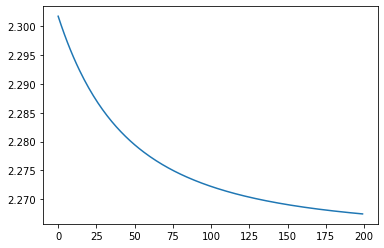

In [110]:
# Import packages needed to read and print our data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Declare PATH_to_Dataset
ROOT_PATH = "C:/Users/USER/Desktop/Datasets/Kaggle_Digit_Recognizer/"

# List the files in the ROOT_PATH
print(f"In the Root Path, there are {os.listdir(ROOT_PATH)}")

# Store the file names in the ROOT_PATH
CSV_TEST = ROOT_PATH + "test.csv"
CSV_TRAIN= ROOT_PATH + "train.csv"

# Initialize Parameters
K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8 = Initialize_Parameters(-0.01, 0.01)

# Read CSV File Through Pandas
DF_TRAIN = pd.read_csv(CSV_TRAIN)
DF_TRAIN_NO_LABLE = DF_TRAIN.drop(columns=["label"], axis=0)
Epoch = 200
loss_list = []

i = 1
lr = 0.001
for epoch in range(Epoch):
    tmp_list = []
    tic = time.time()
    for i in range(len(DF_TRAIN[:50])):
        
        # 1. Pick one example
        X, Y = pick_an_example(i, DF_TRAIN)
        X = X / 255.0
        Y_truth = np.zeros((1,10))
        Y_truth[0][Y] = 1
    
        # 2. Forward Pass
        cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8)
    
        # 3. Cross Entropy Loss
        tmp_list.append(cross_entropy(Y_pred, Y_truth))
        
        # 4. Backward Pass
        D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1 = LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth)
    
        # 5. Update Weights
        W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1 = update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1)
        #if epoch % 10 == 0: lr = lr * 0.3
        
        print(f"[{round(cross_entropy(Y_pred, Y_truth),4)}] The {i}-th example: \nY_pred: {Y_pred},\nY_truth: {Y_truth}\n")
    loss_list.append(np.mean(tmp_list))
    toc = time.time()
    #print(f"[{round(toc - tic, 2)} (s)] \nIn The {epoch}-th epoch: the avg. loss is {np.mean(tmp_list)}\nThe {i}-th example: \nY_pred: {Y_pred},\nY_truth: {Y_truth}\n")
    
    
plt.plot(loss_list)

In [100]:
DF_TRAIN["label"][:30]

import collections

print(collections.Counter(DF_TRAIN["label"][:50]))

Counter({1: 8, 3: 7, 4: 6, 9: 6, 0: 5, 7: 5, 2: 5, 8: 3, 6: 3, 5: 2})
